In [1]:
import tensorflow as tf
import tensorflow.keras.preprocessing as prep
import keras
# setup the const variables
print('tensorflow version', tf.__version__)
print('keras version', keras.__version__)

# the path of the data
DATA_PATH = (
    "dataset/Image_Classification/dataset_24581896"
)
import glob
maximum_file = [x for x in glob.glob(f"{DATA_PATH}/**/*.jpg")]
print(len(maximum_file))

BATCH_SIZE = 32
STEP_PER_EPOCH = len(maximum_file) // BATCH_SIZE
EPOCH = 50


2024-05-08 13:08:15.184370: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 13:08:15.335800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-05-08 13:08:15.847200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow version 2.16.1
keras version 3.0.5
3236


In [2]:
def prepare_data(data_path, batch_size):
    """
    make the data ready for the model
    split the data into training, validation and testing
    train_ds: the training data
    val_ds: the validation data
    test_ds: the testing data
    
    train : 64%
    validation : 16%
    test : 20%
    """
    # !pip install split-folders
    import splitfolders
    import tensorflow as tf
    import tensorflow.keras.preprocessing as prep
    import os

    temp_output = "dataset/Image_Classification__temp"

    if os.path.exists(temp_output) == False:
        splitfolders.ratio(
            DATA_PATH,
            output=temp_output,
            seed=24581896,
            ratio=(0.64, 0.16, 0.2),
            group_prefix=None,
        )

    # # create a image generator
    img_gen = prep.image.ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.05,
        height_shift_range=0.05,    
        zoom_range=0.5  ,
        horizontal_flip=True,
        vertical_flip=True,
    )
    

    # load the data
    train_ds = img_gen.flow_from_directory(
        temp_output + "/train",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )

    val_ds = img_gen.flow_from_directory(
        temp_output + "/val",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )
    
    test_ds = img_gen.flow_from_directory(
        temp_output + "/test",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )

    labels = train_ds.class_indices.keys()
    num_classes = len(labels)
    train_ds.save_to_dir = temp_output + "/train"

    return train_ds, val_ds, test_ds, labels, num_classes

In [3]:
train_ds, val_ds, test_ds, class_names, num_classes = prepare_data(DATA_PATH, BATCH_SIZE)

Found 2061 images belonging to 20 classes.


Found 508 images belonging to 20 classes.


Found 667 images belonging to 20 classes.


In [4]:
type(train_ds)
# train_ds.labels
train_ds.class_indices.keys()

dict_keys(['AMETHYST WOODSTAR', 'BLACK THROATED HUET', 'Bedlington_terrier', 'CAMPO FLICKER', 'DOWNY WOODPECKER', 'ELEGANT TROGON', 'EntleBucher', 'FIERY MINIVET', 'GREATER PRAIRIE CHICKEN', 'Great_Dane', 'KING EIDER', 'KING VULTURE', 'ORNATE HAWK EAGLE', 'Saint_Bernard', 'Shetland_sheepdog', 'Walker_hound', 'black-and-tan_coonhound', 'boxer', 'dingo', 'toy_terrier'])

## step 2. Create a Classifiers mdoel 

1. Customize AlexNet/GoogleNet/ResNet etc. and reduce/increase the layers, Train, and Test for image classification.

In [5]:
import tensorflow
import tensorflow.keras
from tensorflow.keras import models, layers, applications as apps, callbacks
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import seaborn

# from models.inception_v4 import inception_v4

# resnet implement


def view_train_chart(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()


def create_model__resnetv2(num_classes):
    """
    # the model creation for resnet-v2 implement
    # since the keras team have not yet anwser the [issue](https://github.com/keras-team/keras/issues/18903)
    # here I manual convert the model from Sequential to Functional based
    model = models.Sequential(
         [
             layers.Input((256, 256, 3)),
             apps.ResNet152V2(
                 include_top=False,
                 weights="imagenet",
                 pooling="avg",
             ),
             layers.Flatten(),
             layers.Dense(4096, activation="relu"),
             layers.Dense(1000, activation="relu"),
             layers.Dense(num_classes, activation="softmax", name="predictions"),
         ]
     )
    """

    # init
    # _input_layer = layers.Input(shape=(256, 256, 3))
    # _applicate_layer = apps.ResNet152V2(
    #     include_top=False, weights="imagenet", pooling="avg"
    # )(_input_layer)
    # # _flatten_layer = layers.Flatten()(_applicate_layer)
    # _dense_layer_1 = layers.Dense(4096, activation="relu")(_applicate_layer)
    # _dense_layer_2 = layers.Dense(1000, activation="relu")(_dense_layer_1)
    # _dense_layer_3 = layers.Dense(
    #     num_classes, activation="softmax", name="predictions"
    # )(_dense_layer_2)
    # return models.Model(inputs=_input_layer, outputs=_dense_layer_3)
    model = models.Sequential(
        [
            layers.Input((256, 256, 3)),
            apps.ResNet152V2(
                include_top=False,
                weights="imagenet",
                pooling="avg",
            ),
            layers.Dense(4096, activation="relu"),
            layers.Dense(1000, activation="relu"),
            layers.Dense(num_classes, activation="softmax", name="predictions"),
        ]
    )
    return model


# google net (inception_v4)
def create_model__inception_v3(num_classes):
    """
    # the model creation for resnet-v2 implement
    # since the keras team have not yet anwser the [issue](https://github.com/keras-team/keras/issues/18903)
    # here I manual convert the model from Sequential to Functional based
    model = models.Sequential(
        [
            layers.Input((256, 256, 3)),
            apps.InceptionV3(
                include_top=False,
                weights="imagenet",
                pooling="avg",
            ),
            layers.Flatten(),
            layers.Dense(4096, activation="relu"),
            layers.Dense(1000, activation="relu"),
            layers.Dense(num_classes, activation="softmax", name="predictions"),
        ]
    )
    """
    # init
    # _input_layer = layers.Input(shape=(256, 256, 3))
    # _applicate_layer = apps.InceptionV3(
    #     include_top=False, weights="imagenet", pooling="avg"
    # )(_input_layer)
    # # _flatten_layer = layers.Flatten()(_applicate_layer)
    # _dense_layer_1 = layers.Dense(4096, activation="relu")(_applicate_layer)
    # _dense_layer_2 = layers.Dense(1000, activation="relu")(_dense_layer_1)
    # _dense_layer_3 = layers.Dense(
    #     num_classes, activation="softmax", name="predictions"
    # )(_dense_layer_2)
    # return models.Model(inputs=_input_layer, outputs=_dense_layer_3)
    model = models.Sequential(
        [
            layers.Input((256, 256, 3)),
            apps.InceptionV3(
                include_top=False,
                weights="imagenet",
                pooling="avg",
            ),
            layers.Dense(4096, activation="relu"),
            layers.Dense(1000, activation="relu"),
            layers.Dense(num_classes, activation="softmax", name="predictions"),
        ]
    )
    return model


def train_model(model,model_name, train_ds, val_ds):
    # init

    now_time = f"{datetime.now():%Y-%m-%d_%H-%M-%S}"

    log_file_name = f"./logs/training__{model_name}__{now_time}.csv"

    open(log_file_name, 'a').close()

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["acc"],
    )

    ckp_weights_dir = f"./ckp_weights/img_clsr/{model_name}__{now_time}/"
    os.makedirs(ckp_weights_dir, exist_ok=True)

    checkpoint = callbacks.ModelCheckpoint(
        ckp_weights_dir + "{epoch:02d}-{val_loss:.2f}.weights.h5",
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    )

    cv_logging = callbacks.CSVLogger(log_file_name, separator=",", append=True)
    history = model.fit(
        train_ds,
        steps_per_epoch=STEP_PER_EPOCH,  # 2000 images = batch_size * steps
        epochs=EPOCH,
        validation_data=val_ds,
        validation_steps=STEP_PER_EPOCH//4,  # 1000 images = batch_size * steps
        callbacks=[checkpoint, cv_logging],
    )

    return model, history


def plot_roc_curve(y_true, y_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot( 
        fpr, tpr, color="darkorange", lw=2, 
        label="ROC curve (area = %0.2f)" % roc_auc
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

def summary_model(model):
    import visualkeras
    model.summary()
    visualkeras.layered_view( model, legend=True, ).show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm, annot=True, fmt="d", 
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()


def test_model(model_name, test_ds):
    print("test for " + model_name)
    #
    model = models.load_model(f"./models/img_clsr/{model_name}.keras")
    # Show the model architecture
    model.summary()
    # test the model
    loss, acc = model.evaluate(test_ds)
    print(f"Test loss: {loss}, acc: {acc}")

    y_pred = model.predict(test_ds)
    class_names = list(test_ds.class_indices.keys())
    plot_roc_curve(test_ds.labels, y_pred)
    plot_confusion_matrix(test_ds.labels, y_pred.argmax(axis=1), class_names)
    return loss, acc

2024-05-08 13:08:20.868830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 13:08:20.922002: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 2048)           │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 20)             │        20,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,841,372 (270.24 MB)

 Trainable params: 70,697,628 (269.69 MB)

 Non-trainable params: 143,744 (561.50 KB)

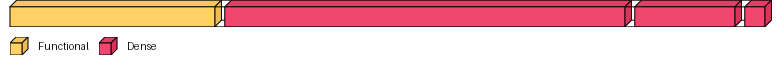

Epoch 1/50


/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:19:06 47s/step - acc: 0.0625 - loss: 3.0542

  2/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 8s/step - acc: 0.0859 - loss: 3.3428   

  3/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 8s/step - acc: 0.0920 - loss: 3.4161

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 8s/step - acc: 0.0924 - loss: 3.4181

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 8s/step - acc: 0.0902 - loss: 3.4102

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 8s/step - acc: 0.0891 - loss: 3.3973

  7/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 7s/step - acc: 0.0889 - loss: 3.3795

  8/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.0894 - loss: 3.3611

  9/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 8s/step - acc: 0.0898 - loss: 3.3436

 10/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - acc: 0.0908 - loss: 3.3257

 11/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.0912 - loss: 3.3099

 12/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 8s/step - acc: 0.0916 - loss: 3.2949

 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 8s/step - acc: 0.0919 - loss: 3.2809

 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 8s/step - acc: 0.0920 - loss: 3.2677

 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 8s/step - acc: 0.0920 - loss: 3.2557

 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - acc: 0.0921 - loss: 3.2445

 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 8s/step - acc: 0.0925 - loss: 3.2343

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - acc: 0.0929 - loss: 3.2244

 19/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - acc: 0.0933 - loss: 3.2152

 20/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 8s/step - acc: 0.0937 - loss: 3.2063

 21/101 ━━━━━━━━━━━━━━━━━━━━ 10:47 8s/step - acc: 0.0944 - loss: 3.1983

 22/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 8s/step - acc: 0.0951 - loss: 3.1907

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 8s/step - acc: 0.0957 - loss: 3.1839

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - acc: 0.0962 - loss: 3.1781

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - acc: 0.0968 - loss: 3.1726

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 8s/step - acc: 0.0974 - loss: 3.1676

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 8s/step - acc: 0.0980 - loss: 3.1629

 28/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 8s/step - acc: 0.0984 - loss: 3.1584 

 29/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 8s/step - acc: 0.0988 - loss: 3.1541

 30/101 ━━━━━━━━━━━━━━━━━━━━ 9:44 8s/step - acc: 0.0991 - loss: 3.1501

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 8s/step - acc: 0.0994 - loss: 3.1463

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 8s/step - acc: 0.0996 - loss: 3.1427

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 8s/step - acc: 0.0998 - loss: 3.1392

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 8s/step - acc: 0.0999 - loss: 3.1359

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 8s/step - acc: 0.1000 - loss: 3.1328

 36/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 8s/step - acc: 0.1002 - loss: 3.1296

 37/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 8s/step - acc: 0.1003 - loss: 3.1266

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 8s/step - acc: 0.1003 - loss: 3.1237

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 8s/step - acc: 0.1003 - loss: 3.1210

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 8s/step - acc: 0.1004 - loss: 3.1183

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 8s/step - acc: 0.1004 - loss: 3.1158

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 8s/step - acc: 0.1004 - loss: 3.1132

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 8s/step - acc: 0.1005 - loss: 3.1109

 44/101 ━━━━━━━━━━━━━━━━━━━━ 7:55 8s/step - acc: 0.1005 - loss: 3.1086

 45/101 ━━━━━━━━━━━━━━━━━━━━ 7:47 8s/step - acc: 0.1005 - loss: 3.1063

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:39 8s/step - acc: 0.1005 - loss: 3.1041

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:31 8s/step - acc: 0.1005 - loss: 3.1021

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 8s/step - acc: 0.1004 - loss: 3.1000

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:14 8s/step - acc: 0.1004 - loss: 3.0980

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 8s/step - acc: 0.1004 - loss: 3.0960

 51/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 8s/step - acc: 0.1003 - loss: 3.0940

 52/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 8s/step - acc: 0.1003 - loss: 3.0921

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 8s/step - acc: 0.1003 - loss: 3.0902

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 8s/step - acc: 0.1003 - loss: 3.0883

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 8s/step - acc: 0.1003 - loss: 3.0864

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 8s/step - acc: 0.1003 - loss: 3.0847

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 8s/step - acc: 0.1003 - loss: 3.0829

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 8s/step - acc: 0.1003 - loss: 3.0813

 59/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 8s/step - acc: 0.1003 - loss: 3.0796

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 8s/step - acc: 0.1003 - loss: 3.0779

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 8s/step - acc: 0.1003 - loss: 3.0762

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 8s/step - acc: 0.1004 - loss: 3.0745

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 8s/step - acc: 0.1004 - loss: 3.0729

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 8s/step - acc: 0.1004 - loss: 3.0713

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 8s/step - acc: 0.1004 - loss: 3.0698

2024-05-08 13:18:10.329481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2024-05-08 13:18:47.397719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.1013 - loss: 3.0179 - val_acc: 0.0472 - val_loss: 12047.3008


Epoch 2/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:18 14s/step - acc: 0.0625 - loss: 2.8971

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.0547 - loss: 2.9048 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.0642 - loss: 2.8909

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.0658 - loss: 2.8852

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.0701 - loss: 2.8824

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:38 9s/step - acc: 0.0732 - loss: 2.8806

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 9s/step - acc: 0.0748 - loss: 2.8769

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.0753 - loss: 2.8761

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.0754 - loss: 2.8753

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.0763 - loss: 2.8737

 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.0768 - loss: 2.8728

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.0772 - loss: 2.8719

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.0777 - loss: 2.8708

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.0784 - loss: 2.8696

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.0787 - loss: 2.8695

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.0795 - loss: 2.8692

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.0804 - loss: 2.8689

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.0814 - loss: 2.8683

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.0822 - loss: 2.8681

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.0830 - loss: 2.8682

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.0836 - loss: 2.8683

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - acc: 0.0841 - loss: 2.8686

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 9s/step - acc: 0.0847 - loss: 2.8689

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.0853 - loss: 2.8691

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.0861 - loss: 2.8691

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - acc: 0.0868 - loss: 2.8692

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.0874 - loss: 2.8693

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.0879 - loss: 2.8695

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.0884 - loss: 2.8696

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.0890 - loss: 2.8695

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.0895 - loss: 2.8696

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.0900 - loss: 2.8695 

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.0905 - loss: 2.8693

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.0910 - loss: 2.8691

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.0915 - loss: 2.8689

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.0920 - loss: 2.8684

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.0925 - loss: 2.8681

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.0930 - loss: 2.8679

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.0936 - loss: 2.8675

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.0941 - loss: 2.8672

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:39 9s/step - acc: 0.0946 - loss: 2.8669

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:30 9s/step - acc: 0.0951 - loss: 2.8665

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:22 9s/step - acc: 0.0957 - loss: 2.8661

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:13 9s/step - acc: 0.0962 - loss: 2.8655

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:04 9s/step - acc: 0.0967 - loss: 2.8652

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:56 9s/step - acc: 0.0972 - loss: 2.8648

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:47 9s/step - acc: 0.0977 - loss: 2.8643

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:38 9s/step - acc: 0.0981 - loss: 2.8640

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:30 9s/step - acc: 0.0985 - loss: 2.8636

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:21 9s/step - acc: 0.0988 - loss: 2.8632

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:12 9s/step - acc: 0.0992 - loss: 2.8628

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:04 9s/step - acc: 0.0996 - loss: 2.8624

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.1000 - loss: 2.8620

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1004 - loss: 2.8615

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.1008 - loss: 2.8611

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.1011 - loss: 2.8607

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.1015 - loss: 2.8603

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.1018 - loss: 2.8600

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.1022 - loss: 2.8596

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.1026 - loss: 2.8592

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.1030 - loss: 2.8589

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.1033 - loss: 2.8585

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:25 9s/step - acc: 0.1037 - loss: 2.8583

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:16 9s/step - acc: 0.1040 - loss: 2.8581

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:08 9s/step - acc: 0.1043 - loss: 2.8579

2024-05-08 13:28:10.361720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 13:28:44.769365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 597s 6s/step - acc: 0.1105 - loss: 2.8384 - val_acc: 0.0531 - val_loss: 4358.1172


Epoch 3/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:18 14s/step - acc: 0.0938 - loss: 2.9718

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.1094 - loss: 2.9726 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.1076 - loss: 2.9721

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:56 9s/step - acc: 0.1042 - loss: 2.9669

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.1033 - loss: 2.9580

  6/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 8s/step - acc: 0.1025 - loss: 2.9528

  7/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - acc: 0.1004 - loss: 2.9479

  8/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 8s/step - acc: 0.0994 - loss: 2.9430

  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 8s/step - acc: 0.0995 - loss: 2.9370

 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 8s/step - acc: 0.0999 - loss: 2.9313

 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 8s/step - acc: 0.0998 - loss: 2.9288

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - acc: 0.1004 - loss: 2.9260

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 8s/step - acc: 0.1008 - loss: 2.9245

 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - acc: 0.1009 - loss: 2.9233

 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 8s/step - acc: 0.1009 - loss: 2.9225

 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 8s/step - acc: 0.1009 - loss: 2.9214

 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.1011 - loss: 2.9200

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 8s/step - acc: 0.1013 - loss: 2.9183

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 8s/step - acc: 0.1014 - loss: 2.9166

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - acc: 0.1014 - loss: 2.9149

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 8s/step - acc: 0.1015 - loss: 2.9132

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 8s/step - acc: 0.1017 - loss: 2.9111

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 8s/step - acc: 0.1020 - loss: 2.9092

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 8s/step - acc: 0.1024 - loss: 2.9071

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 8s/step - acc: 0.1028 - loss: 2.9049

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 8s/step - acc: 0.1032 - loss: 2.9028

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 8s/step - acc: 0.1036 - loss: 2.9007

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 8s/step - acc: 0.1041 - loss: 2.8986

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 8s/step - acc: 0.1046 - loss: 2.8964

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 8s/step - acc: 0.1051 - loss: 2.8947

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 8s/step - acc: 0.1055 - loss: 2.8929 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 8s/step - acc: 0.1059 - loss: 2.8910

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 8s/step - acc: 0.1063 - loss: 2.8892

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.1066 - loss: 2.8877

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.1069 - loss: 2.8861

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.1073 - loss: 2.8844

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.1076 - loss: 2.8828

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.1079 - loss: 2.8811

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:48 9s/step - acc: 0.1082 - loss: 2.8796

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:40 9s/step - acc: 0.1085 - loss: 2.8781

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:32 9s/step - acc: 0.1087 - loss: 2.8767

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:23 9s/step - acc: 0.1090 - loss: 2.8753

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:15 9s/step - acc: 0.1092 - loss: 2.8739

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.1095 - loss: 2.8726

 45/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - acc: 0.1097 - loss: 2.8714

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.1099 - loss: 2.8702

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.1101 - loss: 2.8689

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:33 9s/step - acc: 0.1103 - loss: 2.8677

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.1104 - loss: 2.8664

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.1106 - loss: 2.8652

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.1108 - loss: 2.8640

 52/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.1110 - loss: 2.8627

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.1112 - loss: 2.8616

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.1113 - loss: 2.8604

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.1115 - loss: 2.8592

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.1116 - loss: 2.8582

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.1117 - loss: 2.8572

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.1119 - loss: 2.8562

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:00 9s/step - acc: 0.1120 - loss: 2.8553

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.1121 - loss: 2.8544

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:43 9s/step - acc: 0.1122 - loss: 2.8535

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:34 9s/step - acc: 0.1123 - loss: 2.8525

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:26 9s/step - acc: 0.1124 - loss: 2.8517

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:17 9s/step - acc: 0.1126 - loss: 2.8508

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - acc: 0.1127 - loss: 2.8499

2024-05-08 13:38:09.050236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 13:38:43.404887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - acc: 0.1158 - loss: 2.8144 - val_acc: 0.1043 - val_loss: 9.3727


Epoch 4/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:20 14s/step - acc: 0.0938 - loss: 2.7049

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.1094 - loss: 2.6798 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.1181 - loss: 2.6831

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.1296 - loss: 2.6893

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.1336 - loss: 2.6887

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.1365 - loss: 2.6871

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.1394 - loss: 2.6819

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.1405 - loss: 2.6845

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.1407 - loss: 2.6853

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.1416 - loss: 2.6831

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.1424 - loss: 2.6811

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.1432 - loss: 2.6794

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.1432 - loss: 2.6775

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.1435 - loss: 2.6757

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.1444 - loss: 2.6722

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.1452 - loss: 2.6685

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.1461 - loss: 2.6649

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.1468 - loss: 2.6616

 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.1473 - loss: 2.6592

 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.1476 - loss: 2.6581

 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.1477 - loss: 2.6573

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.1478 - loss: 2.6562

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.1477 - loss: 2.6556

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 9s/step - acc: 0.1476 - loss: 2.6549

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - acc: 0.1475 - loss: 2.6542

 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 9s/step - acc: 0.1474 - loss: 2.6535

 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 9s/step - acc: 0.1475 - loss: 2.6527

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.1476 - loss: 2.6519

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:45 9s/step - acc: 0.1479 - loss: 2.6510

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.1481 - loss: 2.6505

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.1484 - loss: 2.6498

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:16 9s/step - acc: 0.1488 - loss: 2.6492

 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:07 9s/step - acc: 0.1492 - loss: 2.6487

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.1495 - loss: 2.6484 

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.1496 - loss: 2.6482

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.1498 - loss: 2.6482

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.1499 - loss: 2.6480

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.1499 - loss: 2.6478

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.1499 - loss: 2.6480

 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.1499 - loss: 2.6481

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.1499 - loss: 2.6483

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.1499 - loss: 2.6484

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.1499 - loss: 2.6485

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.1498 - loss: 2.6485

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.1499 - loss: 2.6485

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.1499 - loss: 2.6484

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.1499 - loss: 2.6483

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.1499 - loss: 2.6482

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:40 9s/step - acc: 0.1499 - loss: 2.6480

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:31 9s/step - acc: 0.1500 - loss: 2.6478

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.1500 - loss: 2.6475

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:13 9s/step - acc: 0.1500 - loss: 2.6473

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:04 9s/step - acc: 0.1500 - loss: 2.6470

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.1500 - loss: 2.6469

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1501 - loss: 2.6466

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.1501 - loss: 2.6464

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.1501 - loss: 2.6461

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.1501 - loss: 2.6458

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.1502 - loss: 2.6455

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.1502 - loss: 2.6451

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.1502 - loss: 2.6448

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.1502 - loss: 2.6446

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.1502 - loss: 2.6443

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.1503 - loss: 2.6440

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:14 9s/step - acc: 0.1503 - loss: 2.6437

2024-05-08 13:48:16.784843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 13:48:51.118753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 608s 6s/step - acc: 0.1514 - loss: 2.6219 - val_acc: 0.1181 - val_loss: 3.0463


Epoch 5/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:12 14s/step - acc: 0.2188 - loss: 2.4865

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:32 9s/step - acc: 0.1953 - loss: 2.5688 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:32 9s/step - acc: 0.1892 - loss: 2.6051

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:24 9s/step - acc: 0.1947 - loss: 2.6126

  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.1945 - loss: 2.6066

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.1951 - loss: 2.6037

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - acc: 0.1965 - loss: 2.6002

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.1973 - loss: 2.5970

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.1974 - loss: 2.5933

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.1964 - loss: 2.5918

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.1959 - loss: 2.5887

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.1950 - loss: 2.5873

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.1936 - loss: 2.5872

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.1926 - loss: 2.5863

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.1919 - loss: 2.5853

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 9s/step - acc: 0.1911 - loss: 2.5843

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.1899 - loss: 2.5841

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.1886 - loss: 2.5843

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.1872 - loss: 2.5849

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.1862 - loss: 2.5856

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.1853 - loss: 2.5869

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.1846 - loss: 2.5877

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.1842 - loss: 2.5880

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.1840 - loss: 2.5883

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.1840 - loss: 2.5879

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.1841 - loss: 2.5871

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.1842 - loss: 2.5864

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.1843 - loss: 2.5854

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.1845 - loss: 2.5847

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.1846 - loss: 2.5839

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.1846 - loss: 2.5831

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.1846 - loss: 2.5825

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.1846 - loss: 2.5820 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.1847 - loss: 2.5814

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.1848 - loss: 2.5808

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.1849 - loss: 2.5801

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.1850 - loss: 2.5796

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.1850 - loss: 2.5791

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.1850 - loss: 2.5788

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.1850 - loss: 2.5785

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.1851 - loss: 2.5782

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.1851 - loss: 2.5779

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.1850 - loss: 2.5779

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.1850 - loss: 2.5780

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.1849 - loss: 2.5781

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.1848 - loss: 2.5782

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.1848 - loss: 2.5783

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.1847 - loss: 2.5784

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.1846 - loss: 2.5785

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.1845 - loss: 2.5786

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.1844 - loss: 2.5787

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.1842 - loss: 2.5788

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.1841 - loss: 2.5789

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.1840 - loss: 2.5791

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.1839 - loss: 2.5792

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.1838 - loss: 2.5792

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.1837 - loss: 2.5792

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.1837 - loss: 2.5791

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.1836 - loss: 2.5791

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.1835 - loss: 2.5790

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.1834 - loss: 2.5790

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.1833 - loss: 2.5790

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:26 9s/step - acc: 0.1832 - loss: 2.5790

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.1831 - loss: 2.5790

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - acc: 0.1831 - loss: 2.5789

2024-05-08 13:58:16.434415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 13:58:50.726655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.1813 - loss: 2.5629 - val_acc: 0.1339 - val_loss: 2.8407


Epoch 6/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 30:07 18s/step - acc: 0.3438 - loss: 2.2766

  2/101 ━━━━━━━━━━━━━━━━━━━━ 18:35 11s/step - acc: 0.2734 - loss: 2.4460

  3/101 ━━━━━━━━━━━━━━━━━━━━ 16:16 10s/step - acc: 0.2413 - loss: 2.5255

  4/101 ━━━━━━━━━━━━━━━━━━━━ 15:24 10s/step - acc: 0.2240 - loss: 2.5511

  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:55 9s/step - acc: 0.2154 - loss: 2.5637 

  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:34 9s/step - acc: 0.2073 - loss: 2.5781

  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.2013 - loss: 2.5855

  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.1966 - loss: 2.5903

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.1948 - loss: 2.5920

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.1929 - loss: 2.5931

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.1919 - loss: 2.5931

 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.1911 - loss: 2.5928

 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.1906 - loss: 2.5924

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.1901 - loss: 2.5929

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.1891 - loss: 2.5940

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.1877 - loss: 2.5959

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.1869 - loss: 2.5968

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.1866 - loss: 2.5968

 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.1865 - loss: 2.5964

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.1863 - loss: 2.5954

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.1864 - loss: 2.5942

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.1865 - loss: 2.5925

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.1863 - loss: 2.5911

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.1863 - loss: 2.5894

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.1861 - loss: 2.5879

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.1862 - loss: 2.5864

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.1862 - loss: 2.5850

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.1863 - loss: 2.5831

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.1864 - loss: 2.5809

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - acc: 0.1864 - loss: 2.5795

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:16 9s/step - acc: 0.1864 - loss: 2.5780

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:07 9s/step - acc: 0.1863 - loss: 2.5766

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.1862 - loss: 2.5752 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.1863 - loss: 2.5737

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.1864 - loss: 2.5721

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.1865 - loss: 2.5705

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.1865 - loss: 2.5691

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.1865 - loss: 2.5680

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.1864 - loss: 2.5670

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.1864 - loss: 2.5662

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.1864 - loss: 2.5653

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.1864 - loss: 2.5645

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.1864 - loss: 2.5636

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.1863 - loss: 2.5631

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.1863 - loss: 2.5627

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.1862 - loss: 2.5622

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.1862 - loss: 2.5619

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.1861 - loss: 2.5616

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.1860 - loss: 2.5612

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.1860 - loss: 2.5609

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.1859 - loss: 2.5607

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.1858 - loss: 2.5604

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.1858 - loss: 2.5602

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1858 - loss: 2.5600

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.1857 - loss: 2.5597

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.1856 - loss: 2.5594

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - acc: 0.1856 - loss: 2.5590

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.1856 - loss: 2.5588

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.1855 - loss: 2.5585

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.1856 - loss: 2.5582

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.1856 - loss: 2.5579

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.1856 - loss: 2.5575

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.1856 - loss: 2.5571

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.1856 - loss: 2.5567

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.1856 - loss: 2.5562

2024-05-08 14:08:23.982141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - acc: 0.1855 - loss: 2.5325 - val_acc: 0.1063 - val_loss: 122.7318


Epoch 7/50


2024-05-08 14:08:58.335991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:08 14s/step - acc: 0.1875 - loss: 2.5704

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.1719 - loss: 2.5942 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:05 9s/step - acc: 0.1771 - loss: 2.5764

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.1836 - loss: 2.5648

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:48 9s/step - acc: 0.1869 - loss: 2.5498

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.1913 - loss: 2.5325

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.1920 - loss: 2.5225

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.1934 - loss: 2.5181

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.1947 - loss: 2.5116

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.1965 - loss: 2.5036

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.1970 - loss: 2.4990

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.1966 - loss: 2.4957

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.1959 - loss: 2.4922

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.1955 - loss: 2.4883

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.1951 - loss: 2.4852

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.1945 - loss: 2.4827

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.1937 - loss: 2.4800

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.1928 - loss: 2.4790

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.1919 - loss: 2.4779

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.1912 - loss: 2.4767

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.1905 - loss: 2.4761

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 9s/step - acc: 0.1896 - loss: 2.4757

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:21 9s/step - acc: 0.1890 - loss: 2.4753

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:12 9s/step - acc: 0.1884 - loss: 2.4746

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 9s/step - acc: 0.1878 - loss: 2.4741

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.1874 - loss: 2.4737

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.1873 - loss: 2.4730

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.1870 - loss: 2.4731

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - acc: 0.1868 - loss: 2.4729

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 9s/step - acc: 0.1867 - loss: 2.4727

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 9s/step - acc: 0.1866 - loss: 2.4725

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:02 9s/step - acc: 0.1865 - loss: 2.4723

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.1863 - loss: 2.4727 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 9s/step - acc: 0.1862 - loss: 2.4730

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 9s/step - acc: 0.1861 - loss: 2.4732

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:27 9s/step - acc: 0.1860 - loss: 2.4733

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:18 9s/step - acc: 0.1860 - loss: 2.4733

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.1859 - loss: 2.4735

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 9s/step - acc: 0.1858 - loss: 2.4735

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.1857 - loss: 2.4736

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.1857 - loss: 2.4734

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.1856 - loss: 2.4734

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.1855 - loss: 2.4733

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.1854 - loss: 2.4734

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.1853 - loss: 2.4733

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.1852 - loss: 2.4734

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.1851 - loss: 2.4734

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.1851 - loss: 2.4734

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.1850 - loss: 2.4734

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.1850 - loss: 2.4734

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.1849 - loss: 2.4733

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.1849 - loss: 2.4734

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.1848 - loss: 2.4735

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.1848 - loss: 2.4735

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.1847 - loss: 2.4736

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.1846 - loss: 2.4736

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.1845 - loss: 2.4736

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.1844 - loss: 2.4736

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.1843 - loss: 2.4737

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.1842 - loss: 2.4738

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.1840 - loss: 2.4740

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.1839 - loss: 2.4741

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.1838 - loss: 2.4742

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.1837 - loss: 2.4743

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.1836 - loss: 2.4744

2024-05-08 14:18:24.036328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.1807 - loss: 2.4628 - val_acc: 0.0866 - val_loss: 8.6708


Epoch 8/50


2024-05-08 14:18:58.608808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:23 14s/step - acc: 0.0938 - loss: 2.5817

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.1094 - loss: 2.5731 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.1181 - loss: 2.5619

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.1296 - loss: 2.5741

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.1399 - loss: 2.5683

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.1470 - loss: 2.5638

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:39 9s/step - acc: 0.1540 - loss: 2.5568

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 9s/step - acc: 0.1616 - loss: 2.5480

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.1676 - loss: 2.5435

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.1715 - loss: 2.5419

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.1739 - loss: 2.5408

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.1759 - loss: 2.5391

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.1776 - loss: 2.5371

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.1792 - loss: 2.5362

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.1810 - loss: 2.5340

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 9s/step - acc: 0.1823 - loss: 2.5325

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.1835 - loss: 2.5320

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.1843 - loss: 2.5314

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.1848 - loss: 2.5311

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.1852 - loss: 2.5308

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.1854 - loss: 2.5300

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.1854 - loss: 2.5299

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.1855 - loss: 2.5297

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.1854 - loss: 2.5295

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.1853 - loss: 2.5289

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.1854 - loss: 2.5281

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.1857 - loss: 2.5272

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.1860 - loss: 2.5262

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.1862 - loss: 2.5254

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.1865 - loss: 2.5244

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.1867 - loss: 2.5234

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.1869 - loss: 2.5223

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.1871 - loss: 2.5214 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.1873 - loss: 2.5205

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.1875 - loss: 2.5195

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.1876 - loss: 2.5187

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.1878 - loss: 2.5179

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.1879 - loss: 2.5172

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.1880 - loss: 2.5165

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.1881 - loss: 2.5158

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.1882 - loss: 2.5152

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.1884 - loss: 2.5145

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.1885 - loss: 2.5139

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.1885 - loss: 2.5133

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.1886 - loss: 2.5127

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - acc: 0.1887 - loss: 2.5120

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.1888 - loss: 2.5113

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.1890 - loss: 2.5106

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.1891 - loss: 2.5099

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.1892 - loss: 2.5091

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.1894 - loss: 2.5084

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.1895 - loss: 2.5077

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.1897 - loss: 2.5071

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.1898 - loss: 2.5065

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.1898 - loss: 2.5062

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.1899 - loss: 2.5059

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.1900 - loss: 2.5055

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.1900 - loss: 2.5052

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.1901 - loss: 2.5048

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.1902 - loss: 2.5046

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.1902 - loss: 2.5043

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.1902 - loss: 2.5040

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.1902 - loss: 2.5038

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.1903 - loss: 2.5035

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.1903 - loss: 2.5032

2024-05-08 14:28:24.095569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.1906 - loss: 2.4831 - val_acc: 0.1063 - val_loss: 5.3083


Epoch 9/50


2024-05-08 14:28:58.510530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 22:34 14s/step - acc: 0.3438 - loss: 2.1595

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.2969 - loss: 2.2201 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.2847 - loss: 2.2206

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.2741 - loss: 2.2432

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.2730 - loss: 2.2490

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.2692 - loss: 2.2601

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.2639 - loss: 2.2707

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.2587 - loss: 2.2782

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.2555 - loss: 2.2842

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.2533 - loss: 2.2875

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.2512 - loss: 2.2917

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.2492 - loss: 2.2958

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - acc: 0.2474 - loss: 2.2988

 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - acc: 0.2463 - loss: 2.3012

 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 8s/step - acc: 0.2455 - loss: 2.3033

 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - acc: 0.2443 - loss: 2.3057

 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 8s/step - acc: 0.2431 - loss: 2.3072

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 8s/step - acc: 0.2417 - loss: 2.3096

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 8s/step - acc: 0.2403 - loss: 2.3113

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:21 8s/step - acc: 0.2392 - loss: 2.3128

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 8s/step - acc: 0.2382 - loss: 2.3140

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 8s/step - acc: 0.2368 - loss: 2.3173

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - acc: 0.2354 - loss: 2.3207

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 8s/step - acc: 0.2340 - loss: 2.3238

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - acc: 0.2326 - loss: 2.3268

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 8s/step - acc: 0.2310 - loss: 2.3299

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.2296 - loss: 2.3331

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.2283 - loss: 2.3360

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.2271 - loss: 2.3388

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.2260 - loss: 2.3414

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.2250 - loss: 2.3439 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.2242 - loss: 2.3463

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.2234 - loss: 2.3486

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.2227 - loss: 2.3507

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.2220 - loss: 2.3527

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.2213 - loss: 2.3547

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.2205 - loss: 2.3567

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.2198 - loss: 2.3587

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.2191 - loss: 2.3605

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.2185 - loss: 2.3621

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.2178 - loss: 2.3640

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.2173 - loss: 2.3657

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.2169 - loss: 2.3672

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.2164 - loss: 2.3688

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.2160 - loss: 2.3702

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.2157 - loss: 2.3715

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.2153 - loss: 2.3729

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.2150 - loss: 2.3742

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2147 - loss: 2.3754

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.2145 - loss: 2.3765

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.2142 - loss: 2.3776

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.2140 - loss: 2.3787

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.2138 - loss: 2.3797

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.2135 - loss: 2.3807

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.2133 - loss: 2.3817

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.2131 - loss: 2.3826

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.2129 - loss: 2.3835

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.2127 - loss: 2.3843

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.2126 - loss: 2.3851

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.2124 - loss: 2.3858

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.2123 - loss: 2.3867

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.2121 - loss: 2.3875

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.2119 - loss: 2.3883

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.2118 - loss: 2.3890

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - acc: 0.2116 - loss: 2.3896

2024-05-08 14:38:23.013405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - acc: 0.2083 - loss: 2.3910 - val_acc: 0.1358 - val_loss: 2.9260


Epoch 10/50


2024-05-08 14:38:57.435195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:34 14s/step - acc: 0.2812 - loss: 2.1828

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.2500 - loss: 2.2703 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.2431 - loss: 2.2748

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.2350 - loss: 2.2710

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.2330 - loss: 2.2580

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.2298 - loss: 2.2701

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.2282 - loss: 2.2781

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.2285 - loss: 2.2810

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.2293 - loss: 2.2852

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.2298 - loss: 2.2911

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.2301 - loss: 2.2958

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.2300 - loss: 2.3008

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.2305 - loss: 2.3039

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.2314 - loss: 2.3061

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.2321 - loss: 2.3077

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.2322 - loss: 2.3109

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.2324 - loss: 2.3137

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.2331 - loss: 2.3151

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.2335 - loss: 2.3169

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.2337 - loss: 2.3181

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.2341 - loss: 2.3188

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.2346 - loss: 2.3194

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.2349 - loss: 2.3199

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.2350 - loss: 2.3206

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.2351 - loss: 2.3215

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.2351 - loss: 2.3222

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.2351 - loss: 2.3228

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.2352 - loss: 2.3234

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.2352 - loss: 2.3240

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.2351 - loss: 2.3245

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.2350 - loss: 2.3252

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.2349 - loss: 2.3258

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.2348 - loss: 2.3262 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.2347 - loss: 2.3266

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.2347 - loss: 2.3270

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.2347 - loss: 2.3274

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.2347 - loss: 2.3279

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.2346 - loss: 2.3284

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.2346 - loss: 2.3293

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.2346 - loss: 2.3301

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.2345 - loss: 2.3309

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.2344 - loss: 2.3320

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.2342 - loss: 2.3331

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.2340 - loss: 2.3342

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.2338 - loss: 2.3353

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.2335 - loss: 2.3365

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.2333 - loss: 2.3375

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.2330 - loss: 2.3386

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2327 - loss: 2.3397

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.2324 - loss: 2.3407

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.2322 - loss: 2.3417

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.2319 - loss: 2.3427

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.2316 - loss: 2.3438

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.2313 - loss: 2.3448

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.2311 - loss: 2.3459

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.2308 - loss: 2.3469

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.2306 - loss: 2.3479

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.2304 - loss: 2.3489

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.2302 - loss: 2.3499

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.2300 - loss: 2.3508

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.2298 - loss: 2.3517

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.2296 - loss: 2.3525

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.2294 - loss: 2.3534

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.2292 - loss: 2.3542

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - acc: 0.2289 - loss: 2.3550

2024-05-08 14:48:22.534153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.2236 - loss: 2.3612 - val_acc: 0.1437 - val_loss: 4.2757


Epoch 11/50


2024-05-08 14:48:57.045115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:18 14s/step - acc: 0.2500 - loss: 2.3416

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.2500 - loss: 2.3244 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2674 - loss: 2.3009

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.2728 - loss: 2.2967

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.2732 - loss: 2.3098

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.2702 - loss: 2.3187

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.2699 - loss: 2.3185

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.2698 - loss: 2.3152

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.2688 - loss: 2.3125

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.2688 - loss: 2.3099

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.2686 - loss: 2.3086

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.2673 - loss: 2.3100

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.2667 - loss: 2.3096

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.2668 - loss: 2.3089

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.2662 - loss: 2.3085

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.2650 - loss: 2.3082

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.2635 - loss: 2.3083

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.2618 - loss: 2.3084

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.2600 - loss: 2.3082

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.2582 - loss: 2.3081

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.2566 - loss: 2.3079

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.2553 - loss: 2.3073

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.2540 - loss: 2.3071

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.2530 - loss: 2.3071

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.2522 - loss: 2.3069

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.2513 - loss: 2.3069

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.2504 - loss: 2.3074

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.2494 - loss: 2.3082

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.2483 - loss: 2.3092

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.2473 - loss: 2.3102

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.2465 - loss: 2.3110

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.2456 - loss: 2.3119

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.2447 - loss: 2.3129 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.2438 - loss: 2.3137

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.2430 - loss: 2.3144

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.2423 - loss: 2.3151

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.2416 - loss: 2.3156

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.2410 - loss: 2.3159

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.2405 - loss: 2.3161

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.2401 - loss: 2.3161

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:41 9s/step - acc: 0.2397 - loss: 2.3159

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.2393 - loss: 2.3160

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:24 9s/step - acc: 0.2389 - loss: 2.3162

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:15 9s/step - acc: 0.2385 - loss: 2.3164

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.2382 - loss: 2.3166

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - acc: 0.2379 - loss: 2.3166

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:49 9s/step - acc: 0.2377 - loss: 2.3166

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.2374 - loss: 2.3165

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.2372 - loss: 2.3164

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.2370 - loss: 2.3163

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.2369 - loss: 2.3161

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.2367 - loss: 2.3159

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:57 9s/step - acc: 0.2366 - loss: 2.3157

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.2364 - loss: 2.3154

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:40 9s/step - acc: 0.2363 - loss: 2.3151

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:31 9s/step - acc: 0.2362 - loss: 2.3149

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:22 9s/step - acc: 0.2361 - loss: 2.3146

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 9s/step - acc: 0.2361 - loss: 2.3143

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:05 9s/step - acc: 0.2360 - loss: 2.3141

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:56 9s/step - acc: 0.2360 - loss: 2.3138

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 9s/step - acc: 0.2360 - loss: 2.3135

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.2360 - loss: 2.3133

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:30 9s/step - acc: 0.2360 - loss: 2.3130

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.2360 - loss: 2.3126

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.2360 - loss: 2.3122

2024-05-08 14:58:22.206979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.2358 - loss: 2.2915 - val_acc: 0.1122 - val_loss: 3.1783


Epoch 12/50


2024-05-08 14:58:56.600963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:15 14s/step - acc: 0.1250 - loss: 2.5918

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.1562 - loss: 2.5055 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.1771 - loss: 2.4586

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.1875 - loss: 2.4367

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.1937 - loss: 2.4178

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.2049 - loss: 2.3953

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.2145 - loss: 2.3741

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.2209 - loss: 2.3594

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.2253 - loss: 2.3478

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.2290 - loss: 2.3370

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.2314 - loss: 2.3290

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.2334 - loss: 2.3223

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.2347 - loss: 2.3170

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.2355 - loss: 2.3123

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.2363 - loss: 2.3073

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.2374 - loss: 2.3016

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.2386 - loss: 2.2958

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.2397 - loss: 2.2915

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.2404 - loss: 2.2879

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.2410 - loss: 2.2847

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.2414 - loss: 2.2815

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.2415 - loss: 2.2799

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.2418 - loss: 2.2780

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.2420 - loss: 2.2767

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.2420 - loss: 2.2751

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.2421 - loss: 2.2734

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.2421 - loss: 2.2717

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.2421 - loss: 2.2704

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.2422 - loss: 2.2692

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.2421 - loss: 2.2685

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.2422 - loss: 2.2677

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.2423 - loss: 2.2668

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.2425 - loss: 2.2658 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.2427 - loss: 2.2651

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.2428 - loss: 2.2645

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.2429 - loss: 2.2641

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.2430 - loss: 2.2635

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.2431 - loss: 2.2631

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.2432 - loss: 2.2625

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.2433 - loss: 2.2620

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:41 9s/step - acc: 0.2433 - loss: 2.2616

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.2434 - loss: 2.2613

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:24 9s/step - acc: 0.2434 - loss: 2.2609

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.2434 - loss: 2.2606

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.2433 - loss: 2.2604

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - acc: 0.2432 - loss: 2.2601

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.2430 - loss: 2.2600

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.2429 - loss: 2.2597

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.2428 - loss: 2.2593

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.2427 - loss: 2.2590

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.2426 - loss: 2.2587

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.2426 - loss: 2.2584

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:57 9s/step - acc: 0.2426 - loss: 2.2580

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.2426 - loss: 2.2575

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:40 9s/step - acc: 0.2426 - loss: 2.2570

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:31 9s/step - acc: 0.2427 - loss: 2.2565

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:22 9s/step - acc: 0.2427 - loss: 2.2560

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 9s/step - acc: 0.2428 - loss: 2.2555

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:05 9s/step - acc: 0.2428 - loss: 2.2550

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:56 9s/step - acc: 0.2428 - loss: 2.2546

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 9s/step - acc: 0.2429 - loss: 2.2542

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.2429 - loss: 2.2540

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.2428 - loss: 2.2539

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.2428 - loss: 2.2538

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.2428 - loss: 2.2537

2024-05-08 15:08:21.908762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.2422 - loss: 2.2386 - val_acc: 0.1260 - val_loss: 3.0390


Epoch 13/50


2024-05-08 15:08:56.262533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:21 14s/step - acc: 0.4375 - loss: 2.0797

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.3906 - loss: 2.1314 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.3681 - loss: 2.1587

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:05 9s/step - acc: 0.3561 - loss: 2.1667

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:56 9s/step - acc: 0.3449 - loss: 2.1756

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.3378 - loss: 2.1784

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.3342 - loss: 2.1731

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.3295 - loss: 2.1696

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.3272 - loss: 2.1654

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.3257 - loss: 2.1598

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.3248 - loss: 2.1558

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.3236 - loss: 2.1532

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.3216 - loss: 2.1523

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.3192 - loss: 2.1535

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.3171 - loss: 2.1540

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.3161 - loss: 2.1533

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.3151 - loss: 2.1522

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.3142 - loss: 2.1511

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.3132 - loss: 2.1497

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.3124 - loss: 2.1481

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.3114 - loss: 2.1484

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.3105 - loss: 2.1480

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.3098 - loss: 2.1475

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.3092 - loss: 2.1469

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.3084 - loss: 2.1461

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.3075 - loss: 2.1460

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.3066 - loss: 2.1464

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.3057 - loss: 2.1467

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.3047 - loss: 2.1468

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.3037 - loss: 2.1474

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.3028 - loss: 2.1476

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.3018 - loss: 2.1483

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.3010 - loss: 2.1489 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.3003 - loss: 2.1494

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.2995 - loss: 2.1501

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.2988 - loss: 2.1507

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - acc: 0.2981 - loss: 2.1513

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.2973 - loss: 2.1520

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.2966 - loss: 2.1526

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.2961 - loss: 2.1531

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.2955 - loss: 2.1537

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.2949 - loss: 2.1542

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.2944 - loss: 2.1550

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.2938 - loss: 2.1557

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.2932 - loss: 2.1566

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.2927 - loss: 2.1572

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.2922 - loss: 2.1579

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.2917 - loss: 2.1587

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2912 - loss: 2.1594

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.2907 - loss: 2.1601

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.2903 - loss: 2.1606

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.2899 - loss: 2.1612

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.2895 - loss: 2.1617

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.2891 - loss: 2.1622

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.2887 - loss: 2.1627

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.2883 - loss: 2.1632

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.2879 - loss: 2.1637

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.2876 - loss: 2.1641

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.2872 - loss: 2.1644

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.2869 - loss: 2.1648

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.2866 - loss: 2.1650

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.2863 - loss: 2.1652

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.2860 - loss: 2.1654

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.2857 - loss: 2.1657

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.2853 - loss: 2.1660

2024-05-08 15:18:21.653279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.2777 - loss: 2.1604 - val_acc: 0.1713 - val_loss: 3.0394


Epoch 14/50


2024-05-08 15:18:55.910150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:17 14s/step - acc: 0.2188 - loss: 2.0965

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.2031 - loss: 2.1324 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2083 - loss: 2.1497

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.2031 - loss: 2.1719

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.2062 - loss: 2.1692

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.2101 - loss: 2.1643

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.2151 - loss: 2.1585

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.2200 - loss: 2.1524

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.2225 - loss: 2.1503

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.2250 - loss: 2.1485

 11/101 ━━━━━━━━━━━━━━━━━━━━ 20:35 14s/step - acc: 0.2270 - loss: 2.1456

 12/101 ━━━━━━━━━━━━━━━━━━━━ 19:39 13s/step - acc: 0.2289 - loss: 2.1420

 13/101 ━━━━━━━━━━━━━━━━━━━━ 18:50 13s/step - acc: 0.2307 - loss: 2.1394

 14/101 ━━━━━━━━━━━━━━━━━━━━ 17:31 12s/step - acc: 0.2317 - loss: 2.1464

 15/101 ━━━━━━━━━━━━━━━━━━━━ 16:57 12s/step - acc: 0.2330 - loss: 2.1511

 16/101 ━━━━━━━━━━━━━━━━━━━━ 16:27 12s/step - acc: 0.2346 - loss: 2.1543

 17/101 ━━━━━━━━━━━━━━━━━━━━ 16:00 11s/step - acc: 0.2355 - loss: 2.1580

 18/101 ━━━━━━━━━━━━━━━━━━━━ 15:34 11s/step - acc: 0.2365 - loss: 2.1609

 19/101 ━━━━━━━━━━━━━━━━━━━━ 15:11 11s/step - acc: 0.2379 - loss: 2.1628

 20/101 ━━━━━━━━━━━━━━━━━━━━ 14:49 11s/step - acc: 0.2390 - loss: 2.1654

 21/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 11s/step - acc: 0.2401 - loss: 2.1675

 22/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 11s/step - acc: 0.2411 - loss: 2.1694

 23/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 11s/step - acc: 0.2419 - loss: 2.1713

 24/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 11s/step - acc: 0.2426 - loss: 2.1730

 25/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 10s/step - acc: 0.2433 - loss: 2.1748

 26/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 10s/step - acc: 0.2438 - loss: 2.1763

 27/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 10s/step - acc: 0.2442 - loss: 2.1778

 28/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 10s/step - acc: 0.2445 - loss: 2.1792

 29/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 10s/step - acc: 0.2448 - loss: 2.1805

 30/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 10s/step - acc: 0.2452 - loss: 2.1820

 31/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 10s/step - acc: 0.2455 - loss: 2.1830

 32/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 10s/step - acc: 0.2459 - loss: 2.1838

 33/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 10s/step - acc: 0.2461 - loss: 2.1845

 34/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 10s/step - acc: 0.2465 - loss: 2.1850

 35/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 10s/step - acc: 0.2467 - loss: 2.1857

 36/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 10s/step - acc: 0.2468 - loss: 2.1869

 37/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 10s/step - acc: 0.2470 - loss: 2.1879

 38/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 10s/step - acc: 0.2473 - loss: 2.1886

 39/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 10s/step - acc: 0.2477 - loss: 2.1891

 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 10s/step - acc: 0.2481 - loss: 2.1894 

 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 10s/step - acc: 0.2485 - loss: 2.1896

 42/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 10s/step - acc: 0.2489 - loss: 2.1897

 43/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 10s/step - acc: 0.2492 - loss: 2.1900

 44/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 10s/step - acc: 0.2494 - loss: 2.1902

 45/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 10s/step - acc: 0.2497 - loss: 2.1902

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 10s/step - acc: 0.2500 - loss: 2.1903

 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:39 10s/step - acc: 0.2502 - loss: 2.1903

 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 10s/step - acc: 0.2505 - loss: 2.1904

 49/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 10s/step - acc: 0.2507 - loss: 2.1905

 50/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 10s/step - acc: 0.2510 - loss: 2.1905

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 10s/step - acc: 0.2512 - loss: 2.1906

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:47 10s/step - acc: 0.2515 - loss: 2.1908

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 10s/step - acc: 0.2517 - loss: 2.1908

 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 10s/step - acc: 0.2520 - loss: 2.1907

 55/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.2522 - loss: 2.1907 

 56/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.2525 - loss: 2.1906

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:56 9s/step - acc: 0.2528 - loss: 2.1905

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.2530 - loss: 2.1906

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.2532 - loss: 2.1906

 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.2535 - loss: 2.1906

 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.2537 - loss: 2.1905

 62/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.2539 - loss: 2.1904

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:56 9s/step - acc: 0.2541 - loss: 2.1903

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.2543 - loss: 2.1904

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.2545 - loss: 2.1905

2024-05-08 15:29:09.401453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 15:29:43.836649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 649s 6s/step - acc: 0.2585 - loss: 2.1795 - val_acc: 0.2106 - val_loss: 2.2974


Epoch 15/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:20 14s/step - acc: 0.4062 - loss: 1.7800

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.3984 - loss: 1.8651 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.3976 - loss: 1.8915

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.3880 - loss: 1.9172

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.3817 - loss: 1.9367

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.3771 - loss: 1.9481

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.3730 - loss: 1.9497

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.3678 - loss: 1.9537

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.3636 - loss: 1.9579

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.3594 - loss: 1.9606

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.3554 - loss: 1.9615

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.3523 - loss: 1.9616

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.3494 - loss: 1.9628

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.3465 - loss: 1.9648

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.3439 - loss: 1.9668

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.3417 - loss: 1.9686

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.3393 - loss: 1.9712

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.3373 - loss: 1.9733

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.3355 - loss: 1.9748

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.3338 - loss: 1.9768

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.3323 - loss: 1.9787

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.3307 - loss: 1.9815

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.3292 - loss: 1.9844

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.3278 - loss: 1.9871

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.3264 - loss: 1.9896

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.3250 - loss: 1.9925

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.3238 - loss: 1.9950

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.3225 - loss: 1.9978

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.3213 - loss: 2.0006

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.3202 - loss: 2.0032

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.3191 - loss: 2.0060

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.3181 - loss: 2.0085

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.3172 - loss: 2.0107 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.3165 - loss: 2.0129

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:35 9s/step - acc: 0.3159 - loss: 2.0146

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.3154 - loss: 2.0160

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.3149 - loss: 2.0173

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.3145 - loss: 2.0186

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.3141 - loss: 2.0199

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.3136 - loss: 2.0211

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.3132 - loss: 2.0221

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.3127 - loss: 2.0235

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.3122 - loss: 2.0250

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.3118 - loss: 2.0264

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.3113 - loss: 2.0276

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.3109 - loss: 2.0290

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.3105 - loss: 2.0303

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.3102 - loss: 2.0315

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.3099 - loss: 2.0327

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.3096 - loss: 2.0339

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.3094 - loss: 2.0350

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.3091 - loss: 2.0362

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.3088 - loss: 2.0374

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.3085 - loss: 2.0386

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.3082 - loss: 2.0398

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.3079 - loss: 2.0409

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.3077 - loss: 2.0420

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.3075 - loss: 2.0432

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.3073 - loss: 2.0442

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.3071 - loss: 2.0453

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.3069 - loss: 2.0464

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.3066 - loss: 2.0476

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.3064 - loss: 2.0487

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.3062 - loss: 2.0498

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.3059 - loss: 2.0509

2024-05-08 15:39:10.153517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.3005 - loss: 2.0648 - val_acc: 0.1772 - val_loss: 3.3720


Epoch 16/50


2024-05-08 15:39:44.618656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:15 14s/step - acc: 0.3438 - loss: 2.0845

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.3594 - loss: 2.0115 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.3576 - loss: 1.9998

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.3444 - loss: 2.0132

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.3330 - loss: 2.0293

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - acc: 0.3244 - loss: 2.0393

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:38 9s/step - acc: 0.3208 - loss: 2.0444

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 9s/step - acc: 0.3193 - loss: 2.0459

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.3200 - loss: 2.0431

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.3212 - loss: 2.0399

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 9s/step - acc: 0.3214 - loss: 2.0377

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.3211 - loss: 2.0372

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.3204 - loss: 2.0377

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.3196 - loss: 2.0381

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.3199 - loss: 2.0370

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.3208 - loss: 2.0350

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.3211 - loss: 2.0345

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.3217 - loss: 2.0331

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.3226 - loss: 2.0311

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.3235 - loss: 2.0299

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.3240 - loss: 2.0299

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.3242 - loss: 2.0302

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.3242 - loss: 2.0309

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.3240 - loss: 2.0324

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.3240 - loss: 2.0334

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.3242 - loss: 2.0339

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.3244 - loss: 2.0341

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.3244 - loss: 2.0343

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.3243 - loss: 2.0344

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.3242 - loss: 2.0346

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.3240 - loss: 2.0347

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.3238 - loss: 2.0348

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.3234 - loss: 2.0351 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.3231 - loss: 2.0351

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:35 9s/step - acc: 0.3230 - loss: 2.0351

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.3229 - loss: 2.0350

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.3229 - loss: 2.0346

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.3228 - loss: 2.0343

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.3227 - loss: 2.0342

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.3226 - loss: 2.0341

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.3225 - loss: 2.0340

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.3224 - loss: 2.0338

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.3224 - loss: 2.0334

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.3224 - loss: 2.0331

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.3223 - loss: 2.0331

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.3222 - loss: 2.0331

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3221 - loss: 2.0330

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.3220 - loss: 2.0330

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3219 - loss: 2.0330

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3218 - loss: 2.0331

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.3216 - loss: 2.0333

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.3214 - loss: 2.0337

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.3211 - loss: 2.0341

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.3209 - loss: 2.0345

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.3206 - loss: 2.0349

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.3204 - loss: 2.0353

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.3201 - loss: 2.0356

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.3200 - loss: 2.0359

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.3198 - loss: 2.0362

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.3196 - loss: 2.0365

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.3195 - loss: 2.0367

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.3194 - loss: 2.0368

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.3193 - loss: 2.0368

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.3191 - loss: 2.0370

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.3190 - loss: 2.0371

2024-05-08 15:49:10.296677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.3163 - loss: 2.0285 - val_acc: 0.1693 - val_loss: 4.0085


Epoch 17/50


2024-05-08 15:49:44.719672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:17 14s/step - acc: 0.3750 - loss: 1.8581

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.3359 - loss: 1.9279 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.3385 - loss: 1.9382

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.3340 - loss: 1.9519

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.3334 - loss: 1.9511

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.3317 - loss: 1.9506

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.3296 - loss: 1.9499

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.3274 - loss: 1.9516

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.3250 - loss: 1.9519

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.3219 - loss: 1.9520

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.3192 - loss: 1.9523

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.3178 - loss: 1.9514

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.3167 - loss: 1.9522

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.3149 - loss: 1.9546

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.3138 - loss: 1.9564

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.3127 - loss: 1.9587

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.3122 - loss: 1.9602

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.3115 - loss: 1.9618

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.3109 - loss: 1.9645

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.3101 - loss: 1.9673

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.3092 - loss: 1.9712

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.3084 - loss: 1.9749

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.3078 - loss: 1.9783

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.3072 - loss: 1.9815

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.3066 - loss: 1.9852

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.3061 - loss: 1.9885

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.3059 - loss: 1.9916

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.3055 - loss: 1.9952

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.3052 - loss: 1.9987

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.3048 - loss: 2.0019

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.3045 - loss: 2.0049

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.3043 - loss: 2.0077

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.3041 - loss: 2.0103 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.3040 - loss: 2.0127

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.3040 - loss: 2.0148

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.3040 - loss: 2.0170

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.3040 - loss: 2.0190

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.3038 - loss: 2.0210

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.3036 - loss: 2.0231

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.3035 - loss: 2.0250

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.3035 - loss: 2.0266

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.3034 - loss: 2.0281

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.3034 - loss: 2.0297

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.3032 - loss: 2.0313

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.3032 - loss: 2.0327

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.3032 - loss: 2.0340

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.3031 - loss: 2.0353

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.3031 - loss: 2.0363

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.3032 - loss: 2.0372

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.3033 - loss: 2.0380

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.3034 - loss: 2.0387

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.3035 - loss: 2.0393

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.3035 - loss: 2.0398

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.3036 - loss: 2.0404

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:40 9s/step - acc: 0.3037 - loss: 2.0409

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.3038 - loss: 2.0413

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.3039 - loss: 2.0416

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.3041 - loss: 2.0419

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.3042 - loss: 2.0423

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.3044 - loss: 2.0426

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.3046 - loss: 2.0429

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.3048 - loss: 2.0433

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.3050 - loss: 2.0436

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.3051 - loss: 2.0441

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.3053 - loss: 2.0444

2024-05-08 15:59:10.389840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.3098 - loss: 2.0402 - val_acc: 0.2008 - val_loss: 4.7085


Epoch 18/50


2024-05-08 15:59:44.845223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:44 14s/step - acc: 0.4062 - loss: 1.8021

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.3359 - loss: 1.9479 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.3142 - loss: 2.0342

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.3099 - loss: 2.0568

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.3142 - loss: 2.0523

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:48 9s/step - acc: 0.3139 - loss: 2.0511

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:38 9s/step - acc: 0.3137 - loss: 2.0555

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.3131 - loss: 2.0561

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.3126 - loss: 2.0564

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.3120 - loss: 2.0584

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.3123 - loss: 2.0582

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.3125 - loss: 2.0597

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.3131 - loss: 2.0589

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.3140 - loss: 2.0568

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.3147 - loss: 2.0556

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.3153 - loss: 2.0549

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.3157 - loss: 2.0530

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.3162 - loss: 2.0513

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.3167 - loss: 2.0493

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.3173 - loss: 2.0475

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 8s/step - acc: 0.3178 - loss: 2.0453

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 8s/step - acc: 0.3184 - loss: 2.0426

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - acc: 0.3192 - loss: 2.0399

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.3198 - loss: 2.0378

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - acc: 0.3203 - loss: 2.0358

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - acc: 0.3207 - loss: 2.0336

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.3210 - loss: 2.0316

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.3216 - loss: 2.0297

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.3220 - loss: 2.0278

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.3226 - loss: 2.0263

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3231 - loss: 2.0250 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.3236 - loss: 2.0236

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.3241 - loss: 2.0223

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.3244 - loss: 2.0212

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.3249 - loss: 2.0199

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.3254 - loss: 2.0186

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.3257 - loss: 2.0176

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.3262 - loss: 2.0168

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.3265 - loss: 2.0160

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.3268 - loss: 2.0154

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.3271 - loss: 2.0149

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.3273 - loss: 2.0147

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.3276 - loss: 2.0144

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.3278 - loss: 2.0143

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3279 - loss: 2.0142

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.3281 - loss: 2.0141

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3283 - loss: 2.0141

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.3285 - loss: 2.0139

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3287 - loss: 2.0137

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3289 - loss: 2.0136

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.3291 - loss: 2.0135

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.3292 - loss: 2.0135

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.3293 - loss: 2.0134

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.3295 - loss: 2.0133

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.3296 - loss: 2.0133

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.3297 - loss: 2.0133

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.3298 - loss: 2.0133

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.3298 - loss: 2.0134

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.3299 - loss: 2.0135

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.3300 - loss: 2.0136

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.3300 - loss: 2.0137

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.3301 - loss: 2.0136

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.3302 - loss: 2.0136

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.3303 - loss: 2.0135

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.3304 - loss: 2.0134

2024-05-08 16:09:11.022726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - acc: 0.3327 - loss: 2.0016 - val_acc: 0.2402 - val_loss: 2.9560


Epoch 19/50


2024-05-08 16:09:45.439448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:20 14s/step - acc: 0.3125 - loss: 1.9425

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.3203 - loss: 1.9281 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.3247 - loss: 1.9425

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.3372 - loss: 1.9258

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 9s/step - acc: 0.3485 - loss: 1.9179

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.3556 - loss: 1.9130

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.3602 - loss: 1.9042

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.3611 - loss: 1.8997

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.3611 - loss: 1.8962

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.3606 - loss: 1.8915

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.3601 - loss: 1.8881

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.3596 - loss: 1.8871

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.3591 - loss: 1.8863

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.3588 - loss: 1.8859

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.3591 - loss: 1.8852

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.3600 - loss: 1.8834

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.3607 - loss: 1.8819

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.3615 - loss: 1.8805

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.3619 - loss: 1.8796

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.3621 - loss: 1.8799

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.3621 - loss: 1.8805

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.3619 - loss: 1.8814

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.3617 - loss: 1.8824

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.3615 - loss: 1.8834

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.3609 - loss: 1.8858

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.3604 - loss: 1.8884

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.3600 - loss: 1.8909

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.3595 - loss: 1.8931

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.3592 - loss: 1.8951

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.3589 - loss: 1.8970

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.3585 - loss: 1.8988

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.3582 - loss: 1.9002

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.3580 - loss: 1.9016 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.3580 - loss: 1.9025

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.3580 - loss: 1.9033

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.3579 - loss: 1.9042

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.3577 - loss: 1.9051

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.3577 - loss: 1.9058

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.3576 - loss: 1.9063

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.3575 - loss: 1.9070

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.3573 - loss: 1.9076

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.3571 - loss: 1.9082

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.3570 - loss: 1.9087

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.3568 - loss: 1.9090

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.3567 - loss: 1.9093

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.3566 - loss: 1.9096

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.3565 - loss: 1.9098

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.3563 - loss: 1.9102

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:33 9s/step - acc: 0.3562 - loss: 1.9104

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.3561 - loss: 1.9105

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.3560 - loss: 1.9108

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 9s/step - acc: 0.3558 - loss: 1.9111

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.3557 - loss: 1.9114

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.3555 - loss: 1.9118

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:41 9s/step - acc: 0.3554 - loss: 1.9120

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:32 9s/step - acc: 0.3553 - loss: 1.9124

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:23 9s/step - acc: 0.3552 - loss: 1.9127

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.3550 - loss: 1.9130

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.3550 - loss: 1.9133

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.3549 - loss: 1.9135

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.3549 - loss: 1.9137

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.3548 - loss: 1.9139

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.3548 - loss: 1.9140

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.3548 - loss: 1.9141

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.3548 - loss: 1.9143

2024-05-08 16:19:11.965425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - acc: 0.3542 - loss: 1.9069 - val_acc: 0.2835 - val_loss: 2.5563


Epoch 20/50


2024-05-08 16:19:46.796406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:27 14s/step - acc: 0.5312 - loss: 1.6453

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.5156 - loss: 1.7161 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.5035 - loss: 1.7359

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.4889 - loss: 1.7561

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.4736 - loss: 1.7966

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.4598 - loss: 1.8273

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.4464 - loss: 1.8513

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:31 9s/step - acc: 0.4385 - loss: 1.8674

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.4322 - loss: 1.8870

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.4258 - loss: 1.9036

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.4207 - loss: 1.9164

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.4160 - loss: 1.9268

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.4125 - loss: 1.9336

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.4097 - loss: 1.9382

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.4082 - loss: 1.9408

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.4064 - loss: 1.9438

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.4046 - loss: 1.9459

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.4031 - loss: 1.9474

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.4015 - loss: 1.9483

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.3999 - loss: 1.9489

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.3987 - loss: 1.9486

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 9s/step - acc: 0.3974 - loss: 1.9478

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.3960 - loss: 1.9469

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 9s/step - acc: 0.3950 - loss: 1.9455

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 9s/step - acc: 0.3940 - loss: 1.9443

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 9s/step - acc: 0.3932 - loss: 1.9427

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:47 9s/step - acc: 0.3925 - loss: 1.9411

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.3916 - loss: 1.9397

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.3909 - loss: 1.9384

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.3902 - loss: 1.9373

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.3895 - loss: 1.9361

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.3889 - loss: 1.9354

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.3883 - loss: 1.9345 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.3878 - loss: 1.9336

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.3873 - loss: 1.9324

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.3871 - loss: 1.9311

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.3868 - loss: 1.9299

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.3864 - loss: 1.9288

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.3861 - loss: 1.9280

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.3857 - loss: 1.9275

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.3853 - loss: 1.9272

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.3849 - loss: 1.9269

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.3845 - loss: 1.9267

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.3841 - loss: 1.9267

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3837 - loss: 1.9266

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.3833 - loss: 1.9264

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.3829 - loss: 1.9264

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.3825 - loss: 1.9263

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.3822 - loss: 1.9261

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.3819 - loss: 1.9261

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:12 9s/step - acc: 0.3816 - loss: 1.9260

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.3814 - loss: 1.9257

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.3813 - loss: 1.9253

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.3811 - loss: 1.9250

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.3810 - loss: 1.9247

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.3808 - loss: 1.9243

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.3806 - loss: 1.9239

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.3805 - loss: 1.9235

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.3803 - loss: 1.9232

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.3802 - loss: 1.9228

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.3801 - loss: 1.9225

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.3799 - loss: 1.9222

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.3798 - loss: 1.9218

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.3796 - loss: 1.9214

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.3794 - loss: 1.9212

2024-05-08 16:29:15.309989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 603s 6s/step - acc: 0.3756 - loss: 1.9050 - val_acc: 0.2618 - val_loss: 2.4188


Epoch 21/50


2024-05-08 16:29:49.746034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:09 14s/step - acc: 0.4062 - loss: 1.7382

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.3828 - loss: 1.8066 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.3698 - loss: 1.8312

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.3555 - loss: 1.8558

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.3506 - loss: 1.8702

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.3521 - loss: 1.8806

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.3522 - loss: 1.8871

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.3526 - loss: 1.8896

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.3524 - loss: 1.8910

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.3528 - loss: 1.8919

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.3545 - loss: 1.8908

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.3556 - loss: 1.8919

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.3556 - loss: 1.8935

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.3562 - loss: 1.8938

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.3563 - loss: 1.8946

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.3568 - loss: 1.8945

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.3571 - loss: 1.8950

 18/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 10s/step - acc: 0.3573 - loss: 1.8946

 19/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 10s/step - acc: 0.3572 - loss: 1.8942

 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.3570 - loss: 1.8937 

 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.3566 - loss: 1.8934

 22/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.3562 - loss: 1.8933

 23/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.3558 - loss: 1.8934

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.3554 - loss: 1.8936

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.3550 - loss: 1.8935

 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.3545 - loss: 1.8934

 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.3542 - loss: 1.8934

 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.3539 - loss: 1.8934

 29/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.3537 - loss: 1.8934

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.3537 - loss: 1.8930

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.3535 - loss: 1.8926

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.3534 - loss: 1.8921

 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.3532 - loss: 1.8919

 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.3530 - loss: 1.8916

 35/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.3529 - loss: 1.8914

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.3528 - loss: 1.8911 

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.3527 - loss: 1.8909

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.3525 - loss: 1.8910

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.3522 - loss: 1.8913

 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.3521 - loss: 1.8914

 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.3519 - loss: 1.8914

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.3518 - loss: 1.8913

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3517 - loss: 1.8911

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3516 - loss: 1.8910

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.3516 - loss: 1.8907

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.3515 - loss: 1.8904

 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3515 - loss: 1.8900

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.3515 - loss: 1.8895

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.3515 - loss: 1.8891

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.3516 - loss: 1.8886

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.3516 - loss: 1.8883

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.3516 - loss: 1.8880

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 9s/step - acc: 0.3517 - loss: 1.8879

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.3516 - loss: 1.8881

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.3516 - loss: 1.8882

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:40 9s/step - acc: 0.3517 - loss: 1.8882

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:31 9s/step - acc: 0.3517 - loss: 1.8882

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:22 9s/step - acc: 0.3517 - loss: 1.8881

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 9s/step - acc: 0.3518 - loss: 1.8881

 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:04 9s/step - acc: 0.3518 - loss: 1.8880

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.3518 - loss: 1.8881

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.3518 - loss: 1.8882

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.3518 - loss: 1.8882

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3518 - loss: 1.8882

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.3518 - loss: 1.8882

2024-05-08 16:39:32.382774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 617s 6s/step - acc: 0.3527 - loss: 1.8778 - val_acc: 0.2776 - val_loss: 3.2490


Epoch 22/50


2024-05-08 16:40:07.015577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:18 14s/step - acc: 0.3438 - loss: 1.8059

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.3594 - loss: 1.8296 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.3715 - loss: 1.8276

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.3685 - loss: 1.8299

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:56 9s/step - acc: 0.3698 - loss: 1.8266

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - acc: 0.3707 - loss: 1.8239

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:39 9s/step - acc: 0.3700 - loss: 1.8349

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.3692 - loss: 1.8422

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.3694 - loss: 1.8487

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.3687 - loss: 1.8569

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.3683 - loss: 1.8617

 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.3675 - loss: 1.8641

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.3666 - loss: 1.8650

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.3656 - loss: 1.8661

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.3654 - loss: 1.8667

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.3650 - loss: 1.8679

 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 8s/step - acc: 0.3647 - loss: 1.8688

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.3645 - loss: 1.8689

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.3641 - loss: 1.8688

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.3640 - loss: 1.8683

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.3642 - loss: 1.8671

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.3640 - loss: 1.8665

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:12 9s/step - acc: 0.3640 - loss: 1.8661

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.3638 - loss: 1.8657

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.3638 - loss: 1.8649

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.3638 - loss: 1.8640

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.3638 - loss: 1.8629

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.3641 - loss: 1.8613

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - acc: 0.3645 - loss: 1.8595

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.3650 - loss: 1.8576

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.3656 - loss: 1.8553

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.3662 - loss: 1.8531

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.3668 - loss: 1.8510 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:44 9s/step - acc: 0.3673 - loss: 1.8491

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 9s/step - acc: 0.3677 - loss: 1.8478

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:27 9s/step - acc: 0.3682 - loss: 1.8465

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.3686 - loss: 1.8455

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.3690 - loss: 1.8445

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.3694 - loss: 1.8435

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.3698 - loss: 1.8430

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.3700 - loss: 1.8427

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.3703 - loss: 1.8424

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3706 - loss: 1.8421

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.3707 - loss: 1.8418

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.3709 - loss: 1.8415

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3711 - loss: 1.8412

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3713 - loss: 1.8410

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3715 - loss: 1.8407

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3717 - loss: 1.8405

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3719 - loss: 1.8403

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3720 - loss: 1.8403

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3721 - loss: 1.8402

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.3722 - loss: 1.8401

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.3723 - loss: 1.8400

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.3724 - loss: 1.8399

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.3725 - loss: 1.8398

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.3726 - loss: 1.8396

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.3727 - loss: 1.8396

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.3728 - loss: 1.8396

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.3729 - loss: 1.8396

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.3729 - loss: 1.8395

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 9s/step - acc: 0.3730 - loss: 1.8394

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 9s/step - acc: 0.3731 - loss: 1.8393

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:24 9s/step - acc: 0.3733 - loss: 1.8391

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:15 9s/step - acc: 0.3734 - loss: 1.8390

2024-05-08 16:49:42.274128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 610s 6s/step - acc: 0.3762 - loss: 1.8252 - val_acc: 0.2559 - val_loss: 2.9608


Epoch 23/50


2024-05-08 16:50:16.995759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 22:46 14s/step - acc: 0.5938 - loss: 1.3017

  2/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 3s/step - acc: 0.5413 - loss: 1.4790  

  3/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 6s/step - acc: 0.5384 - loss: 1.5000

  4/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 7s/step - acc: 0.5116 - loss: 1.5523

  5/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 7s/step - acc: 0.5029 - loss: 1.5778

  6/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - acc: 0.4865 - loss: 1.6294

  7/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 8s/step - acc: 0.4700 - loss: 1.6688

  8/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 8s/step - acc: 0.4576 - loss: 1.6953

  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 8s/step - acc: 0.4485 - loss: 1.7137

 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 8s/step - acc: 0.4405 - loss: 1.7270

 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 8s/step - acc: 0.4335 - loss: 1.7372

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 8s/step - acc: 0.4278 - loss: 1.7448

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 8s/step - acc: 0.4228 - loss: 1.7505

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 8s/step - acc: 0.4187 - loss: 1.7554

 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - acc: 0.4152 - loss: 1.7602

 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 8s/step - acc: 0.4117 - loss: 1.7652

 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 8s/step - acc: 0.4083 - loss: 1.7696

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.4052 - loss: 1.7739

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 8s/step - acc: 0.4024 - loss: 1.7780

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 8s/step - acc: 0.3998 - loss: 1.7818

 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.3978 - loss: 1.7856

 22/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.3959 - loss: 1.7893

 23/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.3941 - loss: 1.7924

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.3927 - loss: 1.7951

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.3917 - loss: 1.7969

 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.3906 - loss: 1.7991

 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.3894 - loss: 1.8009

 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.3881 - loss: 1.8027

 29/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.3868 - loss: 1.8042

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.3858 - loss: 1.8050

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.3848 - loss: 1.8055

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.3841 - loss: 1.8059

 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.3835 - loss: 1.8064

 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.3828 - loss: 1.8070

 35/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.3823 - loss: 1.8074

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - acc: 0.3817 - loss: 1.8079 

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.3813 - loss: 1.8082

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.3808 - loss: 1.8085

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3805 - loss: 1.8088

 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3801 - loss: 1.8091

 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.3799 - loss: 1.8093

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.3796 - loss: 1.8097

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.3794 - loss: 1.8101

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.3791 - loss: 1.8105

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.3788 - loss: 1.8109

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:15 9s/step - acc: 0.3785 - loss: 1.8112

 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:06 9s/step - acc: 0.3784 - loss: 1.8113

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:57 9s/step - acc: 0.3782 - loss: 1.8115

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:48 9s/step - acc: 0.3781 - loss: 1.8117

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:38 9s/step - acc: 0.3780 - loss: 1.8121

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:29 9s/step - acc: 0.3778 - loss: 1.8125

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.3777 - loss: 1.8127

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.3776 - loss: 1.8131

 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.3775 - loss: 1.8136

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.3774 - loss: 1.8139

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.3773 - loss: 1.8143

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.3772 - loss: 1.8148

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.3771 - loss: 1.8150

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.3770 - loss: 1.8153

 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.3769 - loss: 1.8155

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3768 - loss: 1.8157

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3768 - loss: 1.8158

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3767 - loss: 1.8159

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3767 - loss: 1.8159

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 9s/step - acc: 0.3767 - loss: 1.8160

2024-05-08 17:00:03.112100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 621s 6s/step - acc: 0.3756 - loss: 1.8091 - val_acc: 0.2953 - val_loss: 2.7695


Epoch 24/50


2024-05-08 17:00:37.740993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:50 14s/step - acc: 0.3438 - loss: 2.0275

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.3672 - loss: 1.9198 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.3837 - loss: 1.8977

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.3893 - loss: 1.8688

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.3927 - loss: 1.8523

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.3924 - loss: 1.8425

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.3956 - loss: 1.8314

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.3974 - loss: 1.8249

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.3980 - loss: 1.8210

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.3970 - loss: 1.8215

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.3965 - loss: 1.8221

 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.3960 - loss: 1.8213

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.3961 - loss: 1.8192

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.3955 - loss: 1.8178

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.3954 - loss: 1.8152

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.3957 - loss: 1.8125

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.3960 - loss: 1.8098

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.3962 - loss: 1.8072

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.3966 - loss: 1.8041

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.3972 - loss: 1.8014

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.3981 - loss: 1.7984

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.3989 - loss: 1.7959

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.3997 - loss: 1.7933

 24/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 10s/step - acc: 0.4006 - loss: 1.7910

 25/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 10s/step - acc: 0.4014 - loss: 1.7890

 26/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 10s/step - acc: 0.4021 - loss: 1.7869

 27/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 10s/step - acc: 0.4028 - loss: 1.7850

 28/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 10s/step - acc: 0.4032 - loss: 1.7837

 29/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 10s/step - acc: 0.4036 - loss: 1.7824

 30/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 10s/step - acc: 0.4040 - loss: 1.7813

 31/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 10s/step - acc: 0.4043 - loss: 1.7803

 32/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 10s/step - acc: 0.4047 - loss: 1.7793

 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 10s/step - acc: 0.4049 - loss: 1.7781

 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 10s/step - acc: 0.4051 - loss: 1.7772

 35/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 10s/step - acc: 0.4055 - loss: 1.7761

 36/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 10s/step - acc: 0.4057 - loss: 1.7751

 37/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 10s/step - acc: 0.4059 - loss: 1.7743

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 10s/step - acc: 0.4062 - loss: 1.7735 

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4064 - loss: 1.7728 

 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.4067 - loss: 1.7721

 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.4070 - loss: 1.7715

 42/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.4072 - loss: 1.7709

 43/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - acc: 0.4075 - loss: 1.7705

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4077 - loss: 1.7699

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.4079 - loss: 1.7694

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.4081 - loss: 1.7691

 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.4082 - loss: 1.7688

 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:15 9s/step - acc: 0.4083 - loss: 1.7686

 49/101 ━━━━━━━━━━━━━━━━━━━━ 8:04 9s/step - acc: 0.4083 - loss: 1.7685

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:55 9s/step - acc: 0.4084 - loss: 1.7684

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4084 - loss: 1.7681

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.4085 - loss: 1.7679

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.4085 - loss: 1.7679

 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.4085 - loss: 1.7679

 55/101 ━━━━━━━━━━━━━━━━━━━━ 7:05 9s/step - acc: 0.4085 - loss: 1.7678

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:56 9s/step - acc: 0.4085 - loss: 1.7678

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.4085 - loss: 1.7678

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.4084 - loss: 1.7678

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.4084 - loss: 1.7680

 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.4082 - loss: 1.7682

 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4081 - loss: 1.7684

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4080 - loss: 1.7686

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4079 - loss: 1.7689

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.4077 - loss: 1.7692

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:30 9s/step - acc: 0.4076 - loss: 1.7694

2024-05-08 17:10:38.877526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 636s 6s/step - acc: 0.4052 - loss: 1.7651 - val_acc: 0.1555 - val_loss: 4.6391


Epoch 25/50


2024-05-08 17:11:13.364870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:21 14s/step - acc: 0.3750 - loss: 1.8180

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:21 9s/step - acc: 0.3906 - loss: 1.7879 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.4097 - loss: 1.7552

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.4225 - loss: 1.7222

  5/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 7s/step - acc: 0.4274 - loss: 1.7141

  6/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - acc: 0.4294 - loss: 1.7085

  7/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 8s/step - acc: 0.4321 - loss: 1.7013

  8/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 8s/step - acc: 0.4346 - loss: 1.6940

  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 8s/step - acc: 0.4346 - loss: 1.6941

 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 8s/step - acc: 0.4360 - loss: 1.6926

 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 8s/step - acc: 0.4365 - loss: 1.6919

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 8s/step - acc: 0.4357 - loss: 1.6935

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 8s/step - acc: 0.4348 - loss: 1.6948

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - acc: 0.4333 - loss: 1.6965

 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.4321 - loss: 1.6997

 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 8s/step - acc: 0.4308 - loss: 1.7024

 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 8s/step - acc: 0.4297 - loss: 1.7054

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.4290 - loss: 1.7078

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 8s/step - acc: 0.4287 - loss: 1.7097

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 8s/step - acc: 0.4282 - loss: 1.7115

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 8s/step - acc: 0.4277 - loss: 1.7130

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 8s/step - acc: 0.4274 - loss: 1.7139

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 8s/step - acc: 0.4272 - loss: 1.7147

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 8s/step - acc: 0.4272 - loss: 1.7152

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4273 - loss: 1.7155

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.4274 - loss: 1.7161

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.4274 - loss: 1.7168

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.4274 - loss: 1.7172

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.4272 - loss: 1.7181

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.4269 - loss: 1.7192

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4267 - loss: 1.7200 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.4264 - loss: 1.7206

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.4262 - loss: 1.7215

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.4260 - loss: 1.7226

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.4257 - loss: 1.7234

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.4254 - loss: 1.7241

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.4252 - loss: 1.7248

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.4251 - loss: 1.7252

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.4249 - loss: 1.7258

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.4247 - loss: 1.7262

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.4246 - loss: 1.7265

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.4245 - loss: 1.7268

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4243 - loss: 1.7271

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4241 - loss: 1.7274

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4241 - loss: 1.7276

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4241 - loss: 1.7276

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4240 - loss: 1.7278

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.4239 - loss: 1.7281

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4239 - loss: 1.7283

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.4238 - loss: 1.7286

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.4237 - loss: 1.7288

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.4237 - loss: 1.7289

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.4237 - loss: 1.7289

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.4236 - loss: 1.7292

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4235 - loss: 1.7294

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.4234 - loss: 1.7297

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4233 - loss: 1.7298

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4232 - loss: 1.7300

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.4230 - loss: 1.7302

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4229 - loss: 1.7304

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4228 - loss: 1.7305

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4227 - loss: 1.7306

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4226 - loss: 1.7308

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4225 - loss: 1.7310

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4223 - loss: 1.7312

2024-05-08 17:20:41.502476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 603s 6s/step - acc: 0.4195 - loss: 1.7271 - val_acc: 0.2323 - val_loss: 5.8854


Epoch 26/50


2024-05-08 17:21:16.088438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 22:51 14s/step - acc: 0.5000 - loss: 1.6650

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.4531 - loss: 1.7185 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.4375 - loss: 1.7254

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.4277 - loss: 1.7411

  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:04 9s/step - acc: 0.4272 - loss: 1.7512

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 9s/step - acc: 0.4246 - loss: 1.7653

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.4245 - loss: 1.7692

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.4251 - loss: 1.7710

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.4250 - loss: 1.7720

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.4250 - loss: 1.7727

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.4259 - loss: 1.7707

 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.4260 - loss: 1.7703

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.4268 - loss: 1.7689

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.4271 - loss: 1.7677

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.4270 - loss: 1.7666

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.4263 - loss: 1.7661

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.4261 - loss: 1.7645

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.4255 - loss: 1.7643

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.4251 - loss: 1.7643

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.4248 - loss: 1.7639

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.4248 - loss: 1.7639

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.4250 - loss: 1.7634

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.4254 - loss: 1.7626

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 9s/step - acc: 0.4261 - loss: 1.7620

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4266 - loss: 1.7622

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.4271 - loss: 1.7621

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.4274 - loss: 1.7621

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.4275 - loss: 1.7623

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.4277 - loss: 1.7623

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.4276 - loss: 1.7628

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.4275 - loss: 1.7634 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - acc: 0.4274 - loss: 1.7636

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.4273 - loss: 1.7641

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.4271 - loss: 1.7646

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.4270 - loss: 1.7648

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.4269 - loss: 1.7648

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.4267 - loss: 1.7648

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 9s/step - acc: 0.4267 - loss: 1.7646

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.4267 - loss: 1.7644

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.4268 - loss: 1.7641

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.4268 - loss: 1.7638

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4268 - loss: 1.7634

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4268 - loss: 1.7631

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4268 - loss: 1.7625

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4268 - loss: 1.7619

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4269 - loss: 1.7612

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - acc: 0.4271 - loss: 1.7604

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.4273 - loss: 1.7596

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:29 9s/step - acc: 0.4274 - loss: 1.7589

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.4276 - loss: 1.7581

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:12 9s/step - acc: 0.4277 - loss: 1.7574

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.4279 - loss: 1.7567

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.4280 - loss: 1.7561

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.4282 - loss: 1.7556

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.4283 - loss: 1.7551

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.4284 - loss: 1.7547

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4284 - loss: 1.7543

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.4284 - loss: 1.7540

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.4285 - loss: 1.7537

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4285 - loss: 1.7533

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4286 - loss: 1.7529

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4286 - loss: 1.7525

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.4286 - loss: 1.7522

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4286 - loss: 1.7520

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4286 - loss: 1.7517

2024-05-08 17:30:44.025442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 602s 6s/step - acc: 0.4291 - loss: 1.7347 - val_acc: 0.2657 - val_loss: 3.1622


Epoch 27/50


2024-05-08 17:31:18.522208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:29 14s/step - acc: 0.5625 - loss: 1.6066

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.5156 - loss: 1.6312 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.4965 - loss: 1.6182

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.4818 - loss: 1.6227

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.4767 - loss: 1.6161

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - acc: 0.4762 - loss: 1.6095

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:38 9s/step - acc: 0.4758 - loss: 1.6063

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.4788 - loss: 1.5992

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.4819 - loss: 1.5941

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.4822 - loss: 1.5926

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.4830 - loss: 1.5887

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.4840 - loss: 1.5841

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.4851 - loss: 1.5804

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.4861 - loss: 1.5767

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.4868 - loss: 1.5741

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.4867 - loss: 1.5755

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.4868 - loss: 1.5767

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.4870 - loss: 1.5777

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.4871 - loss: 1.5785

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.4869 - loss: 1.5797

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.4868 - loss: 1.5807

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4867 - loss: 1.5809

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.4865 - loss: 1.5812

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:12 9s/step - acc: 0.4860 - loss: 1.5823

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 9s/step - acc: 0.4854 - loss: 1.5834

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.4848 - loss: 1.5844

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4840 - loss: 1.5856

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.4833 - loss: 1.5868

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.4827 - loss: 1.5877

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.4821 - loss: 1.5888

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.4815 - loss: 1.5898

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.4811 - loss: 1.5905

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:54 9s/step - acc: 0.4806 - loss: 1.5913 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.4800 - loss: 1.5922

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.4795 - loss: 1.5930

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.4788 - loss: 1.5944

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.4782 - loss: 1.5960

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 9s/step - acc: 0.4775 - loss: 1.5975

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.4769 - loss: 1.5989

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.4763 - loss: 1.6003

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.4757 - loss: 1.6017

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.4752 - loss: 1.6027

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4747 - loss: 1.6038

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4743 - loss: 1.6046

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4738 - loss: 1.6056

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4734 - loss: 1.6066

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4730 - loss: 1.6076

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.4726 - loss: 1.6085

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4722 - loss: 1.6093

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.4718 - loss: 1.6104

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.4714 - loss: 1.6114

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.4710 - loss: 1.6125

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.4706 - loss: 1.6135

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.4702 - loss: 1.6145

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4699 - loss: 1.6155

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.4695 - loss: 1.6165

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4692 - loss: 1.6174

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.4689 - loss: 1.6183

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.4686 - loss: 1.6191

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4683 - loss: 1.6200

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4681 - loss: 1.6208

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4679 - loss: 1.6215

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.4677 - loss: 1.6223

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4674 - loss: 1.6230

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4672 - loss: 1.6238

2024-05-08 17:40:47.101247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 17:41:21.774163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 604s 6s/step - acc: 0.4622 - loss: 1.6310 - val_acc: 0.3740 - val_loss: 2.1000


Epoch 28/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:33 14s/step - acc: 0.5000 - loss: 1.4433

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.4844 - loss: 1.4778 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.4722 - loss: 1.5237

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.4694 - loss: 1.5523

  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:04 9s/step - acc: 0.4630 - loss: 1.5819

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4588 - loss: 1.5986

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4545 - loss: 1.6150

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4504 - loss: 1.6270

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.4470 - loss: 1.6369

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4454 - loss: 1.6402

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4447 - loss: 1.6410

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.4437 - loss: 1.6425

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.4432 - loss: 1.6414

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.4428 - loss: 1.6400

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.4429 - loss: 1.6384

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.4425 - loss: 1.6377

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.4422 - loss: 1.6368

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.4419 - loss: 1.6368

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.4419 - loss: 1.6365

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.4423 - loss: 1.6355

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.4427 - loss: 1.6343

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.4432 - loss: 1.6327

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.4435 - loss: 1.6316

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 9s/step - acc: 0.4439 - loss: 1.6302

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.4443 - loss: 1.6291

 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.4447 - loss: 1.6284

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 9s/step - acc: 0.4451 - loss: 1.6275

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4455 - loss: 1.6266

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.4459 - loss: 1.6259

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - acc: 0.4462 - loss: 1.6252

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 9s/step - acc: 0.4465 - loss: 1.6244

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.4469 - loss: 1.6236

 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.4472 - loss: 1.6228

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.4474 - loss: 1.6222 

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.4477 - loss: 1.6218

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.4480 - loss: 1.6212

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.4482 - loss: 1.6206

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.4484 - loss: 1.6201

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.4486 - loss: 1.6198

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.4487 - loss: 1.6200

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:49 9s/step - acc: 0.4489 - loss: 1.6199

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:40 9s/step - acc: 0.4492 - loss: 1.6197

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:32 9s/step - acc: 0.4494 - loss: 1.6194

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:23 9s/step - acc: 0.4497 - loss: 1.6192

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:14 9s/step - acc: 0.4498 - loss: 1.6192

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:05 9s/step - acc: 0.4500 - loss: 1.6192

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:56 9s/step - acc: 0.4501 - loss: 1.6192

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:47 9s/step - acc: 0.4502 - loss: 1.6193

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.4502 - loss: 1.6195

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.4502 - loss: 1.6198

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.4502 - loss: 1.6200

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 9s/step - acc: 0.4502 - loss: 1.6204

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.4502 - loss: 1.6209

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.4501 - loss: 1.6214

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:41 9s/step - acc: 0.4500 - loss: 1.6219

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:32 9s/step - acc: 0.4499 - loss: 1.6224

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:23 9s/step - acc: 0.4499 - loss: 1.6228

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.4498 - loss: 1.6233

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.4497 - loss: 1.6237

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.4497 - loss: 1.6241

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4496 - loss: 1.6245

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.4496 - loss: 1.6249

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.4496 - loss: 1.6252

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.4495 - loss: 1.6257

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:14 9s/step - acc: 0.4495 - loss: 1.6261

2024-05-08 17:50:55.208439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 608s 6s/step - acc: 0.4487 - loss: 1.6273 - val_acc: 0.1083 - val_loss: 5.5427


Epoch 29/50


2024-05-08 17:51:30.123261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:33 14s/step - acc: 0.5312 - loss: 1.4551

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:31 9s/step - acc: 0.5078 - loss: 1.5231 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.4948 - loss: 1.5416

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.4883 - loss: 1.5439

  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.4819 - loss: 1.5464

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4745 - loss: 1.5595

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.4686 - loss: 1.5725

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.4652 - loss: 1.5811

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.4636 - loss: 1.5831

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.4629 - loss: 1.5850

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.4632 - loss: 1.5867

 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.4643 - loss: 1.5879

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4641 - loss: 1.5923

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.4633 - loss: 1.5952

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.4627 - loss: 1.5979

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.4625 - loss: 1.5993

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.4623 - loss: 1.6007

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.4623 - loss: 1.6017

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.4621 - loss: 1.6028

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.4618 - loss: 1.6039

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.4617 - loss: 1.6044

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.4614 - loss: 1.6049

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - acc: 0.4615 - loss: 1.6054

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.4618 - loss: 1.6054

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.4621 - loss: 1.6053

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.4625 - loss: 1.6049

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - acc: 0.4630 - loss: 1.6043

 28/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 10s/step - acc: 0.4636 - loss: 1.6033

 29/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 10s/step - acc: 0.4642 - loss: 1.6026

 30/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 10s/step - acc: 0.4647 - loss: 1.6018

 31/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 10s/step - acc: 0.4653 - loss: 1.6008

 32/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 10s/step - acc: 0.4658 - loss: 1.6001

 33/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 10s/step - acc: 0.4662 - loss: 1.5995

 34/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 10s/step - acc: 0.4666 - loss: 1.5991

 35/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 10s/step - acc: 0.4669 - loss: 1.5989

 36/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 10s/step - acc: 0.4669 - loss: 1.5990

 37/101 ━━━━━━━━━━━━━━━━━━━━ 10:39 10s/step - acc: 0.4669 - loss: 1.5995

 38/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 10s/step - acc: 0.4669 - loss: 1.6003

 39/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 10s/step - acc: 0.4668 - loss: 1.6009

 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:54 10s/step - acc: 0.4667 - loss: 1.6015 

 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 10s/step - acc: 0.4666 - loss: 1.6023

 42/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 10s/step - acc: 0.4664 - loss: 1.6032

 43/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 10s/step - acc: 0.4663 - loss: 1.6039

 44/101 ━━━━━━━━━━━━━━━━━━━━ 9:10 10s/step - acc: 0.4662 - loss: 1.6046

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 10s/step - acc: 0.4661 - loss: 1.6053

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:48 10s/step - acc: 0.4660 - loss: 1.6059

 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 10s/step - acc: 0.4659 - loss: 1.6065

 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 10s/step - acc: 0.4658 - loss: 1.6072

 49/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 10s/step - acc: 0.4657 - loss: 1.6077

 50/101 ━━━━━━━━━━━━━━━━━━━━ 8:06 10s/step - acc: 0.4656 - loss: 1.6082

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:56 10s/step - acc: 0.4656 - loss: 1.6087

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 10s/step - acc: 0.4655 - loss: 1.6091

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.4655 - loss: 1.6094 

 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.4654 - loss: 1.6097

 55/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.4653 - loss: 1.6101

 56/101 ━━━━━━━━━━━━━━━━━━━━ 7:05 9s/step - acc: 0.4653 - loss: 1.6103

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.4653 - loss: 1.6105

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.4653 - loss: 1.6107

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.4652 - loss: 1.6109

 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4652 - loss: 1.6111

 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.4652 - loss: 1.6112

 62/101 ━━━━━━━━━━━━━━━━━━━━ 6:05 9s/step - acc: 0.4652 - loss: 1.6111

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:56 9s/step - acc: 0.4652 - loss: 1.6110

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4652 - loss: 1.6110

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.4651 - loss: 1.6111

2024-05-08 18:01:42.669229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 18:02:17.239405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 648s 6s/step - acc: 0.4643 - loss: 1.6035 - val_acc: 0.4193 - val_loss: 1.8794


Epoch 30/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:28 14s/step - acc: 0.3438 - loss: 1.6276

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.3906 - loss: 1.5389 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4028 - loss: 1.5321

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.4251 - loss: 1.5039

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4401 - loss: 1.4940

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.4475 - loss: 1.4843

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:38 9s/step - acc: 0.4543 - loss: 1.4726

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 9s/step - acc: 0.4571 - loss: 1.4694

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.4584 - loss: 1.4694

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.4604 - loss: 1.4697

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 9s/step - acc: 0.4609 - loss: 1.4714

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.4613 - loss: 1.4734

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.4626 - loss: 1.4741

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.4637 - loss: 1.4744

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.4645 - loss: 1.4772

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.4655 - loss: 1.4786

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.4663 - loss: 1.4806

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.4666 - loss: 1.4833

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.4669 - loss: 1.4857

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.4669 - loss: 1.4882

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.4669 - loss: 1.4897

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.4669 - loss: 1.4914

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.4666 - loss: 1.4938

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 9s/step - acc: 0.4663 - loss: 1.4962

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.4660 - loss: 1.4992

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.4658 - loss: 1.5015

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - acc: 0.4657 - loss: 1.5035

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:39 9s/step - acc: 0.4655 - loss: 1.5054

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.4654 - loss: 1.5072

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.4654 - loss: 1.5089

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.4654 - loss: 1.5107

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4653 - loss: 1.5124

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.4652 - loss: 1.5143 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.4653 - loss: 1.5159

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.4653 - loss: 1.5176

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.4652 - loss: 1.5193

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4652 - loss: 1.5208

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.4653 - loss: 1.5222

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.4653 - loss: 1.5236

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.4653 - loss: 1.5248

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4654 - loss: 1.5261

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4653 - loss: 1.5275

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4653 - loss: 1.5288

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4652 - loss: 1.5301

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4652 - loss: 1.5317

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:55 9s/step - acc: 0.4651 - loss: 1.5330

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - acc: 0.4651 - loss: 1.5344

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:38 9s/step - acc: 0.4650 - loss: 1.5357

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:29 9s/step - acc: 0.4651 - loss: 1.5367

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:21 9s/step - acc: 0.4650 - loss: 1.5377

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:12 9s/step - acc: 0.4650 - loss: 1.5388

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:04 9s/step - acc: 0.4650 - loss: 1.5396

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.4650 - loss: 1.5406

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:47 9s/step - acc: 0.4650 - loss: 1.5416

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.4649 - loss: 1.5425

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.4649 - loss: 1.5433

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - acc: 0.4649 - loss: 1.5442

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.4649 - loss: 1.5450

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:04 9s/step - acc: 0.4649 - loss: 1.5458

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.4649 - loss: 1.5466

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4648 - loss: 1.5474

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:38 9s/step - acc: 0.4648 - loss: 1.5482

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.4648 - loss: 1.5489

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4647 - loss: 1.5496

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.4647 - loss: 1.5504

2024-05-08 18:11:47.038000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 604s 6s/step - acc: 0.4630 - loss: 1.5593 - val_acc: 0.2520 - val_loss: 3.3062


Epoch 31/50


2024-05-08 18:12:21.498769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:23 14s/step - acc: 0.5625 - loss: 1.5603

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.5312 - loss: 1.5481 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.5000 - loss: 1.5578

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:04 9s/step - acc: 0.4883 - loss: 1.5481

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4731 - loss: 1.5686

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.4646 - loss: 1.5755

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:38 9s/step - acc: 0.4594 - loss: 1.5799

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.4562 - loss: 1.5827

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.4545 - loss: 1.5821

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.4538 - loss: 1.5808

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.4536 - loss: 1.5787

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.4533 - loss: 1.5779

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.4539 - loss: 1.5766

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.4540 - loss: 1.5759

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.4538 - loss: 1.5780

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 9s/step - acc: 0.4540 - loss: 1.5791

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.4540 - loss: 1.5807

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.4539 - loss: 1.5827

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.4542 - loss: 1.5840

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.4548 - loss: 1.5848

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.4551 - loss: 1.5860

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4549 - loss: 1.5880

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.4546 - loss: 1.5897

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.4544 - loss: 1.5913

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 9s/step - acc: 0.4542 - loss: 1.5926

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.4540 - loss: 1.5938

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:45 9s/step - acc: 0.4537 - loss: 1.5950

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.4534 - loss: 1.5963

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - acc: 0.4530 - loss: 1.5972

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 9s/step - acc: 0.4528 - loss: 1.5980

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.4526 - loss: 1.5988

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.4522 - loss: 1.5999

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.4520 - loss: 1.6009 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:44 9s/step - acc: 0.4516 - loss: 1.6019

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:35 9s/step - acc: 0.4514 - loss: 1.6029

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.4512 - loss: 1.6036

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:18 9s/step - acc: 0.4509 - loss: 1.6045

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.4507 - loss: 1.6053

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.4505 - loss: 1.6060

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.4503 - loss: 1.6066

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.4502 - loss: 1.6071

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.4500 - loss: 1.6077

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.4499 - loss: 1.6083

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.4498 - loss: 1.6089

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.4498 - loss: 1.6093

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.4500 - loss: 1.6095

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.4501 - loss: 1.6097

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4503 - loss: 1.6101

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4505 - loss: 1.6106

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4506 - loss: 1.6111

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.4507 - loss: 1.6115

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4508 - loss: 1.6120

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.4509 - loss: 1.6125

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.4509 - loss: 1.6129

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4510 - loss: 1.6133

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.4510 - loss: 1.6138

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4510 - loss: 1.6142

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4510 - loss: 1.6146

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.4510 - loss: 1.6150

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4510 - loss: 1.6154

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.4509 - loss: 1.6156

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4509 - loss: 1.6159

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4509 - loss: 1.6162

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.4509 - loss: 1.6165

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4509 - loss: 1.6168

2024-05-08 18:21:48.933237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 602s 6s/step - acc: 0.4506 - loss: 1.6148 - val_acc: 0.2854 - val_loss: 2.3774


Epoch 32/50


2024-05-08 18:22:23.500501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:22 14s/step - acc: 0.5312 - loss: 1.6028

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.5547 - loss: 1.5313 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.5538 - loss: 1.4966

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:05 9s/step - acc: 0.5462 - loss: 1.4908

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:56 9s/step - acc: 0.5407 - loss: 1.4936

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - acc: 0.5357 - loss: 1.5019

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:39 9s/step - acc: 0.5319 - loss: 1.5113

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 9s/step - acc: 0.5279 - loss: 1.5233

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.5255 - loss: 1.5296

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.5230 - loss: 1.5332

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 9s/step - acc: 0.5209 - loss: 1.5355

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.5176 - loss: 1.5397

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.5146 - loss: 1.5427

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.5121 - loss: 1.5448

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.5108 - loss: 1.5460

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.5094 - loss: 1.5471

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.5085 - loss: 1.5475

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.5073 - loss: 1.5480

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.5064 - loss: 1.5476

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.5055 - loss: 1.5471

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.5049 - loss: 1.5465

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.5043 - loss: 1.5457

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.5040 - loss: 1.5448

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.5039 - loss: 1.5439

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.5040 - loss: 1.5428

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.5039 - loss: 1.5423

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:45 9s/step - acc: 0.5037 - loss: 1.5419

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.5037 - loss: 1.5415

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - acc: 0.5037 - loss: 1.5409

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 9s/step - acc: 0.5036 - loss: 1.5404

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.5035 - loss: 1.5398

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.5032 - loss: 1.5401

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.5028 - loss: 1.5404 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:44 9s/step - acc: 0.5024 - loss: 1.5409

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:35 9s/step - acc: 0.5019 - loss: 1.5414

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.5015 - loss: 1.5417

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5010 - loss: 1.5421

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.5006 - loss: 1.5426

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.5001 - loss: 1.5431

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.4997 - loss: 1.5435

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.4993 - loss: 1.5441

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.4988 - loss: 1.5447

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.4983 - loss: 1.5452

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.4979 - loss: 1.5457

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.4974 - loss: 1.5464

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.4971 - loss: 1.5468

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.4967 - loss: 1.5472

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.4965 - loss: 1.5474

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:33 9s/step - acc: 0.4961 - loss: 1.5478

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.4958 - loss: 1.5482

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.4955 - loss: 1.5486

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 9s/step - acc: 0.4953 - loss: 1.5489

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.4950 - loss: 1.5491

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.4947 - loss: 1.5495

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:41 9s/step - acc: 0.4944 - loss: 1.5499

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:32 9s/step - acc: 0.4941 - loss: 1.5504

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.4938 - loss: 1.5509

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.4934 - loss: 1.5514

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.4931 - loss: 1.5518

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.4928 - loss: 1.5523

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4925 - loss: 1.5528

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.4922 - loss: 1.5533

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.4919 - loss: 1.5538

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.4915 - loss: 1.5542

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.4912 - loss: 1.5546

2024-05-08 18:31:50.261480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - acc: 0.4841 - loss: 1.5553 - val_acc: 0.3602 - val_loss: 2.1857


Epoch 33/50


2024-05-08 18:32:24.874492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:05 14s/step - acc: 0.5312 - loss: 1.5793

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:24 9s/step - acc: 0.5000 - loss: 1.5713 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.4826 - loss: 1.5751

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.4753 - loss: 1.5749

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.4677 - loss: 1.5756

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:48 9s/step - acc: 0.4635 - loss: 1.5764

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:38 9s/step - acc: 0.4636 - loss: 1.5704

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.4648 - loss: 1.5607

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.4668 - loss: 1.5513

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.4691 - loss: 1.5426

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.4714 - loss: 1.5337

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.4736 - loss: 1.5255

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.4756 - loss: 1.5194

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.4778 - loss: 1.5140

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.4799 - loss: 1.5085

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.4816 - loss: 1.5045

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.4828 - loss: 1.5016

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.4839 - loss: 1.4998

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.4848 - loss: 1.4977

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.4856 - loss: 1.4955

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.4862 - loss: 1.4937

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.4869 - loss: 1.4916

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - acc: 0.4873 - loss: 1.4913

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.4877 - loss: 1.4906

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.4882 - loss: 1.4895

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - acc: 0.4885 - loss: 1.4886

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.4889 - loss: 1.4876

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.4893 - loss: 1.4867

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.4896 - loss: 1.4858

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4900 - loss: 1.4846

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4902 - loss: 1.4834 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4905 - loss: 1.4825

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4907 - loss: 1.4815

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.4909 - loss: 1.4806

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.4911 - loss: 1.4797

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.4913 - loss: 1.4787

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.4914 - loss: 1.4779

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.4916 - loss: 1.4769

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.4917 - loss: 1.4765

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.4918 - loss: 1.4761

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.4918 - loss: 1.4757

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.4918 - loss: 1.4758

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.4919 - loss: 1.4759

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.4919 - loss: 1.4759

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4920 - loss: 1.4759

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.4921 - loss: 1.4758

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4922 - loss: 1.4759

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.4922 - loss: 1.4759

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4922 - loss: 1.4762

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4921 - loss: 1.4766

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4921 - loss: 1.4768

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4920 - loss: 1.4771

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.4920 - loss: 1.4772

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.4920 - loss: 1.4774

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.4920 - loss: 1.4777

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.4919 - loss: 1.4780

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.4919 - loss: 1.4783

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.4920 - loss: 1.4785

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.4920 - loss: 1.4786

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.4920 - loss: 1.4787

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.4920 - loss: 1.4790

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.4920 - loss: 1.4793

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.4919 - loss: 1.4796

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.4919 - loss: 1.4799

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.4919 - loss: 1.4802

2024-05-08 18:41:50.737610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.4905 - loss: 1.4795 - val_acc: 0.3287 - val_loss: 2.5787


Epoch 34/50


2024-05-08 18:42:25.253763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 8s/step - acc: 0.6154 - loss: 1.2498

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.5966 - loss: 1.2612

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.6098 - loss: 1.2384

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.5996 - loss: 1.2430

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.5946 - loss: 1.2490

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.5928 - loss: 1.2498

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5875 - loss: 1.2604

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5816 - loss: 1.2707

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.5765 - loss: 1.2829

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.5713 - loss: 1.2948

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.5674 - loss: 1.3055

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.5658 - loss: 1.3117

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.5643 - loss: 1.3163

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.5626 - loss: 1.3212

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.5611 - loss: 1.3252

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.5599 - loss: 1.3283

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.5588 - loss: 1.3314

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.5581 - loss: 1.3341

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.5572 - loss: 1.3367

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.5565 - loss: 1.3390

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.5555 - loss: 1.3419

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.5545 - loss: 1.3445

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.5531 - loss: 1.3475

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.5518 - loss: 1.3503

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.5505 - loss: 1.3531

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.5495 - loss: 1.3557

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.5485 - loss: 1.3582

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5475 - loss: 1.3610

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.5465 - loss: 1.3639

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.5455 - loss: 1.3668

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.5445 - loss: 1.3697

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.5436 - loss: 1.3725

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.5427 - loss: 1.3754 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.5418 - loss: 1.3780

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.5411 - loss: 1.3806

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.5403 - loss: 1.3835

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.5395 - loss: 1.3863

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.5387 - loss: 1.3890

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.5380 - loss: 1.3916

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.5374 - loss: 1.3939

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.5368 - loss: 1.3963

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.5362 - loss: 1.3985

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.5356 - loss: 1.4006

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.5350 - loss: 1.4026

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.5344 - loss: 1.4046

 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.5338 - loss: 1.4065

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.5332 - loss: 1.4083

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.5326 - loss: 1.4099

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.5321 - loss: 1.4114

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.5316 - loss: 1.4128

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.5311 - loss: 1.4142

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.5307 - loss: 1.4154

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.5304 - loss: 1.4164

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.5300 - loss: 1.4175

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.5296 - loss: 1.4185

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.5292 - loss: 1.4196

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.5289 - loss: 1.4205

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.5285 - loss: 1.4215

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.5281 - loss: 1.4225

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.5277 - loss: 1.4234

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.5273 - loss: 1.4243

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.5270 - loss: 1.4252

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.5267 - loss: 1.4260

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5264 - loss: 1.4267

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:14 9s/step - acc: 0.5261 - loss: 1.4274

2024-05-08 18:51:52.080642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 18:52:26.670581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 602s 6s/step - acc: 0.5193 - loss: 1.4354 - val_acc: 0.4705 - val_loss: 1.5818


Epoch 35/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:16 14s/step - acc: 0.4375 - loss: 1.3455

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4531 - loss: 1.3868 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4792 - loss: 1.3782

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4902 - loss: 1.3700

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.4972 - loss: 1.3636

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.5046 - loss: 1.3560

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5103 - loss: 1.3470

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5129 - loss: 1.3488

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.5150 - loss: 1.3468

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.5175 - loss: 1.3431

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.5190 - loss: 1.3410

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.5198 - loss: 1.3411

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.5200 - loss: 1.3425

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.5205 - loss: 1.3440

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.5210 - loss: 1.3446

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 9s/step - acc: 0.5217 - loss: 1.3451

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.5218 - loss: 1.3456

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.5222 - loss: 1.3454

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.5228 - loss: 1.3448

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.5236 - loss: 1.3439

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.5243 - loss: 1.3432

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.5246 - loss: 1.3433

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:21 9s/step - acc: 0.5250 - loss: 1.3431

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:12 9s/step - acc: 0.5254 - loss: 1.3427

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 9s/step - acc: 0.5257 - loss: 1.3430

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.5258 - loss: 1.3436

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.5258 - loss: 1.3442

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.5260 - loss: 1.3447

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - acc: 0.5261 - loss: 1.3448

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.5262 - loss: 1.3457

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.5262 - loss: 1.3465 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - acc: 0.5262 - loss: 1.3473

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.5261 - loss: 1.3480

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.5259 - loss: 1.3491

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.5257 - loss: 1.3501

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5255 - loss: 1.3512

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.5253 - loss: 1.3523

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.5252 - loss: 1.3535

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.5249 - loss: 1.3549

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.5247 - loss: 1.3564

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.5244 - loss: 1.3578

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.5241 - loss: 1.3591

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.5238 - loss: 1.3604

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.5235 - loss: 1.3616

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.5233 - loss: 1.3627

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.5229 - loss: 1.3639

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.5226 - loss: 1.3650

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5223 - loss: 1.3662

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.5220 - loss: 1.3672

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.5218 - loss: 1.3680

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5216 - loss: 1.3689

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.5213 - loss: 1.3697

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.5211 - loss: 1.3705

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.5208 - loss: 1.3714

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.5206 - loss: 1.3722

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.5203 - loss: 1.3732

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.5201 - loss: 1.3741

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.5198 - loss: 1.3751

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.5195 - loss: 1.3762

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5192 - loss: 1.3773

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.5190 - loss: 1.3784

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.5187 - loss: 1.3795

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.5185 - loss: 1.3805

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.5183 - loss: 1.3814

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5181 - loss: 1.3823

2024-05-08 19:01:53.999123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - acc: 0.5136 - loss: 1.3949 - val_acc: 0.4646 - val_loss: 1.5906


Epoch 36/50


2024-05-08 19:02:28.562625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:21 14s/step - acc: 0.4375 - loss: 1.4134

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.5000 - loss: 1.3218 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.5000 - loss: 1.3187

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.4902 - loss: 1.3282

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 9s/step - acc: 0.4859 - loss: 1.3327

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - acc: 0.4857 - loss: 1.3353

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.4896 - loss: 1.3306

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.4939 - loss: 1.3256

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.4980 - loss: 1.3231

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.5013 - loss: 1.3228

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.5041 - loss: 1.3228

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.5063 - loss: 1.3238

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.5075 - loss: 1.3265

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.5086 - loss: 1.3290

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.5097 - loss: 1.3317

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.5109 - loss: 1.3340

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.5119 - loss: 1.3361

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.5124 - loss: 1.3396

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.5126 - loss: 1.3435

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.5129 - loss: 1.3470

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.5131 - loss: 1.3500

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.5129 - loss: 1.3536

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.5129 - loss: 1.3562

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5129 - loss: 1.3587

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.5127 - loss: 1.3619

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.5124 - loss: 1.3648

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.5122 - loss: 1.3673

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5120 - loss: 1.3694

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.5119 - loss: 1.3710

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.5119 - loss: 1.3726

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.5118 - loss: 1.3739 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.5119 - loss: 1.3753

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.5120 - loss: 1.3765

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.5121 - loss: 1.3778

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.5121 - loss: 1.3794

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.5122 - loss: 1.3808

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.5123 - loss: 1.3822

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.5124 - loss: 1.3837

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.5125 - loss: 1.3850

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.5127 - loss: 1.3863

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.5128 - loss: 1.3873

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.5129 - loss: 1.3883

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.5130 - loss: 1.3891

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.5131 - loss: 1.3900

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.5132 - loss: 1.3908

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.5134 - loss: 1.3913

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.5136 - loss: 1.3918

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.5137 - loss: 1.3922

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.5140 - loss: 1.3927

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.5142 - loss: 1.3932

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.5144 - loss: 1.3935

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5146 - loss: 1.3939

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.5148 - loss: 1.3943

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5150 - loss: 1.3947

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.5151 - loss: 1.3953

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5152 - loss: 1.3958

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5154 - loss: 1.3962

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.5155 - loss: 1.3966

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5156 - loss: 1.3971

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5158 - loss: 1.3974

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5159 - loss: 1.3978

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.5160 - loss: 1.3982

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5161 - loss: 1.3987

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5161 - loss: 1.3992

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5162 - loss: 1.3997

2024-05-08 19:11:54.341925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.5174 - loss: 1.4031 - val_acc: 0.2992 - val_loss: 3.7487


Epoch 37/50


2024-05-08 19:12:28.916750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 22:23 13s/step - acc: 0.5938 - loss: 1.2831

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:21 9s/step - acc: 0.5703 - loss: 1.3454 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.5573 - loss: 1.3555

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:04 9s/step - acc: 0.5508 - loss: 1.3508

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 9s/step - acc: 0.5456 - loss: 1.3582

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.5380 - loss: 1.3795

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:38 9s/step - acc: 0.5332 - loss: 1.3962

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.5310 - loss: 1.4044

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.5291 - loss: 1.4098

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.5281 - loss: 1.4111

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.5255 - loss: 1.4179

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.5217 - loss: 1.4281

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.5178 - loss: 1.4379

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.5136 - loss: 1.4478

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.5100 - loss: 1.4575

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.5073 - loss: 1.4647

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.5050 - loss: 1.4700

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.5036 - loss: 1.4736

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.5017 - loss: 1.4784

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.5001 - loss: 1.4826

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.4984 - loss: 1.4866

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.4968 - loss: 1.4903

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - acc: 0.4955 - loss: 1.4927

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.4945 - loss: 1.4943

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - acc: 0.4936 - loss: 1.4957

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - acc: 0.4929 - loss: 1.4964

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.4922 - loss: 1.4971

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.4918 - loss: 1.4975

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.4915 - loss: 1.4977

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4912 - loss: 1.4979

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4909 - loss: 1.4978 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.4907 - loss: 1.4978

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4906 - loss: 1.4977

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.4907 - loss: 1.4973

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.4908 - loss: 1.4968

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.4909 - loss: 1.4967

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.4910 - loss: 1.4965

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.4910 - loss: 1.4962

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.4912 - loss: 1.4957

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.4914 - loss: 1.4950

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.4915 - loss: 1.4945

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.4917 - loss: 1.4938

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.4918 - loss: 1.4930

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.4920 - loss: 1.4921

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4922 - loss: 1.4911

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.4923 - loss: 1.4904

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4924 - loss: 1.4895

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.4925 - loss: 1.4886

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4927 - loss: 1.4877

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4929 - loss: 1.4867

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4931 - loss: 1.4856

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4933 - loss: 1.4845

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.4936 - loss: 1.4834

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.4938 - loss: 1.4825

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.4940 - loss: 1.4817

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.4942 - loss: 1.4810

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.4943 - loss: 1.4804

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.4945 - loss: 1.4797

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.4947 - loss: 1.4791

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.4949 - loss: 1.4784

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.4950 - loss: 1.4779

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.4952 - loss: 1.4774

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.4954 - loss: 1.4770

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.4956 - loss: 1.4765

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.4957 - loss: 1.4761

2024-05-08 19:21:54.457879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.4994 - loss: 1.4571 - val_acc: 0.3031 - val_loss: 3.0162


Epoch 38/50


2024-05-08 19:22:28.910423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:19 14s/step - acc: 0.6562 - loss: 1.2606

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.6719 - loss: 1.1743 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.6562 - loss: 1.1906

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.6387 - loss: 1.2152

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.6259 - loss: 1.2310

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.6154 - loss: 1.2455

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.6040 - loss: 1.2608

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5964 - loss: 1.2753

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.5891 - loss: 1.2877

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5833 - loss: 1.2992

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.5786 - loss: 1.3097

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.5753 - loss: 1.3165

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.5723 - loss: 1.3236

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.5700 - loss: 1.3293

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.5682 - loss: 1.3328

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.5663 - loss: 1.3361

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.5647 - loss: 1.3384

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.5633 - loss: 1.3402

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.5623 - loss: 1.3417

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.5613 - loss: 1.3435

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.5604 - loss: 1.3448

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.5594 - loss: 1.3462

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.5584 - loss: 1.3479

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5576 - loss: 1.3490

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.5570 - loss: 1.3493

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.5564 - loss: 1.3498

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.5562 - loss: 1.3494

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5557 - loss: 1.3494

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.5555 - loss: 1.3494

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.5552 - loss: 1.3493

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.5546 - loss: 1.3498

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.5541 - loss: 1.3503

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.5536 - loss: 1.3510 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.5530 - loss: 1.3515

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.5526 - loss: 1.3521

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.5521 - loss: 1.3527

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5517 - loss: 1.3530

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.5514 - loss: 1.3532

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.5509 - loss: 1.3535

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.5505 - loss: 1.3537

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.5503 - loss: 1.3537

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.5500 - loss: 1.3539

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:24 9s/step - acc: 0.5498 - loss: 1.3539

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.5496 - loss: 1.3539

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.5494 - loss: 1.3539

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - acc: 0.5491 - loss: 1.3540

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.5490 - loss: 1.3540

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.5488 - loss: 1.3541

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.5486 - loss: 1.3542

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.5484 - loss: 1.3542

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.5483 - loss: 1.3541

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.5482 - loss: 1.3540

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.5480 - loss: 1.3541

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.5478 - loss: 1.3543

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:40 9s/step - acc: 0.5475 - loss: 1.3546

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:32 9s/step - acc: 0.5473 - loss: 1.3550

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5470 - loss: 1.3553

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.5468 - loss: 1.3556

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5465 - loss: 1.3560

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5462 - loss: 1.3564

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5459 - loss: 1.3568

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.5456 - loss: 1.3572

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5454 - loss: 1.3576

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5451 - loss: 1.3580

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5448 - loss: 1.3584

2024-05-08 19:31:54.551924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.5388 - loss: 1.3598 - val_acc: 0.3465 - val_loss: 2.2869


Epoch 39/50


2024-05-08 19:32:28.974615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:34 14s/step - acc: 0.4375 - loss: 1.5311

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.4844 - loss: 1.4459 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.5000 - loss: 1.4020

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.5117 - loss: 1.3791

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.5181 - loss: 1.3697

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.5229 - loss: 1.3649

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.5247 - loss: 1.3689

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5231 - loss: 1.3834

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.5225 - loss: 1.3936

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.5224 - loss: 1.4006

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.5222 - loss: 1.4077

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.5232 - loss: 1.4107

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.5234 - loss: 1.4132

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.5237 - loss: 1.4151

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.5237 - loss: 1.4171

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.5242 - loss: 1.4178

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.5244 - loss: 1.4198

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.5250 - loss: 1.4204

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.5254 - loss: 1.4218

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.5260 - loss: 1.4222

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.5264 - loss: 1.4223

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.5267 - loss: 1.4217

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.5271 - loss: 1.4210

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5273 - loss: 1.4204

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.5276 - loss: 1.4196

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.5280 - loss: 1.4188

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.5280 - loss: 1.4188

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.5281 - loss: 1.4189

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.5281 - loss: 1.4193

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.5282 - loss: 1.4193

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.5283 - loss: 1.4191

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.5286 - loss: 1.4186

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.5289 - loss: 1.4179 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.5293 - loss: 1.4169

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.5296 - loss: 1.4162

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.5297 - loss: 1.4159

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5298 - loss: 1.4155

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.5299 - loss: 1.4151

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.5300 - loss: 1.4146

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.5302 - loss: 1.4142

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.5303 - loss: 1.4138

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.5304 - loss: 1.4140

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.5305 - loss: 1.4140

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.5306 - loss: 1.4140

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.5307 - loss: 1.4139

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.5307 - loss: 1.4139

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.5309 - loss: 1.4137

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.5311 - loss: 1.4134

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.5313 - loss: 1.4130

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.5315 - loss: 1.4126

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.5317 - loss: 1.4121

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5320 - loss: 1.4116

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5323 - loss: 1.4112

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5325 - loss: 1.4108

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5328 - loss: 1.4105

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5331 - loss: 1.4101

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5334 - loss: 1.4096

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.5337 - loss: 1.4092

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5340 - loss: 1.4088

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5342 - loss: 1.4085

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5345 - loss: 1.4081

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.5347 - loss: 1.4078

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5349 - loss: 1.4075

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.5352 - loss: 1.4072

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5354 - loss: 1.4069

2024-05-08 19:41:55.099560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 19:42:29.520701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - acc: 0.5410 - loss: 1.3918 - val_acc: 0.4724 - val_loss: 1.5217


Epoch 40/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:06 14s/step - acc: 0.5312 - loss: 0.9371

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.5156 - loss: 1.0999 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.5069 - loss: 1.2163

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.5111 - loss: 1.2748

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.5114 - loss: 1.3060

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.5164 - loss: 1.3166

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5211 - loss: 1.3186

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5258 - loss: 1.3174

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.5291 - loss: 1.3191

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5312 - loss: 1.3204

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.5322 - loss: 1.3243

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.5339 - loss: 1.3258

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.5340 - loss: 1.3294

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.5338 - loss: 1.3331

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.5337 - loss: 1.3353

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.5340 - loss: 1.3363

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.5342 - loss: 1.3377

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.5345 - loss: 1.3383

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.5348 - loss: 1.3390

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.5347 - loss: 1.3403

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.5345 - loss: 1.3417

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.5342 - loss: 1.3433

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.5340 - loss: 1.3441

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5340 - loss: 1.3446

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.5342 - loss: 1.3447

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.5344 - loss: 1.3452

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.5347 - loss: 1.3451

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5350 - loss: 1.3448

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.5353 - loss: 1.3445

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.5357 - loss: 1.3438

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.5360 - loss: 1.3432

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.5364 - loss: 1.3425

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.5367 - loss: 1.3418 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.5370 - loss: 1.3412

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.5373 - loss: 1.3407

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.5375 - loss: 1.3402

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5377 - loss: 1.3398

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.5379 - loss: 1.3396

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.5381 - loss: 1.3394

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.5382 - loss: 1.3394

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.5383 - loss: 1.3392

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.5384 - loss: 1.3391

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.5386 - loss: 1.3390

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.5388 - loss: 1.3387

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.5390 - loss: 1.3384

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.5393 - loss: 1.3382

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.5395 - loss: 1.3380

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.5397 - loss: 1.3379

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.5399 - loss: 1.3377

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.5401 - loss: 1.3374

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.5403 - loss: 1.3372

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5405 - loss: 1.3371

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5407 - loss: 1.3370

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5409 - loss: 1.3368

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5411 - loss: 1.3365

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5413 - loss: 1.3362

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5415 - loss: 1.3360

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.5416 - loss: 1.3357

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5418 - loss: 1.3354

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5419 - loss: 1.3351

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5420 - loss: 1.3347

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.5422 - loss: 1.3344

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5423 - loss: 1.3341

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5424 - loss: 1.3340

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5425 - loss: 1.3338

2024-05-08 19:51:55.535905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.5442 - loss: 1.3232 - val_acc: 0.3760 - val_loss: 2.0433


Epoch 41/50


2024-05-08 19:52:30.248816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:25 14s/step - acc: 0.5938 - loss: 1.0783

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.5859 - loss: 1.2077 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.5955 - loss: 1.1979

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5990 - loss: 1.1892

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.6029 - loss: 1.1888

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.6075 - loss: 1.1882

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.6093 - loss: 1.1904

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.6113 - loss: 1.1907

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.6124 - loss: 1.1901

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.6124 - loss: 1.1919

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.6125 - loss: 1.1931

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.6123 - loss: 1.1946

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.6116 - loss: 1.1950

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.6108 - loss: 1.1956

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.6102 - loss: 1.1954

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.6096 - loss: 1.1959

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.6086 - loss: 1.1969

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.6078 - loss: 1.1976

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.6078 - loss: 1.1966

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.6076 - loss: 1.1966

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.6073 - loss: 1.1969

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.6069 - loss: 1.1977

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.6066 - loss: 1.1982

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.6062 - loss: 1.1996

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.6057 - loss: 1.2009

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.6053 - loss: 1.2021

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.6049 - loss: 1.2033

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.6046 - loss: 1.2043

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.6040 - loss: 1.2057

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.6034 - loss: 1.2078

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.6027 - loss: 1.2100

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 9s/step - acc: 0.6022 - loss: 1.2120 

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.6017 - loss: 1.2139

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.6012 - loss: 1.2157

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.6007 - loss: 1.2173

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.6001 - loss: 1.2192

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.5994 - loss: 1.2212

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.5987 - loss: 1.2235

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.5980 - loss: 1.2256

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:41 9s/step - acc: 0.5973 - loss: 1.2276

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.5968 - loss: 1.2294

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.5964 - loss: 1.2308

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.5959 - loss: 1.2321

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.5954 - loss: 1.2337

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.5949 - loss: 1.2351

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.5943 - loss: 1.2364

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.5938 - loss: 1.2377

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.5934 - loss: 1.2388

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.5930 - loss: 1.2399

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.5925 - loss: 1.2409

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.5922 - loss: 1.2417

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5918 - loss: 1.2426

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5915 - loss: 1.2434

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5912 - loss: 1.2441

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5908 - loss: 1.2448

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5905 - loss: 1.2454

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5902 - loss: 1.2462

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.5899 - loss: 1.2470

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5895 - loss: 1.2477

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.5892 - loss: 1.2483

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5889 - loss: 1.2489

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.5887 - loss: 1.2495

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5884 - loss: 1.2500

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5881 - loss: 1.2504

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5878 - loss: 1.2509

2024-05-08 20:01:55.692518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.5820 - loss: 1.2535 - val_acc: 0.4724 - val_loss: 1.9208


Epoch 42/50


2024-05-08 20:02:30.457397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:07 14s/step - acc: 0.6250 - loss: 1.2750

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.6875 - loss: 1.1216 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.6806 - loss: 1.1363

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.6745 - loss: 1.1425

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.6708 - loss: 1.1441

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.6693 - loss: 1.1365

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.6693 - loss: 1.1250

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.6657 - loss: 1.1220

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.6620 - loss: 1.1219

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.6577 - loss: 1.1228

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 9s/step - acc: 0.6531 - loss: 1.1283

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.6480 - loss: 1.1358

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.6436 - loss: 1.1408

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.6396 - loss: 1.1468

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.6360 - loss: 1.1518

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.6324 - loss: 1.1563

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.6291 - loss: 1.1603

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.6266 - loss: 1.1627

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.6243 - loss: 1.1647

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.6226 - loss: 1.1663

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.6212 - loss: 1.1671

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.6200 - loss: 1.1685

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.6190 - loss: 1.1694

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.6180 - loss: 1.1706

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.6172 - loss: 1.1716

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.6163 - loss: 1.1728

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.6155 - loss: 1.1742

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.6147 - loss: 1.1754

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.6139 - loss: 1.1765

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.6132 - loss: 1.1778

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.6123 - loss: 1.1794

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.6116 - loss: 1.1807

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.6110 - loss: 1.1819 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.6104 - loss: 1.1832

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:35 9s/step - acc: 0.6097 - loss: 1.1847

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.6091 - loss: 1.1863

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.6085 - loss: 1.1877

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.6080 - loss: 1.1891

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.6074 - loss: 1.1907

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.6068 - loss: 1.1922

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.6062 - loss: 1.1936

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.6057 - loss: 1.1949

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.6051 - loss: 1.1962

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.6047 - loss: 1.1973

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.6042 - loss: 1.1986

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.6037 - loss: 1.1997

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.6032 - loss: 1.2009

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.6028 - loss: 1.2021

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.6023 - loss: 1.2033

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.6020 - loss: 1.2042

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.6016 - loss: 1.2052

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.6012 - loss: 1.2061

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.6008 - loss: 1.2071

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.6004 - loss: 1.2080

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.6001 - loss: 1.2090

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5997 - loss: 1.2099

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.5994 - loss: 1.2109

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.5991 - loss: 1.2118

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5988 - loss: 1.2128

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5984 - loss: 1.2138

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5980 - loss: 1.2149

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.5977 - loss: 1.2159

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5974 - loss: 1.2168

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5971 - loss: 1.2176

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5968 - loss: 1.2184

2024-05-08 20:11:56.174672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.5903 - loss: 1.2313 - val_acc: 0.4508 - val_loss: 1.6858


Epoch 43/50


2024-05-08 20:12:30.687869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:06 14s/step - acc: 0.7188 - loss: 0.8874

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.6797 - loss: 0.9759 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.6476 - loss: 1.0767

  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.6263 - loss: 1.1331

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.6110 - loss: 1.1627

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.5977 - loss: 1.1884

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.5889 - loss: 1.2044

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.5807 - loss: 1.2192

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5760 - loss: 1.2277

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5740 - loss: 1.2312

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.5719 - loss: 1.2367

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.5692 - loss: 1.2445

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.5668 - loss: 1.2499

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.5652 - loss: 1.2544

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.5642 - loss: 1.2571

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.5631 - loss: 1.2602

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.5621 - loss: 1.2629

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.5607 - loss: 1.2666

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.5599 - loss: 1.2689

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.5595 - loss: 1.2702

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.5594 - loss: 1.2709

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.5597 - loss: 1.2710

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.5600 - loss: 1.2709

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.5604 - loss: 1.2706

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.5608 - loss: 1.2704

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.5611 - loss: 1.2704

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.5614 - loss: 1.2701

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.5617 - loss: 1.2698

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - acc: 0.5619 - loss: 1.2697

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.5620 - loss: 1.2699

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.5621 - loss: 1.2700

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 9s/step - acc: 0.5622 - loss: 1.2700 

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.5623 - loss: 1.2704

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.5623 - loss: 1.2705

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.5626 - loss: 1.2705

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.5628 - loss: 1.2705

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.5629 - loss: 1.2708

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.5630 - loss: 1.2711

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.5632 - loss: 1.2711

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.5633 - loss: 1.2714

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.5633 - loss: 1.2716

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.5634 - loss: 1.2716

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:24 9s/step - acc: 0.5635 - loss: 1.2717

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:15 9s/step - acc: 0.5636 - loss: 1.2721

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.5635 - loss: 1.2728

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - acc: 0.5635 - loss: 1.2733

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:49 9s/step - acc: 0.5635 - loss: 1.2738

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.5635 - loss: 1.2744

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.5635 - loss: 1.2749

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.5635 - loss: 1.2753

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.5634 - loss: 1.2759

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.5634 - loss: 1.2764

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5634 - loss: 1.2771

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.5634 - loss: 1.2777

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5634 - loss: 1.2782

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.5633 - loss: 1.2788

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5633 - loss: 1.2794

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.5633 - loss: 1.2798

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5633 - loss: 1.2803

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.5633 - loss: 1.2807

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5633 - loss: 1.2810

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.5633 - loss: 1.2812

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5633 - loss: 1.2815

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5633 - loss: 1.2817

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - acc: 0.5634 - loss: 1.2820

2024-05-08 20:21:55.617547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - acc: 0.5642 - loss: 1.2811 - val_acc: 0.3996 - val_loss: 2.1231


Epoch 44/50


2024-05-08 20:22:30.030490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:15 14s/step - acc: 0.5938 - loss: 1.3135

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.5859 - loss: 1.2775 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.5781 - loss: 1.2886

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.5723 - loss: 1.2949

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.5741 - loss: 1.2827

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.5739 - loss: 1.2793

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.5742 - loss: 1.2763

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5747 - loss: 1.2721

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.5756 - loss: 1.2697

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5762 - loss: 1.2664

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.5757 - loss: 1.2667

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.5759 - loss: 1.2642

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.5765 - loss: 1.2613

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.5776 - loss: 1.2572

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.5781 - loss: 1.2543

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.5787 - loss: 1.2515

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.5789 - loss: 1.2502

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.5791 - loss: 1.2483

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.5797 - loss: 1.2462

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.5803 - loss: 1.2440

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.5807 - loss: 1.2430

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.5813 - loss: 1.2415

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.5819 - loss: 1.2405

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.5823 - loss: 1.2396

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.5825 - loss: 1.2393

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.5826 - loss: 1.2389

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.5826 - loss: 1.2385

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.5826 - loss: 1.2382

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.5825 - loss: 1.2378

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.5825 - loss: 1.2373

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.5823 - loss: 1.2371

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.5822 - loss: 1.2368

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.5822 - loss: 1.2362 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.5820 - loss: 1.2361

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.5818 - loss: 1.2361

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.5817 - loss: 1.2360

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.5816 - loss: 1.2359

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.5816 - loss: 1.2358

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.5817 - loss: 1.2356

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.5817 - loss: 1.2356

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.5817 - loss: 1.2362

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.5817 - loss: 1.2366

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.5817 - loss: 1.2370

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.5816 - loss: 1.2374

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.5815 - loss: 1.2377

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.5814 - loss: 1.2383

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.5812 - loss: 1.2390

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.5810 - loss: 1.2395

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.5808 - loss: 1.2401

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.5806 - loss: 1.2406

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.5804 - loss: 1.2411

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5802 - loss: 1.2417

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5801 - loss: 1.2421

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5799 - loss: 1.2425

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5797 - loss: 1.2430

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5795 - loss: 1.2435

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5793 - loss: 1.2440

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.5791 - loss: 1.2446

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5788 - loss: 1.2455

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.5786 - loss: 1.2463

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5783 - loss: 1.2471

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.5781 - loss: 1.2479

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5778 - loss: 1.2487

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5776 - loss: 1.2494

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - acc: 0.5774 - loss: 1.2502

2024-05-08 20:31:55.013075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - acc: 0.5727 - loss: 1.2616 - val_acc: 0.2972 - val_loss: 3.5755


Epoch 45/50


2024-05-08 20:32:29.490336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:37 14s/step - acc: 0.4375 - loss: 1.5168

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.4688 - loss: 1.4946 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.4896 - loss: 1.4607

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.5039 - loss: 1.4344

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.5194 - loss: 1.4037

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.5309 - loss: 1.3845

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5386 - loss: 1.3671

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5445 - loss: 1.3539

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.5488 - loss: 1.3429

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.5527 - loss: 1.3311

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.5567 - loss: 1.3214

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.5593 - loss: 1.3145

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.5609 - loss: 1.3094

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.5620 - loss: 1.3052

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.5634 - loss: 1.3012

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.5644 - loss: 1.2984

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.5654 - loss: 1.2960

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.5663 - loss: 1.2937

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.5670 - loss: 1.2920

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.5677 - loss: 1.2907

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.5686 - loss: 1.2889

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.5696 - loss: 1.2873

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.5704 - loss: 1.2860

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5713 - loss: 1.2850

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.5723 - loss: 1.2834

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.5734 - loss: 1.2814

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.5743 - loss: 1.2794

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5754 - loss: 1.2773

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.5764 - loss: 1.2755

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.5771 - loss: 1.2739

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.5779 - loss: 1.2722

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.5786 - loss: 1.2708

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.5791 - loss: 1.2697 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.5796 - loss: 1.2686

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.5802 - loss: 1.2673

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.5806 - loss: 1.2664

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5811 - loss: 1.2656

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.5815 - loss: 1.2649

 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.5819 - loss: 1.2640

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.5822 - loss: 1.2634

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.5824 - loss: 1.2629

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.5827 - loss: 1.2624

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.5829 - loss: 1.2619

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.5831 - loss: 1.2615

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.5832 - loss: 1.2612

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.5833 - loss: 1.2609

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.5834 - loss: 1.2607

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.5835 - loss: 1.2603

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.5836 - loss: 1.2598

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.5837 - loss: 1.2595

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5838 - loss: 1.2592

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5838 - loss: 1.2590

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.5839 - loss: 1.2588

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5839 - loss: 1.2585

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.5840 - loss: 1.2582

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5840 - loss: 1.2581

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.5840 - loss: 1.2580

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.5840 - loss: 1.2580

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5840 - loss: 1.2579

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5841 - loss: 1.2578

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5841 - loss: 1.2577

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.5840 - loss: 1.2577

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5840 - loss: 1.2576

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5840 - loss: 1.2576

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5839 - loss: 1.2575

2024-05-08 20:41:55.445734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.5833 - loss: 1.2476 - val_acc: 0.4114 - val_loss: 2.1108


Epoch 46/50


2024-05-08 20:42:29.938730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 22:31 14s/step - acc: 0.6875 - loss: 0.9987

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.6641 - loss: 1.0709 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.6476 - loss: 1.1130

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.6458 - loss: 1.1164

  5/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 7s/step - acc: 0.6372 - loss: 1.1914

  6/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.6312 - loss: 1.2345

  7/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 8s/step - acc: 0.6268 - loss: 1.2561

  8/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 8s/step - acc: 0.6249 - loss: 1.2681

  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 8s/step - acc: 0.6232 - loss: 1.2751

 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 8s/step - acc: 0.6213 - loss: 1.2820

 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 8s/step - acc: 0.6197 - loss: 1.2850

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 8s/step - acc: 0.6183 - loss: 1.2877

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 8s/step - acc: 0.6163 - loss: 1.2903

 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.6151 - loss: 1.2914

 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 8s/step - acc: 0.6143 - loss: 1.2912

 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 8s/step - acc: 0.6139 - loss: 1.2900

 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - acc: 0.6143 - loss: 1.2867

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 8s/step - acc: 0.6143 - loss: 1.2841

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 8s/step - acc: 0.6145 - loss: 1.2819

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 8s/step - acc: 0.6146 - loss: 1.2799

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:12 8s/step - acc: 0.6146 - loss: 1.2782

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - acc: 0.6148 - loss: 1.2760

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 8s/step - acc: 0.6148 - loss: 1.2740

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 8s/step - acc: 0.6150 - loss: 1.2716

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.6151 - loss: 1.2698

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - acc: 0.6153 - loss: 1.2681

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - acc: 0.6154 - loss: 1.2663

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 8s/step - acc: 0.6155 - loss: 1.2648

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 8s/step - acc: 0.6155 - loss: 1.2634

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.6155 - loss: 1.2621

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.6156 - loss: 1.2610 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.6158 - loss: 1.2596

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.6161 - loss: 1.2584

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.6162 - loss: 1.2574

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.6162 - loss: 1.2570

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.6160 - loss: 1.2570

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - acc: 0.6159 - loss: 1.2567

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.6157 - loss: 1.2566

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.6155 - loss: 1.2565

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:41 9s/step - acc: 0.6152 - loss: 1.2565

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.6149 - loss: 1.2564

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.6145 - loss: 1.2566

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.6141 - loss: 1.2569

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.6138 - loss: 1.2571

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.6134 - loss: 1.2574

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.6131 - loss: 1.2576

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.6128 - loss: 1.2578

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.6126 - loss: 1.2580

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.6123 - loss: 1.2582

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.6121 - loss: 1.2582

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.6118 - loss: 1.2583

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.6115 - loss: 1.2584

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.6112 - loss: 1.2586

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.6108 - loss: 1.2588

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.6106 - loss: 1.2589

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.6103 - loss: 1.2590

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.6100 - loss: 1.2592

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.6097 - loss: 1.2595

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.6094 - loss: 1.2596

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.6092 - loss: 1.2597

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.6089 - loss: 1.2598

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.6086 - loss: 1.2599

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.6083 - loss: 1.2601

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.6080 - loss: 1.2602

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.6078 - loss: 1.2603

2024-05-08 20:51:54.635862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - acc: 0.6023 - loss: 1.2556 - val_acc: 0.5138 - val_loss: 1.5461


Epoch 47/50


2024-05-08 20:52:29.041770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:07 14s/step - acc: 0.5312 - loss: 1.2294

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.5547 - loss: 1.1812 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.5885 - loss: 1.1337

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.6016 - loss: 1.1121

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.6037 - loss: 1.1102

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.6021 - loss: 1.1106

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5971 - loss: 1.1174

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5957 - loss: 1.1177

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5974 - loss: 1.1152

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5998 - loss: 1.1112

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.6014 - loss: 1.1082

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.6022 - loss: 1.1078

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.6029 - loss: 1.1073

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.6032 - loss: 1.1095

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.6035 - loss: 1.1110

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.6040 - loss: 1.1121

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.6045 - loss: 1.1136

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.6048 - loss: 1.1158

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.6050 - loss: 1.1174

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.6053 - loss: 1.1194

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.6055 - loss: 1.1214

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.6055 - loss: 1.1235

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.6057 - loss: 1.1252

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.6061 - loss: 1.1264

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.6062 - loss: 1.1278

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.6063 - loss: 1.1291

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.6064 - loss: 1.1306

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.6065 - loss: 1.1318

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.6066 - loss: 1.1334

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.6065 - loss: 1.1358

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.6064 - loss: 1.1383

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.6065 - loss: 1.1402

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.6065 - loss: 1.1419 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.6066 - loss: 1.1435

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.6067 - loss: 1.1449

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.6067 - loss: 1.1462

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - acc: 0.6068 - loss: 1.1473

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.6069 - loss: 1.1484

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.6070 - loss: 1.1491

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:41 9s/step - acc: 0.6072 - loss: 1.1497

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.6073 - loss: 1.1503

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.6075 - loss: 1.1507

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.6077 - loss: 1.1511

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.6078 - loss: 1.1514

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.6079 - loss: 1.1519

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.6078 - loss: 1.1523

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.6078 - loss: 1.1527

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.6078 - loss: 1.1531

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.6077 - loss: 1.1535

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.6076 - loss: 1.1538

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.6076 - loss: 1.1540

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.6076 - loss: 1.1543

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.6076 - loss: 1.1545

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.6076 - loss: 1.1548

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.6075 - loss: 1.1552

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.6075 - loss: 1.1556

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.6074 - loss: 1.1561

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.6073 - loss: 1.1566

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.6072 - loss: 1.1571

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.6071 - loss: 1.1577

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.6070 - loss: 1.1581

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.6069 - loss: 1.1586

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.6068 - loss: 1.1592

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.6066 - loss: 1.1598

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:14 9s/step - acc: 0.6065 - loss: 1.1603

2024-05-08 21:02:01.673239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - acc: 0.6037 - loss: 1.1649 - val_acc: 0.3799 - val_loss: 2.1131


Epoch 48/50


2024-05-08 21:02:36.144542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:25 14s/step - acc: 0.5312 - loss: 1.1791

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.5391 - loss: 1.2061 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.5399 - loss: 1.2134

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5456 - loss: 1.2084

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 9s/step - acc: 0.5515 - loss: 1.1992

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.5524 - loss: 1.1987

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.5539 - loss: 1.1938

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5549 - loss: 1.1906

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.5558 - loss: 1.1920

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.5580 - loss: 1.1894

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.5602 - loss: 1.1880

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.5632 - loss: 1.1857

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.5660 - loss: 1.1826

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.5686 - loss: 1.1781

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.5707 - loss: 1.1757

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.5716 - loss: 1.1764

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.5722 - loss: 1.1772

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.5725 - loss: 1.1783

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.5734 - loss: 1.1784

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.5739 - loss: 1.1788

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.5749 - loss: 1.1782

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.5760 - loss: 1.1773

 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.5773 - loss: 1.1765

 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5786 - loss: 1.1756

 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.5799 - loss: 1.1745

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.5810 - loss: 1.1732

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.5819 - loss: 1.1724

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5829 - loss: 1.1716

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.5837 - loss: 1.1710

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.5845 - loss: 1.1704

 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.5854 - loss: 1.1695

 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.5862 - loss: 1.1684

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.5870 - loss: 1.1675 

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.5876 - loss: 1.1670

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.5882 - loss: 1.1663

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.5888 - loss: 1.1660

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5894 - loss: 1.1659

 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.5898 - loss: 1.1660

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.5903 - loss: 1.1660

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.5908 - loss: 1.1661

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.5912 - loss: 1.1663

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.5916 - loss: 1.1666

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:24 9s/step - acc: 0.5920 - loss: 1.1668

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.5924 - loss: 1.1671

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.5927 - loss: 1.1673

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - acc: 0.5930 - loss: 1.1675

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.5933 - loss: 1.1678

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.5936 - loss: 1.1681

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.5938 - loss: 1.1683

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.5940 - loss: 1.1685

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.5942 - loss: 1.1688

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.5944 - loss: 1.1689

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5946 - loss: 1.1690

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5949 - loss: 1.1689

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5952 - loss: 1.1688

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5955 - loss: 1.1686

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5958 - loss: 1.1683

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.5961 - loss: 1.1682

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.5964 - loss: 1.1680

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5966 - loss: 1.1678

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5968 - loss: 1.1677

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.5971 - loss: 1.1675

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.5973 - loss: 1.1673

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.5976 - loss: 1.1670

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.5979 - loss: 1.1668

2024-05-08 21:12:01.681008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.6035 - loss: 1.1552 - val_acc: 0.4685 - val_loss: 1.7573


Epoch 49/50


2024-05-08 21:12:36.077290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:20 14s/step - acc: 0.6562 - loss: 0.8789

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.6328 - loss: 0.9397 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.6059 - loss: 1.0322

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.6048 - loss: 1.0547

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.6126 - loss: 1.0559

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.6190 - loss: 1.0539

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.6237 - loss: 1.0500

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.6278 - loss: 1.0464

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.6313 - loss: 1.0423

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.6347 - loss: 1.0359

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.6364 - loss: 1.0357

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.6379 - loss: 1.0376

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.6395 - loss: 1.0381

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.6407 - loss: 1.0405

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.6414 - loss: 1.0431

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.6415 - loss: 1.0478

 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.6414 - loss: 1.0518

 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.6415 - loss: 1.0545

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.6414 - loss: 1.0578

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.6411 - loss: 1.0616

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.6408 - loss: 1.0649

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - acc: 0.6405 - loss: 1.0692

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 8s/step - acc: 0.6400 - loss: 1.0741

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.6398 - loss: 1.0779

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.6395 - loss: 1.0815

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - acc: 0.6393 - loss: 1.0845

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - acc: 0.6390 - loss: 1.0880

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 8s/step - acc: 0.6385 - loss: 1.0914

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 8s/step - acc: 0.6382 - loss: 1.0943

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.6379 - loss: 1.0967

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.6375 - loss: 1.0991 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.6373 - loss: 1.1010

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.6373 - loss: 1.1026

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.6372 - loss: 1.1041

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.6371 - loss: 1.1056

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.6369 - loss: 1.1071

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - acc: 0.6368 - loss: 1.1085

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.6366 - loss: 1.1099

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:49 9s/step - acc: 0.6365 - loss: 1.1112

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:41 9s/step - acc: 0.6363 - loss: 1.1125

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.6360 - loss: 1.1139

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:24 9s/step - acc: 0.6358 - loss: 1.1152

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.6355 - loss: 1.1165

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.6352 - loss: 1.1178

 45/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.6349 - loss: 1.1191

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.6346 - loss: 1.1203

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.6342 - loss: 1.1217

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.6338 - loss: 1.1231

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.6333 - loss: 1.1243

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.6330 - loss: 1.1254

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.6326 - loss: 1.1265

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.6321 - loss: 1.1276

 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.6317 - loss: 1.1286

 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.6313 - loss: 1.1295

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.6308 - loss: 1.1304

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.6304 - loss: 1.1313

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.6301 - loss: 1.1322

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.6297 - loss: 1.1329

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.6293 - loss: 1.1337

 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.6290 - loss: 1.1344

 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.6286 - loss: 1.1351

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.6283 - loss: 1.1357

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.6280 - loss: 1.1362

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.6277 - loss: 1.1369

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - acc: 0.6274 - loss: 1.1375

2024-05-08 21:22:01.217054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - acc: 0.6214 - loss: 1.1441 - val_acc: 0.4705 - val_loss: 1.7859


Epoch 50/50


2024-05-08 21:22:35.745742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:23 14s/step - acc: 0.5938 - loss: 0.9879

  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:24 9s/step - acc: 0.6016 - loss: 1.0502 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.5885 - loss: 1.0997

  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5820 - loss: 1.1158

  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.5881 - loss: 1.1093

  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.5917 - loss: 1.1068

  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.5958 - loss: 1.1057

  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5990 - loss: 1.1071

  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.6018 - loss: 1.1076

 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.6042 - loss: 1.1088

 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.6055 - loss: 1.1099

 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.6078 - loss: 1.1080

 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.6095 - loss: 1.1075

 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.6109 - loss: 1.1067

 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.6121 - loss: 1.1057

 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.6132 - loss: 1.1049

 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 8s/step - acc: 0.6143 - loss: 1.1035

 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 8s/step - acc: 0.6156 - loss: 1.1010

 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 8s/step - acc: 0.6166 - loss: 1.0990

 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:21 8s/step - acc: 0.6177 - loss: 1.0970

 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 8s/step - acc: 0.6188 - loss: 1.0949

 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 8s/step - acc: 0.6198 - loss: 1.0935

 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 8s/step - acc: 0.6206 - loss: 1.0920

 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.6212 - loss: 1.0912

 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.6218 - loss: 1.0905

 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - acc: 0.6225 - loss: 1.0894

 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.6232 - loss: 1.0881

 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - acc: 0.6238 - loss: 1.0871

 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.6242 - loss: 1.0867

 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.6244 - loss: 1.0862

 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.6246 - loss: 1.0859 

 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.6247 - loss: 1.0854

 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.6248 - loss: 1.0851

 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.6249 - loss: 1.0848

 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.6249 - loss: 1.0846

 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.6248 - loss: 1.0846

 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.6248 - loss: 1.0846

 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.6247 - loss: 1.0847

 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.6247 - loss: 1.0846

 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.6248 - loss: 1.0844

 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.6250 - loss: 1.0841

 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.6251 - loss: 1.0840

 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.6252 - loss: 1.0840

 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.6253 - loss: 1.0841

 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.6254 - loss: 1.0841

 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.6255 - loss: 1.0842

 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.6255 - loss: 1.0844

 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.6255 - loss: 1.0846

 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.6256 - loss: 1.0847

 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.6256 - loss: 1.0849

 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.6256 - loss: 1.0851

 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.6256 - loss: 1.0851

 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:14 9s/step - acc: 0.6257 - loss: 1.0853

 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:05 9s/step - acc: 0.6257 - loss: 1.0854

 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.6258 - loss: 1.0855

 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.6258 - loss: 1.0855

 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.6259 - loss: 1.0856

 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.6260 - loss: 1.0855

 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.6261 - loss: 1.0854

 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.6262 - loss: 1.0853

 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:00 9s/step - acc: 0.6263 - loss: 1.0851

 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.6264 - loss: 1.0850

 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.6265 - loss: 1.0850

 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.6266 - loss: 1.0850

 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.6268 - loss: 1.0850

2024-05-08 21:32:24.399400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.6292 - loss: 1.0788 - val_acc: 0.3701 - val_loss: 2.2184


2024-05-08 21:32:58.743251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


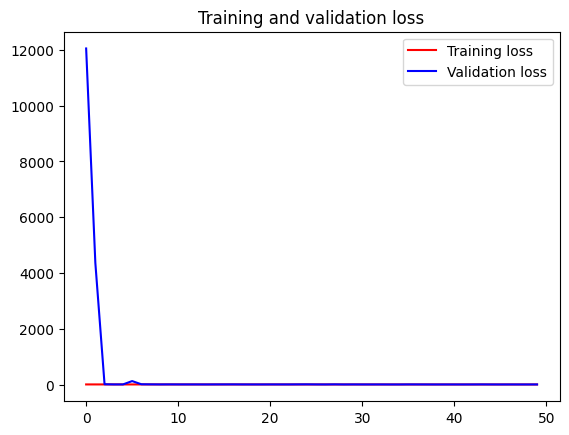

In [6]:
# test run, with cpu

# train_ds, val_ds, class_names, num_classes
# with tensorflow.device("/CPU:0"):
def exec_train_ResNet151V2():
    mod_name = "ResNet151V2"
    resnet_mod = create_model__resnetv2(num_classes)
    summary_model(resnet_mod)
    resnet_mod, hist = train_model(
        resnet_mod, model_name=mod_name, 
        train_ds=train_ds, val_ds=val_ds
    )
    view_train_chart(hist)
    os.makedirs("./models/img_clsr",exist_ok=True)
    resnet_mod.save(f"./models/img_clsr/{mod_name}.keras", overwrite=True)

exec_train_ResNet151V2()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 20)             │        20,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,312,508 (130.89 MB)

 Trainable params: 34,278,076 (130.76 MB)

 Non-trainable params: 34,432 (134.50 KB)

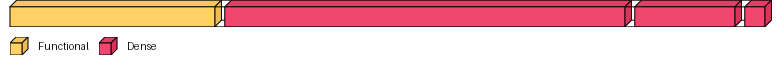

Epoch 1/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 40:44 24s/step - acc: 0.0938 - loss: 3.0371

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.0781 - loss: 4.6948  

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.0660 - loss: 4.9534

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.0612 - loss: 4.9316

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.0565 - loss: 4.8478

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.0549 - loss: 4.7486

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.0534 - loss: 4.6527

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.0536 - loss: 4.5654

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.0538 - loss: 4.4841

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.0537 - loss: 4.4123

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.0540 - loss: 4.3492

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.0543 - loss: 4.2938

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.0548 - loss: 4.2431

 14/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.0552 - loss: 4.1980

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.0556 - loss: 4.1571

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.0559 - loss: 4.1190

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.0562 - loss: 4.0836

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.0564 - loss: 4.0509

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.0563 - loss: 4.0203

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.0563 - loss: 3.9919

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.0562 - loss: 3.9651

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.0563 - loss: 3.9399

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.0567 - loss: 3.9160

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.0570 - loss: 3.8935

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.0573 - loss: 3.8721

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.0575 - loss: 3.8521

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.0577 - loss: 3.8328

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.0580 - loss: 3.8145

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.0584 - loss: 3.7971

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.0586 - loss: 3.7804

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.0588 - loss: 3.7646

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.0591 - loss: 3.7497

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.0592 - loss: 3.7355

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.0594 - loss: 3.7219

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.0595 - loss: 3.7088

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.0597 - loss: 3.6962

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.0599 - loss: 3.6841

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.0600 - loss: 3.6724

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.0600 - loss: 3.6612

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.0601 - loss: 3.6504

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.0602 - loss: 3.6400

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.0604 - loss: 3.6299

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.0605 - loss: 3.6201

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.0606 - loss: 3.6107

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.0607 - loss: 3.6016

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.0607 - loss: 3.5928

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.0608 - loss: 3.5843

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.0609 - loss: 3.5761

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.0610 - loss: 3.5681

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.0610 - loss: 3.5604

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.0610 - loss: 3.5528

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.0610 - loss: 3.5455

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.0611 - loss: 3.5384

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.0611 - loss: 3.5315

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.0611 - loss: 3.5248

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.0611 - loss: 3.5183

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.0611 - loss: 3.5119

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.0611 - loss: 3.5057

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.0611 - loss: 3.4996

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.0611 - loss: 3.4937

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.0611 - loss: 3.4879

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.0611 - loss: 3.4823

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.0611 - loss: 3.4768

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.0611 - loss: 3.4714

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.0610 - loss: 3.4662

2024-05-08 21:35:41.959260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 21:35:51.152155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - acc: 0.0606 - loss: 3.3306 - val_acc: 0.0512 - val_loss: 100.1161


Epoch 2/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 7s/step - acc: 0.0312 - loss: 2.9565

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.0312 - loss: 2.9863 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.0347 - loss: 2.9897

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.0397 - loss: 2.9906

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.0455 - loss: 2.9905

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.0501 - loss: 2.9887

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.0525 - loss: 2.9864

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.0537 - loss: 2.9847

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.0559 - loss: 2.9826

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.0575 - loss: 2.9808

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.0587 - loss: 2.9799

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.0595 - loss: 2.9791

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.0604 - loss: 2.9780

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.0615 - loss: 2.9768

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.0627 - loss: 2.9753

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.0639 - loss: 2.9736

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.0650 - loss: 2.9719

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.0660 - loss: 2.9705

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.0672 - loss: 2.9687

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.0684 - loss: 2.9666

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.0695 - loss: 2.9645

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.0703 - loss: 2.9628

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.0710 - loss: 2.9613

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.0717 - loss: 2.9597

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.0723 - loss: 2.9582

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.0730 - loss: 2.9566

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.0738 - loss: 2.9550

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.0746 - loss: 2.9533

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.0755 - loss: 2.9516

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.0763 - loss: 2.9497

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.0770 - loss: 2.9480

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.0777 - loss: 2.9464

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.0784 - loss: 2.9451

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.0791 - loss: 2.9438

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.0797 - loss: 2.9425

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.0804 - loss: 2.9411

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.0811 - loss: 2.9398

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.0817 - loss: 2.9386

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.0824 - loss: 2.9374

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.0830 - loss: 2.9363

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.0836 - loss: 2.9352

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.0841 - loss: 2.9342

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.0846 - loss: 2.9333

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.0851 - loss: 2.9323

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.0855 - loss: 2.9313

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.0860 - loss: 2.9304

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.0865 - loss: 2.9294

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.0869 - loss: 2.9285

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.0874 - loss: 2.9275

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.0878 - loss: 2.9266

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.0882 - loss: 2.9257

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.0886 - loss: 2.9248

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.0890 - loss: 2.9240

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.0893 - loss: 2.9232

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.0897 - loss: 2.9225

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.0900 - loss: 2.9217

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.0902 - loss: 2.9210

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.0906 - loss: 2.9203

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.0909 - loss: 2.9196

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.0912 - loss: 2.9190

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.0915 - loss: 2.9183

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.0918 - loss: 2.9177

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.0920 - loss: 2.9172

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.0923 - loss: 2.9166

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.0925 - loss: 2.9160

2024-05-08 21:38:15.679617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 21:38:23.697609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.0978 - loss: 2.8877 - val_acc: 0.0531 - val_loss: 5.9921


Epoch 3/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 7s/step - acc: 0.0625 - loss: 2.7300

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.0859 - loss: 2.7381 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.0920 - loss: 2.7335

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.0964 - loss: 2.7285

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.0971 - loss: 2.7293

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.0965 - loss: 2.7324

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.0968 - loss: 2.7330

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.0993 - loss: 2.7328

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.1014 - loss: 2.7308

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.1031 - loss: 2.7291

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.1049 - loss: 2.7282

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.1061 - loss: 2.7272

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.1076 - loss: 2.7259

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.1085 - loss: 2.7256

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.1088 - loss: 2.7258

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.1088 - loss: 2.7260

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.1089 - loss: 2.7262

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.1090 - loss: 2.7260

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.1089 - loss: 2.7261

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.1089 - loss: 2.7263

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.1088 - loss: 2.7264

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.1088 - loss: 2.7266

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.1088 - loss: 2.7268

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.1090 - loss: 2.7269

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.1090 - loss: 2.7272

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.1089 - loss: 2.7277

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.1089 - loss: 2.7286

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.1089 - loss: 2.7292

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.1087 - loss: 2.7298

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.1085 - loss: 2.7301

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.1084 - loss: 2.7304

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.1084 - loss: 2.7305

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.1085 - loss: 2.7305

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.1086 - loss: 2.7303

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.1088 - loss: 2.7300

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.1089 - loss: 2.7294

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.1090 - loss: 2.7291

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.1091 - loss: 2.7288

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.1091 - loss: 2.7282

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.1092 - loss: 2.7277

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.1092 - loss: 2.7273

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.1092 - loss: 2.7271

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.1092 - loss: 2.7268

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.1092 - loss: 2.7266

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.1093 - loss: 2.7263

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.1093 - loss: 2.7258

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.1094 - loss: 2.7255

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.1094 - loss: 2.7251

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.1094 - loss: 2.7247

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.1095 - loss: 2.7243

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.1096 - loss: 2.7239

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.1097 - loss: 2.7234

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.1098 - loss: 2.7229

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.1099 - loss: 2.7224

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.1101 - loss: 2.7218

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.1102 - loss: 2.7213

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.1104 - loss: 2.7207

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.1105 - loss: 2.7202

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.1106 - loss: 2.7197

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.1107 - loss: 2.7193

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.1108 - loss: 2.7188

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.1109 - loss: 2.7185

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.1110 - loss: 2.7181

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.1110 - loss: 2.7178

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.1111 - loss: 2.7175

2024-05-08 21:40:47.806453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.1128 - loss: 2.6952 - val_acc: 0.0472 - val_loss: 1034.9873


Epoch 4/50


2024-05-08 21:40:55.733058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 7s/step - acc: 0.0000e+00 - loss: 2.8590

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.0312 - loss: 2.8174     

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.0486 - loss: 2.8025

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.0579 - loss: 2.8014

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.0701 - loss: 2.7881

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.0758 - loss: 2.7815

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.0783 - loss: 2.7789

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.0812 - loss: 2.7742

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.0838 - loss: 2.7696

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.0864 - loss: 2.7665

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.0883 - loss: 2.7625

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.0899 - loss: 2.7583

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.0911 - loss: 2.7549

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.0922 - loss: 2.7513

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.0929 - loss: 2.7481

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.0934 - loss: 2.7451

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.0939 - loss: 2.7422

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.0943 - loss: 2.7393

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.0945 - loss: 2.7372

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.0946 - loss: 2.7353

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.0947 - loss: 2.7336

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.0949 - loss: 2.7323

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.0950 - loss: 2.7308

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.0952 - loss: 2.7294

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.0955 - loss: 2.7279

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.0958 - loss: 2.7265

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.0962 - loss: 2.7248

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.0965 - loss: 2.7231

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.0968 - loss: 2.7214

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.0970 - loss: 2.7199

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.0971 - loss: 2.7185

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.0973 - loss: 2.7170

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.0975 - loss: 2.7156

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.0977 - loss: 2.7144

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.0978 - loss: 2.7132

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.0979 - loss: 2.7124

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.0981 - loss: 2.7116

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.0982 - loss: 2.7108

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.0983 - loss: 2.7102

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.0984 - loss: 2.7095

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.0985 - loss: 2.7088

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.0986 - loss: 2.7082

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.0987 - loss: 2.7075

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.0988 - loss: 2.7068

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.0990 - loss: 2.7062

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.0992 - loss: 2.7056

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.0994 - loss: 2.7051

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.0996 - loss: 2.7044

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.0998 - loss: 2.7037

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.1000 - loss: 2.7031

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.1002 - loss: 2.7024

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.1004 - loss: 2.7017

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.1006 - loss: 2.7010

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.1008 - loss: 2.7003

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.1010 - loss: 2.6995

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.1012 - loss: 2.6988

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.1013 - loss: 2.6981

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.1015 - loss: 2.6974

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.1017 - loss: 2.6966

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.1018 - loss: 2.6958

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.1020 - loss: 2.6951

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.1021 - loss: 2.6943

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.1023 - loss: 2.6936

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.1025 - loss: 2.6928

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.1027 - loss: 2.6920

2024-05-08 21:43:19.889960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.1067 - loss: 2.6606 - val_acc: 0.0492 - val_loss: 271.7366


Epoch 5/50


2024-05-08 21:43:27.879820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 7s/step - acc: 0.1562 - loss: 2.4847

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.1250 - loss: 2.5062 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.1285 - loss: 2.4823

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.1276 - loss: 2.4807

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.1283 - loss: 2.4718

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.1260 - loss: 2.4688

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.1272 - loss: 2.4696

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.1284 - loss: 2.4702

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.1291 - loss: 2.4684

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.1290 - loss: 2.4688

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.1292 - loss: 2.4695

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.1291 - loss: 2.4715

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.1289 - loss: 2.4739

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.1291 - loss: 2.4759

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.1294 - loss: 2.4774

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.1296 - loss: 2.4791

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.1297 - loss: 2.4807

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.1297 - loss: 2.4816

 19/101 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - acc: 0.1299 - loss: 2.4822

 20/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - acc: 0.1302 - loss: 2.4834

 21/101 ━━━━━━━━━━━━━━━━━━━━ 4:53 4s/step - acc: 0.1309 - loss: 2.4840

 22/101 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - acc: 0.1315 - loss: 2.4845

 23/101 ━━━━━━━━━━━━━━━━━━━━ 4:34 4s/step - acc: 0.1322 - loss: 2.4846

 24/101 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - acc: 0.1328 - loss: 2.4849

 25/101 ━━━━━━━━━━━━━━━━━━━━ 4:18 3s/step - acc: 0.1332 - loss: 2.4850

 26/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 3s/step - acc: 0.1337 - loss: 2.4850

 27/101 ━━━━━━━━━━━━━━━━━━━━ 4:04 3s/step - acc: 0.1340 - loss: 2.4849

 28/101 ━━━━━━━━━━━━━━━━━━━━ 3:57 3s/step - acc: 0.1343 - loss: 2.4847

 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - acc: 0.1348 - loss: 2.4842

 30/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 3s/step - acc: 0.1353 - loss: 2.4839

 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:40 3s/step - acc: 0.1357 - loss: 2.4836

 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 3s/step - acc: 0.1362 - loss: 2.4834

 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 3s/step - acc: 0.1366 - loss: 2.4832

 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - acc: 0.1370 - loss: 2.4828

 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - acc: 0.1374 - loss: 2.4825

 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - acc: 0.1377 - loss: 2.4820

 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - acc: 0.1380 - loss: 2.4817

 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 3s/step - acc: 0.1383 - loss: 2.4814

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 3s/step - acc: 0.1385 - loss: 2.4810

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 3s/step - acc: 0.1388 - loss: 2.4806

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - acc: 0.1391 - loss: 2.4800

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - acc: 0.1395 - loss: 2.4793

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - acc: 0.1399 - loss: 2.4787

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - acc: 0.1402 - loss: 2.4780

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - acc: 0.1406 - loss: 2.4773

 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - acc: 0.1410 - loss: 2.4766

 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - acc: 0.1414 - loss: 2.4760

 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - acc: 0.1417 - loss: 2.4754

 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - acc: 0.1421 - loss: 2.4748

 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 3s/step - acc: 0.1424 - loss: 2.4742

 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - acc: 0.1428 - loss: 2.4736

 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 3s/step - acc: 0.1431 - loss: 2.4730

 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - acc: 0.1434 - loss: 2.4725

 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - acc: 0.1436 - loss: 2.4720

 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.1439 - loss: 2.4715

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - acc: 0.1442 - loss: 2.4710

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - acc: 0.1445 - loss: 2.4705

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - acc: 0.1448 - loss: 2.4700

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - acc: 0.1452 - loss: 2.4694

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 3s/step - acc: 0.1454 - loss: 2.4689

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 3s/step - acc: 0.1457 - loss: 2.4684

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 3s/step - acc: 0.1460 - loss: 2.4679

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 3s/step - acc: 0.1463 - loss: 2.4674

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 3s/step - acc: 0.1466 - loss: 2.4668

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 3s/step - acc: 0.1469 - loss: 2.4663

2024-05-08 21:46:20.610487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - acc: 0.1537 - loss: 2.4412 - val_acc: 0.0650 - val_loss: 18.4085


Epoch 6/50


2024-05-08 21:46:28.735985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 7s/step - acc: 0.1562 - loss: 2.5407

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.1484 - loss: 2.5325 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.1441 - loss: 2.5261

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.1432 - loss: 2.5149

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.1471 - loss: 2.5043

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.1530 - loss: 2.4925

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.1579 - loss: 2.4794

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.1631 - loss: 2.4634

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.1669 - loss: 2.4506

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.1693 - loss: 2.4399

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.1704 - loss: 2.4328

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.1716 - loss: 2.4255

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.1723 - loss: 2.4209

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.1729 - loss: 2.4170

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.1733 - loss: 2.4134

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.1737 - loss: 2.4101

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.1737 - loss: 2.4077

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.1739 - loss: 2.4052

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.1739 - loss: 2.4027

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.1741 - loss: 2.4000

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.1742 - loss: 2.3979

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.1745 - loss: 2.3958

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.1748 - loss: 2.3936

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.1751 - loss: 2.3915

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.1755 - loss: 2.3889

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.1760 - loss: 2.3857

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.1767 - loss: 2.3825

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.1771 - loss: 2.3797

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.1775 - loss: 2.3773

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.1779 - loss: 2.3751

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.1782 - loss: 2.3735

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.1785 - loss: 2.3721

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.1789 - loss: 2.3711

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.1791 - loss: 2.3704

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.1793 - loss: 2.3700

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.1796 - loss: 2.3696

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.1798 - loss: 2.3692

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.1799 - loss: 2.3689

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.1800 - loss: 2.3686

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.1801 - loss: 2.3684

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.1802 - loss: 2.3681

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.1803 - loss: 2.3680

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.1804 - loss: 2.3680

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.1804 - loss: 2.3678

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.1806 - loss: 2.3678

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.1808 - loss: 2.3676

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.1810 - loss: 2.3673

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.1812 - loss: 2.3671

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.1815 - loss: 2.3667

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.1818 - loss: 2.3663

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.1820 - loss: 2.3660

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.1822 - loss: 2.3657

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.1824 - loss: 2.3653

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.1826 - loss: 2.3649

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.1828 - loss: 2.3645

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.1831 - loss: 2.3641

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.1832 - loss: 2.3638

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.1835 - loss: 2.3635

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.1837 - loss: 2.3632

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.1839 - loss: 2.3628

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.1842 - loss: 2.3625

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.1844 - loss: 2.3622

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.1846 - loss: 2.3618

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.1848 - loss: 2.3615

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.1850 - loss: 2.3612

2024-05-08 21:48:52.323822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 21:49:00.292276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.1893 - loss: 2.3428 - val_acc: 0.1319 - val_loss: 4.0309


Epoch 7/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 7s/step - acc: 0.1875 - loss: 2.8131

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.2031 - loss: 2.6429 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.2014 - loss: 2.5852

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.1999 - loss: 2.5719

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.2036 - loss: 2.5501

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.2018 - loss: 2.5381

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.2017 - loss: 2.5230

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.2014 - loss: 2.5104

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.2010 - loss: 2.4979

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.2012 - loss: 2.4851

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.2013 - loss: 2.4729

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.2010 - loss: 2.4620

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.2003 - loss: 2.4550

 14/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.1997 - loss: 2.4511

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.1988 - loss: 2.4471

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.1985 - loss: 2.4435

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.1983 - loss: 2.4406

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.1981 - loss: 2.4376

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.1980 - loss: 2.4353

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.1981 - loss: 2.4330

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.1983 - loss: 2.4305

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.1984 - loss: 2.4281

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.1986 - loss: 2.4256

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.1989 - loss: 2.4231

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.1992 - loss: 2.4208

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.1994 - loss: 2.4185

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.1996 - loss: 2.4160

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.1998 - loss: 2.4134

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.2000 - loss: 2.4108

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.2001 - loss: 2.4085

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.2004 - loss: 2.4061

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.2007 - loss: 2.4040

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.2009 - loss: 2.4021

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.2011 - loss: 2.4002

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.2012 - loss: 2.3983

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.2014 - loss: 2.3963

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.2015 - loss: 2.3944

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.2015 - loss: 2.3926

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.2016 - loss: 2.3909

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.2016 - loss: 2.3892

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.2017 - loss: 2.3876

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.2017 - loss: 2.3862

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.2018 - loss: 2.3846

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.2018 - loss: 2.3830

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.2019 - loss: 2.3813

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.2019 - loss: 2.3796

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.2021 - loss: 2.3781

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.2022 - loss: 2.3766

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.2024 - loss: 2.3752

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.2026 - loss: 2.3737

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.2028 - loss: 2.3723

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.2030 - loss: 2.3708

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.2032 - loss: 2.3695

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.2034 - loss: 2.3681

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.2036 - loss: 2.3668

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.2038 - loss: 2.3655

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.2040 - loss: 2.3642

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.2042 - loss: 2.3629

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.2044 - loss: 2.3618

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.2046 - loss: 2.3607

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.2047 - loss: 2.3595

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.2050 - loss: 2.3583

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.2052 - loss: 2.3571

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.2054 - loss: 2.3559

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.2056 - loss: 2.3547

2024-05-08 21:51:24.632803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.2105 - loss: 2.3163 - val_acc: 0.2067 - val_loss: 4.1499


Epoch 8/50


2024-05-08 21:51:32.569200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 7s/step - acc: 0.2812 - loss: 1.9453

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.2734 - loss: 1.9973 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.2760 - loss: 2.0226

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.2773 - loss: 2.0331

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.2781 - loss: 2.0552

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.2795 - loss: 2.0725

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.2823 - loss: 2.0834

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.2851 - loss: 2.0878

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.2870 - loss: 2.0913

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.2877 - loss: 2.0929

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.2886 - loss: 2.0916

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.2885 - loss: 2.0911

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.2879 - loss: 2.0919

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.2869 - loss: 2.0932

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.2859 - loss: 2.0958

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.2851 - loss: 2.0973

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.2839 - loss: 2.1005

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.2829 - loss: 2.1041

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.2819 - loss: 2.1075

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.2809 - loss: 2.1115

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.2797 - loss: 2.1156

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.2785 - loss: 2.1198

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.2773 - loss: 2.1239

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.2762 - loss: 2.1282

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.2749 - loss: 2.1323

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.2738 - loss: 2.1360

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.2728 - loss: 2.1393

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.2717 - loss: 2.1429

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.2707 - loss: 2.1459

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.2700 - loss: 2.1487

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.2692 - loss: 2.1512

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.2685 - loss: 2.1535

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.2678 - loss: 2.1557

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.2671 - loss: 2.1576

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.2666 - loss: 2.1593

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.2661 - loss: 2.1605

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.2657 - loss: 2.1618

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.2654 - loss: 2.1628

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.2651 - loss: 2.1636

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.2649 - loss: 2.1643

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.2647 - loss: 2.1648

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.2643 - loss: 2.1657

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.2640 - loss: 2.1665

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.2636 - loss: 2.1675

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.2633 - loss: 2.1683

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.2631 - loss: 2.1689

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.2629 - loss: 2.1695

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.2627 - loss: 2.1701

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.2625 - loss: 2.1706

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.2624 - loss: 2.1710

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.2622 - loss: 2.1715

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.2620 - loss: 2.1719

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.2618 - loss: 2.1724

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.2616 - loss: 2.1728

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.2615 - loss: 2.1730

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.2614 - loss: 2.1732

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.2613 - loss: 2.1733

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.2612 - loss: 2.1734

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.2610 - loss: 2.1737

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.2608 - loss: 2.1740

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.2606 - loss: 2.1745

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.2605 - loss: 2.1748

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.2603 - loss: 2.1753

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.2601 - loss: 2.1758

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.2599 - loss: 2.1762

2024-05-08 21:53:56.539685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 21:54:04.470771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.2558 - loss: 2.1748 - val_acc: 0.1988 - val_loss: 3.6947


Epoch 9/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 7s/step - acc: 0.2812 - loss: 2.0966

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.2500 - loss: 2.1184 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.2431 - loss: 2.1360

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.2409 - loss: 2.1469

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.2427 - loss: 2.1558

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.2483 - loss: 2.1599

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.2498 - loss: 2.1683

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.2503 - loss: 2.1764

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.2518 - loss: 2.1815

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.2526 - loss: 2.1846

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.2521 - loss: 2.1893

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.2517 - loss: 2.1916

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.2512 - loss: 2.1925

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.2509 - loss: 2.1923

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.2507 - loss: 2.1915

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.2513 - loss: 2.1923

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.2520 - loss: 2.1924

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.2526 - loss: 2.1926

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.2531 - loss: 2.1933

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.2536 - loss: 2.1931

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.2543 - loss: 2.1929

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.2552 - loss: 2.1920

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.2560 - loss: 2.1915

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.2565 - loss: 2.1910

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.2568 - loss: 2.1907

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.2572 - loss: 2.1902

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.2578 - loss: 2.1894

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.2585 - loss: 2.1885

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.2592 - loss: 2.1874

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.2599 - loss: 2.1863

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.2604 - loss: 2.1850

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.2610 - loss: 2.1834

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.2617 - loss: 2.1817

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.2622 - loss: 2.1802

 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 3s/step - acc: 0.2628 - loss: 2.1789

 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - acc: 0.2634 - loss: 2.1776

 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - acc: 0.2639 - loss: 2.1764

 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - acc: 0.2644 - loss: 2.1754

 39/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - acc: 0.2649 - loss: 2.1741

 40/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - acc: 0.2654 - loss: 2.1729

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 3s/step - acc: 0.2659 - loss: 2.1715

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - acc: 0.2664 - loss: 2.1702

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 3s/step - acc: 0.2668 - loss: 2.1688

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 3s/step - acc: 0.2673 - loss: 2.1674

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - acc: 0.2678 - loss: 2.1660

 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - acc: 0.2683 - loss: 2.1647

 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - acc: 0.2688 - loss: 2.1635

 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - acc: 0.2692 - loss: 2.1624

 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - acc: 0.2696 - loss: 2.1612

 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - acc: 0.2700 - loss: 2.1600

 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.2705 - loss: 2.1588

 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 3s/step - acc: 0.2710 - loss: 2.1575

 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - acc: 0.2715 - loss: 2.1561

 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 3s/step - acc: 0.2720 - loss: 2.1548

 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/step - acc: 0.2724 - loss: 2.1536

 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 3s/step - acc: 0.2729 - loss: 2.1522

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - acc: 0.2734 - loss: 2.1510

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - acc: 0.2739 - loss: 2.1498

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - acc: 0.2743 - loss: 2.1487

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - acc: 0.2747 - loss: 2.1476

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - acc: 0.2750 - loss: 2.1465

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - acc: 0.2753 - loss: 2.1455

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 3s/step - acc: 0.2757 - loss: 2.1444

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - acc: 0.2760 - loss: 2.1433

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 3s/step - acc: 0.2764 - loss: 2.1422

2024-05-08 21:56:59.237973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 21:57:07.201083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - acc: 0.2846 - loss: 2.1051 - val_acc: 0.2539 - val_loss: 3.5432


Epoch 10/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 7s/step - acc: 0.2812 - loss: 1.7444

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.2891 - loss: 1.7895 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.2934 - loss: 1.8586

  4/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.2912 - loss: 1.9268

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.2925 - loss: 1.9628

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.2948 - loss: 1.9834

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.2952 - loss: 1.9953

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.2957 - loss: 2.0077

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.2972 - loss: 2.0140

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.2997 - loss: 2.0171

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.3016 - loss: 2.0213

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.3035 - loss: 2.0238

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.3049 - loss: 2.0245

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.3059 - loss: 2.0261

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.3078 - loss: 2.0249

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.3090 - loss: 2.0247

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.3105 - loss: 2.0231

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.3117 - loss: 2.0217

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.3127 - loss: 2.0203

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.3137 - loss: 2.0183

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.3144 - loss: 2.0165

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.3151 - loss: 2.0146

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.3160 - loss: 2.0125

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.3167 - loss: 2.0104

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.3170 - loss: 2.0094

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.3174 - loss: 2.0080

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.3176 - loss: 2.0068

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.3178 - loss: 2.0056

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.3180 - loss: 2.0042

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.3181 - loss: 2.0033

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.3182 - loss: 2.0021

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.3182 - loss: 2.0014

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.3182 - loss: 2.0006

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.3182 - loss: 2.0000

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.3182 - loss: 1.9991

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.3184 - loss: 1.9980

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.3184 - loss: 1.9969

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3185 - loss: 1.9958

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3185 - loss: 1.9949

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3185 - loss: 1.9941

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3184 - loss: 1.9934

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3183 - loss: 1.9927

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3183 - loss: 1.9920

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.3182 - loss: 1.9911

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.3182 - loss: 1.9902

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.3181 - loss: 1.9893

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.3181 - loss: 1.9885

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.3181 - loss: 1.9875

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3181 - loss: 1.9864

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.3181 - loss: 1.9856

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.3181 - loss: 1.9849

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.3181 - loss: 1.9842

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.3180 - loss: 1.9836

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.3180 - loss: 1.9831

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.3179 - loss: 1.9825

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.3178 - loss: 1.9821

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.3177 - loss: 1.9817

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.3177 - loss: 1.9812

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.3176 - loss: 1.9808

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.3176 - loss: 1.9804

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3175 - loss: 1.9800

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3175 - loss: 1.9796

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.3175 - loss: 1.9792

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.3174 - loss: 1.9788

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.3174 - loss: 1.9785

2024-05-08 21:59:31.287909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.3172 - loss: 1.9589 - val_acc: 0.1181 - val_loss: 5.2674


Epoch 11/50


2024-05-08 21:59:39.239349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 8s/step - acc: 0.3125 - loss: 1.9586

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.2969 - loss: 1.9381 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.3056 - loss: 1.8964

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.3053 - loss: 1.8779

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.3068 - loss: 1.8629

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.3034 - loss: 1.8627

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.3053 - loss: 1.8568

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.3077 - loss: 1.8529

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.3086 - loss: 1.8554

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.3093 - loss: 1.8597

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.3088 - loss: 1.8664

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.3081 - loss: 1.8718

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.3073 - loss: 1.8772

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.3070 - loss: 1.8816

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.3072 - loss: 1.8837

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.3072 - loss: 1.8852

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.3074 - loss: 1.8856

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.3077 - loss: 1.8855

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.3082 - loss: 1.8855

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.3088 - loss: 1.8852

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.3094 - loss: 1.8847

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.3101 - loss: 1.8841

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.3109 - loss: 1.8837

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.3116 - loss: 1.8835

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.3123 - loss: 1.8835

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.3129 - loss: 1.8832

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.3134 - loss: 1.8831

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.3137 - loss: 1.8832

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.3140 - loss: 1.8835

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.3143 - loss: 1.8837

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.3146 - loss: 1.8840

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.3150 - loss: 1.8840

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.3154 - loss: 1.8840

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.3160 - loss: 1.8839

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.3163 - loss: 1.8840

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.3166 - loss: 1.8844

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.3170 - loss: 1.8848

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3174 - loss: 1.8850

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3177 - loss: 1.8856

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3180 - loss: 1.8860

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3183 - loss: 1.8865

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3185 - loss: 1.8872

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3187 - loss: 1.8880

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.3188 - loss: 1.8887

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.3190 - loss: 1.8893

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.3192 - loss: 1.8899

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.3194 - loss: 1.8904

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.3197 - loss: 1.8909

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3199 - loss: 1.8914

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.3202 - loss: 1.8919

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.3205 - loss: 1.8925

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.3208 - loss: 1.8930

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.3211 - loss: 1.8935

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.3214 - loss: 1.8940

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.3218 - loss: 1.8944

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.3221 - loss: 1.8947

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.3224 - loss: 1.8951

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.3227 - loss: 1.8955

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.3229 - loss: 1.8958

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.3233 - loss: 1.8960

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3236 - loss: 1.8962

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3239 - loss: 1.8964

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3242 - loss: 1.8965

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.3246 - loss: 1.8967

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.3249 - loss: 1.8968

2024-05-08 22:02:03.331296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.3331 - loss: 1.8892 - val_acc: 0.2224 - val_loss: 3.5942


Epoch 12/50


2024-05-08 22:02:11.406718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 7s/step - acc: 0.2500 - loss: 2.1559

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.3125 - loss: 1.9832 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.3264 - loss: 1.9055

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.3366 - loss: 1.8705

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.3393 - loss: 1.8757

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.3444 - loss: 1.8731

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.3487 - loss: 1.8670

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.3520 - loss: 1.8593

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.3546 - loss: 1.8548

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.3566 - loss: 1.8488

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.3583 - loss: 1.8454

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.3599 - loss: 1.8429

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.3612 - loss: 1.8412

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.3617 - loss: 1.8408

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.3622 - loss: 1.8407

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.3625 - loss: 1.8409

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.3626 - loss: 1.8417

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.3627 - loss: 1.8425

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.3631 - loss: 1.8430

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.3635 - loss: 1.8437

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.3638 - loss: 1.8441

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.3644 - loss: 1.8440

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.3648 - loss: 1.8434

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.3651 - loss: 1.8432

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.3656 - loss: 1.8425

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.3660 - loss: 1.8423

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.3666 - loss: 1.8417

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.3673 - loss: 1.8407

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.3677 - loss: 1.8400

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.3682 - loss: 1.8390

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.3685 - loss: 1.8389

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.3688 - loss: 1.8389

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.3691 - loss: 1.8390

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.3693 - loss: 1.8393

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.3695 - loss: 1.8395

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.3695 - loss: 1.8397

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.3696 - loss: 1.8397

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3696 - loss: 1.8399

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3697 - loss: 1.8400

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3697 - loss: 1.8401

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3697 - loss: 1.8402

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3698 - loss: 1.8403

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3698 - loss: 1.8403

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.3698 - loss: 1.8403

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.3698 - loss: 1.8402

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.3697 - loss: 1.8401

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.3697 - loss: 1.8399

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.3697 - loss: 1.8396

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3698 - loss: 1.8391

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.3698 - loss: 1.8387

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.3699 - loss: 1.8381

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.3700 - loss: 1.8373

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.3701 - loss: 1.8365

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.3703 - loss: 1.8357

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.3705 - loss: 1.8347

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.3707 - loss: 1.8337

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.3709 - loss: 1.8327

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.3712 - loss: 1.8318

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.3714 - loss: 1.8309

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.3717 - loss: 1.8300

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3720 - loss: 1.8291

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3723 - loss: 1.8282

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3726 - loss: 1.8272

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.3728 - loss: 1.8263

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.3730 - loss: 1.8254

2024-05-08 22:04:35.286056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 22:04:43.214211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.3781 - loss: 1.7964 - val_acc: 0.3169 - val_loss: 2.6038


Epoch 13/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 7s/step - acc: 0.3125 - loss: 1.9650

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.3125 - loss: 1.9155 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.3090 - loss: 1.8822

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.3177 - loss: 1.8495

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.3242 - loss: 1.8320

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.3266 - loss: 1.8230

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.3284 - loss: 1.8175

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.3283 - loss: 1.8160

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.3304 - loss: 1.8109

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.3324 - loss: 1.8080

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.3345 - loss: 1.8058

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.3350 - loss: 1.8064

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.3350 - loss: 1.8089

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.3349 - loss: 1.8121

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.3353 - loss: 1.8140

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.3363 - loss: 1.8139

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.3378 - loss: 1.8137

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.3395 - loss: 1.8128

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.3410 - loss: 1.8117

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.3425 - loss: 1.8106

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.3444 - loss: 1.8089

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.3459 - loss: 1.8075

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.3473 - loss: 1.8061

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.3485 - loss: 1.8048

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.3496 - loss: 1.8033

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.3509 - loss: 1.8016

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.3521 - loss: 1.8000

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.3531 - loss: 1.7987

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.3539 - loss: 1.7977

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.3546 - loss: 1.7967

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.3555 - loss: 1.7956

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.3562 - loss: 1.7945

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.3570 - loss: 1.7929

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.3578 - loss: 1.7913

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.3585 - loss: 1.7898

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.3591 - loss: 1.7887

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.3596 - loss: 1.7877

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3601 - loss: 1.7867

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3607 - loss: 1.7856

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3613 - loss: 1.7846

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3617 - loss: 1.7837

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3622 - loss: 1.7827

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3626 - loss: 1.7819

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.3630 - loss: 1.7811

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.3633 - loss: 1.7803

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.3637 - loss: 1.7797

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.3642 - loss: 1.7789

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.3646 - loss: 1.7780

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3651 - loss: 1.7772

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.3655 - loss: 1.7763

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.3660 - loss: 1.7754

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.3665 - loss: 1.7745

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.3670 - loss: 1.7736

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.3675 - loss: 1.7728

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.3679 - loss: 1.7719

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.3684 - loss: 1.7709

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.3689 - loss: 1.7700

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.3694 - loss: 1.7690

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.3699 - loss: 1.7681

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.3704 - loss: 1.7672

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3708 - loss: 1.7664

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3713 - loss: 1.7657

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3717 - loss: 1.7649

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.3721 - loss: 1.7642

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.3725 - loss: 1.7635

2024-05-08 22:07:07.507326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.3819 - loss: 1.7384 - val_acc: 0.2972 - val_loss: 2.6582


Epoch 14/50


2024-05-08 22:07:15.478082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 8s/step - acc: 0.4062 - loss: 1.5832

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.4453 - loss: 1.5439 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4462 - loss: 1.5486

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.4440 - loss: 1.5623

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4390 - loss: 1.5777

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4344 - loss: 1.5837

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4342 - loss: 1.5864

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.4361 - loss: 1.5881

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4374 - loss: 1.5890

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.4393 - loss: 1.5883

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.4414 - loss: 1.5856

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.4439 - loss: 1.5809

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.4449 - loss: 1.5794

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.4458 - loss: 1.5781

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4469 - loss: 1.5765

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4479 - loss: 1.5751

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4484 - loss: 1.5742

 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.4489 - loss: 1.5733

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4492 - loss: 1.5726

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4496 - loss: 1.5721

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.4497 - loss: 1.5722

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.4495 - loss: 1.5732

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4491 - loss: 1.5743

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4489 - loss: 1.5753

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4485 - loss: 1.5762

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4483 - loss: 1.5771

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4480 - loss: 1.5785

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4477 - loss: 1.5801

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4472 - loss: 1.5815

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4468 - loss: 1.5828

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4464 - loss: 1.5839

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4460 - loss: 1.5850

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.4457 - loss: 1.5858

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.4455 - loss: 1.5864

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.4453 - loss: 1.5872

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.4453 - loss: 1.5879

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.4452 - loss: 1.5887

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.4452 - loss: 1.5894

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.4450 - loss: 1.5903

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.4448 - loss: 1.5913

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.4447 - loss: 1.5921

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.4445 - loss: 1.5929

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4443 - loss: 1.5938

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4440 - loss: 1.5947

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.4437 - loss: 1.5958

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.4434 - loss: 1.5970

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.4431 - loss: 1.5980

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.4429 - loss: 1.5990

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.4426 - loss: 1.6001

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.4424 - loss: 1.6011

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4421 - loss: 1.6023

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.4418 - loss: 1.6034

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.4415 - loss: 1.6045

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.4413 - loss: 1.6054

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.4410 - loss: 1.6064

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.4408 - loss: 1.6073

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.4406 - loss: 1.6081

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4404 - loss: 1.6089

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4402 - loss: 1.6097

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4400 - loss: 1.6105

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4398 - loss: 1.6111

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4397 - loss: 1.6118

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4396 - loss: 1.6124

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.4394 - loss: 1.6130

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4393 - loss: 1.6136

2024-05-08 22:09:39.575169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 22:09:47.616621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.4370 - loss: 1.6175 - val_acc: 0.3720 - val_loss: 2.0729


Epoch 15/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 7s/step - acc: 0.5312 - loss: 1.4698

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.4922 - loss: 1.6193 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4774 - loss: 1.6467

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.4714 - loss: 1.6410

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4683 - loss: 1.6402

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4658 - loss: 1.6418

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4681 - loss: 1.6351

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4687 - loss: 1.6349

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4675 - loss: 1.6365

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4664 - loss: 1.6376

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4653 - loss: 1.6374

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.4630 - loss: 1.6399

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4605 - loss: 1.6421

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4590 - loss: 1.6418

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4580 - loss: 1.6397

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4572 - loss: 1.6380

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4566 - loss: 1.6365

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.4559 - loss: 1.6368

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4559 - loss: 1.6364

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4561 - loss: 1.6360

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.4565 - loss: 1.6352

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.4568 - loss: 1.6351

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4572 - loss: 1.6349

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4580 - loss: 1.6338

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4587 - loss: 1.6328

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4592 - loss: 1.6320

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4598 - loss: 1.6310

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4601 - loss: 1.6306

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4603 - loss: 1.6302

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4606 - loss: 1.6296

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4607 - loss: 1.6291

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.4607 - loss: 1.6287

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.4608 - loss: 1.6282

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4608 - loss: 1.6275

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.4610 - loss: 1.6266

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.4610 - loss: 1.6260

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.4611 - loss: 1.6252

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.4612 - loss: 1.6244

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.4614 - loss: 1.6235

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.4616 - loss: 1.6226

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4617 - loss: 1.6219

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4618 - loss: 1.6213

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4619 - loss: 1.6207

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4620 - loss: 1.6203

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.4620 - loss: 1.6203

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.4619 - loss: 1.6203

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.4619 - loss: 1.6203

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.4618 - loss: 1.6203

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.4616 - loss: 1.6205

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.4613 - loss: 1.6208

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4611 - loss: 1.6211

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.4609 - loss: 1.6213

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.4607 - loss: 1.6214

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.4605 - loss: 1.6214

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.4603 - loss: 1.6214

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.4601 - loss: 1.6215

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.4598 - loss: 1.6216

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4596 - loss: 1.6217

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4594 - loss: 1.6219

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4591 - loss: 1.6222

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4588 - loss: 1.6225

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4585 - loss: 1.6230

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4583 - loss: 1.6234

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4581 - loss: 1.6237

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4579 - loss: 1.6240

2024-05-08 22:12:12.239406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.4534 - loss: 1.6212 - val_acc: 0.3661 - val_loss: 2.2036


Epoch 16/50


2024-05-08 22:12:20.287924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 8s/step - acc: 0.6250 - loss: 1.1058

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.5938 - loss: 1.2071 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5764 - loss: 1.2545

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5749 - loss: 1.2682

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5686 - loss: 1.2858

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.5633 - loss: 1.3013

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5593 - loss: 1.3139

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.5549 - loss: 1.3267

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.5499 - loss: 1.3399

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.5449 - loss: 1.3510

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.5393 - loss: 1.3661

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.5351 - loss: 1.3793

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5315 - loss: 1.3913

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5286 - loss: 1.4016

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5253 - loss: 1.4127

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5225 - loss: 1.4230

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.5198 - loss: 1.4327

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5173 - loss: 1.4418

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5151 - loss: 1.4492

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5133 - loss: 1.4551

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5117 - loss: 1.4601

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.5102 - loss: 1.4645

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.5090 - loss: 1.4686

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5079 - loss: 1.4729

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5072 - loss: 1.4766

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5064 - loss: 1.4799

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5057 - loss: 1.4827

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5048 - loss: 1.4857

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5040 - loss: 1.4883

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5033 - loss: 1.4907

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5027 - loss: 1.4928

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5021 - loss: 1.4946

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5015 - loss: 1.4963

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.5010 - loss: 1.4979

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.5005 - loss: 1.4993

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5001 - loss: 1.5005

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4996 - loss: 1.5017

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.4991 - loss: 1.5030

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4986 - loss: 1.5046

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4980 - loss: 1.5061

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.4975 - loss: 1.5074

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.4971 - loss: 1.5084

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.4966 - loss: 1.5096

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.4962 - loss: 1.5108

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.4958 - loss: 1.5118

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4955 - loss: 1.5129

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4952 - loss: 1.5138

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.4950 - loss: 1.5146

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.4948 - loss: 1.5152

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.4948 - loss: 1.5158

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.4946 - loss: 1.5164

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.4944 - loss: 1.5170

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4942 - loss: 1.5178

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4940 - loss: 1.5186

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.4939 - loss: 1.5193

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.4937 - loss: 1.5201

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.4936 - loss: 1.5207

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.4935 - loss: 1.5213

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.4934 - loss: 1.5219

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.4933 - loss: 1.5225

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4932 - loss: 1.5230

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4931 - loss: 1.5236

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.4930 - loss: 1.5242

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.4928 - loss: 1.5248

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4927 - loss: 1.5253

2024-05-08 22:14:44.049449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 22:14:52.019982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.4899 - loss: 1.5283 - val_acc: 0.3878 - val_loss: 1.8326


Epoch 17/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 7s/step - acc: 0.4688 - loss: 1.5179

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.4531 - loss: 1.5961 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4583 - loss: 1.5701

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4629 - loss: 1.5592

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.4678 - loss: 1.5502

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4697 - loss: 1.5430

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4683 - loss: 1.5449

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4679 - loss: 1.5433

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4660 - loss: 1.5413

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4638 - loss: 1.5435

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4622 - loss: 1.5445

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4603 - loss: 1.5451

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4580 - loss: 1.5480

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4570 - loss: 1.5490

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4569 - loss: 1.5496

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4574 - loss: 1.5485

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.4576 - loss: 1.5491

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4580 - loss: 1.5491

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4584 - loss: 1.5490

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.4587 - loss: 1.5491

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.4588 - loss: 1.5493

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.4589 - loss: 1.5494

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.4587 - loss: 1.5502

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.4585 - loss: 1.5509

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4586 - loss: 1.5518

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4585 - loss: 1.5528

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.4586 - loss: 1.5537

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.4587 - loss: 1.5544

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.4588 - loss: 1.5555

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.4589 - loss: 1.5563

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.4591 - loss: 1.5568

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.4593 - loss: 1.5574

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4596 - loss: 1.5578

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4597 - loss: 1.5582

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4599 - loss: 1.5583

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.4601 - loss: 1.5586

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4603 - loss: 1.5589

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4605 - loss: 1.5592

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4608 - loss: 1.5592

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4610 - loss: 1.5590

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4613 - loss: 1.5588

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4616 - loss: 1.5587

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4618 - loss: 1.5587

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4619 - loss: 1.5587

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.4620 - loss: 1.5589

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.4621 - loss: 1.5590

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.4622 - loss: 1.5592

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4623 - loss: 1.5595

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4624 - loss: 1.5597

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4624 - loss: 1.5599

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4625 - loss: 1.5601

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.4625 - loss: 1.5603

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.4625 - loss: 1.5605

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.4625 - loss: 1.5607

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.4625 - loss: 1.5609

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.4625 - loss: 1.5610

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.4625 - loss: 1.5610

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4624 - loss: 1.5611

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4623 - loss: 1.5612

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4622 - loss: 1.5614

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4622 - loss: 1.5615

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4621 - loss: 1.5616

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4620 - loss: 1.5617

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.4620 - loss: 1.5617

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4619 - loss: 1.5617

2024-05-08 22:17:16.336047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.4609 - loss: 1.5532 - val_acc: 0.3445 - val_loss: 2.4568


Epoch 18/50


2024-05-08 22:17:24.290872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 7s/step - acc: 0.4688 - loss: 1.7531

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4375 - loss: 1.7421 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4306 - loss: 1.7421

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4342 - loss: 1.7171

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.4436 - loss: 1.6849

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4487 - loss: 1.6611

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.4554 - loss: 1.6398

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4619 - loss: 1.6220

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4677 - loss: 1.6064

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4731 - loss: 1.5931

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.4784 - loss: 1.5789

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4819 - loss: 1.5690

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4857 - loss: 1.5596

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4903 - loss: 1.5489

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4945 - loss: 1.5390

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4982 - loss: 1.5298

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5013 - loss: 1.5217

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5037 - loss: 1.5150

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5059 - loss: 1.5085

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5077 - loss: 1.5027

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5095 - loss: 1.4972

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.5108 - loss: 1.4929

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.5118 - loss: 1.4893

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.5127 - loss: 1.4858

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5134 - loss: 1.4846

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5143 - loss: 1.4831

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5150 - loss: 1.4814

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5155 - loss: 1.4799

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5160 - loss: 1.4788

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5163 - loss: 1.4779

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5165 - loss: 1.4770

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5166 - loss: 1.4763

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5167 - loss: 1.4765

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.5168 - loss: 1.4765

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5167 - loss: 1.4768

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5165 - loss: 1.4772

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5165 - loss: 1.4775

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5164 - loss: 1.4780

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5163 - loss: 1.4785

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5162 - loss: 1.4790

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5160 - loss: 1.4798

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5157 - loss: 1.4807

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5154 - loss: 1.4815

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5151 - loss: 1.4823

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5147 - loss: 1.4831

 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.5144 - loss: 1.4838

 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.5141 - loss: 1.4843

 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5138 - loss: 1.4850

 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5135 - loss: 1.4856

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5132 - loss: 1.4861

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5130 - loss: 1.4865

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.5128 - loss: 1.4869

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.5127 - loss: 1.4873

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5125 - loss: 1.4879

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5123 - loss: 1.4884

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.5121 - loss: 1.4889

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5119 - loss: 1.4893

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.5118 - loss: 1.4898

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.5117 - loss: 1.4901

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5116 - loss: 1.4905

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5114 - loss: 1.4910

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5113 - loss: 1.4915

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.5112 - loss: 1.4919

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.5110 - loss: 1.4923

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5109 - loss: 1.4926

2024-05-08 22:19:57.279191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - acc: 0.5087 - loss: 1.4916 - val_acc: 0.3642 - val_loss: 1.8852


Epoch 19/50


2024-05-08 22:20:05.204504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 7s/step - acc: 0.7500 - loss: 1.1266

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6953 - loss: 1.2120 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6476 - loss: 1.3048

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6224 - loss: 1.3324

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6054 - loss: 1.3494

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.5939 - loss: 1.3615

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5856 - loss: 1.3696

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5803 - loss: 1.3735

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.5756 - loss: 1.3788

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5721 - loss: 1.3823

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5684 - loss: 1.3878

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.5651 - loss: 1.3919

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5619 - loss: 1.3961

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5589 - loss: 1.4001

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5567 - loss: 1.4032

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5546 - loss: 1.4052

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.5528 - loss: 1.4063

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5509 - loss: 1.4075

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5488 - loss: 1.4092

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5471 - loss: 1.4101

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5453 - loss: 1.4119

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.5434 - loss: 1.4138

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5414 - loss: 1.4159

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5398 - loss: 1.4175

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5383 - loss: 1.4188

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5369 - loss: 1.4199

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5357 - loss: 1.4206

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5348 - loss: 1.4212

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5338 - loss: 1.4218

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5329 - loss: 1.4223

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.5322 - loss: 1.4228

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5314 - loss: 1.4233

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.5307 - loss: 1.4238

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.5301 - loss: 1.4243

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5296 - loss: 1.4248

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5291 - loss: 1.4252

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5285 - loss: 1.4257

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5280 - loss: 1.4263

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5275 - loss: 1.4267

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5269 - loss: 1.4274

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5265 - loss: 1.4277

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5261 - loss: 1.4281

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5258 - loss: 1.4284

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5255 - loss: 1.4286

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5252 - loss: 1.4287

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.5249 - loss: 1.4288

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5246 - loss: 1.4289

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5243 - loss: 1.4289

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5240 - loss: 1.4291

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5236 - loss: 1.4293

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5234 - loss: 1.4292

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5231 - loss: 1.4292

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5229 - loss: 1.4292

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.5226 - loss: 1.4293

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.5223 - loss: 1.4292

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5221 - loss: 1.4293

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5218 - loss: 1.4293

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5217 - loss: 1.4292

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5215 - loss: 1.4292

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5213 - loss: 1.4292

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5211 - loss: 1.4293

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5210 - loss: 1.4293

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.5209 - loss: 1.4292

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5208 - loss: 1.4291

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5207 - loss: 1.4290

2024-05-08 22:22:28.751963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.5186 - loss: 1.4184 - val_acc: 0.3169 - val_loss: 2.7352


Epoch 20/50


2024-05-08 22:22:36.726022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 8s/step - acc: 0.4688 - loss: 1.5335

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.4766 - loss: 1.5413 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.4878 - loss: 1.5003

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.4870 - loss: 1.4942

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4896 - loss: 1.4795

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4931 - loss: 1.4649

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4965 - loss: 1.4615

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5004 - loss: 1.4566

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5030 - loss: 1.4542

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5075 - loss: 1.4473

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5108 - loss: 1.4431

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5143 - loss: 1.4382

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5162 - loss: 1.4343

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5177 - loss: 1.4312

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.5187 - loss: 1.4280

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5191 - loss: 1.4249

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5195 - loss: 1.4215

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5200 - loss: 1.4194

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5204 - loss: 1.4185

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5206 - loss: 1.4174

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5207 - loss: 1.4160

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5209 - loss: 1.4150

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5210 - loss: 1.4140

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5211 - loss: 1.4133

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5212 - loss: 1.4129

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5214 - loss: 1.4125

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5216 - loss: 1.4121

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5218 - loss: 1.4114

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5221 - loss: 1.4107

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5222 - loss: 1.4100

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5224 - loss: 1.4092

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5224 - loss: 1.4092

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5226 - loss: 1.4092

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5227 - loss: 1.4089

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5228 - loss: 1.4087

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5229 - loss: 1.4087

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.5231 - loss: 1.4086

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.5233 - loss: 1.4083

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.5235 - loss: 1.4082

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5237 - loss: 1.4077

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5239 - loss: 1.4074

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5240 - loss: 1.4073

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5242 - loss: 1.4071

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5243 - loss: 1.4069

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5245 - loss: 1.4066

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.5247 - loss: 1.4063

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.5249 - loss: 1.4059

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.5252 - loss: 1.4054

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.5254 - loss: 1.4049

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5256 - loss: 1.4046

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5258 - loss: 1.4043

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5259 - loss: 1.4041

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5260 - loss: 1.4040

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.5261 - loss: 1.4038

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.5261 - loss: 1.4036

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.5262 - loss: 1.4035

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.5262 - loss: 1.4034

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.5263 - loss: 1.4033

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5263 - loss: 1.4032

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5263 - loss: 1.4031

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5264 - loss: 1.4029

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5264 - loss: 1.4028

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5265 - loss: 1.4026

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.5265 - loss: 1.4023

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5266 - loss: 1.4021

2024-05-08 22:25:01.053062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - acc: 0.5279 - loss: 1.3899 - val_acc: 0.4094 - val_loss: 2.1192


Epoch 21/50


2024-05-08 22:25:09.243735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 7s/step - acc: 0.6875 - loss: 1.0482

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - acc: 0.6406 - loss: 1.1515 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.6285 - loss: 1.1920

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6276 - loss: 1.1950

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6221 - loss: 1.1990

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6182 - loss: 1.2037

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.6141 - loss: 1.2069

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.6120 - loss: 1.2054

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6104 - loss: 1.2072

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6097 - loss: 1.2051

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6087 - loss: 1.2026

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.6084 - loss: 1.1990

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.6079 - loss: 1.1970

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6066 - loss: 1.1966

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6050 - loss: 1.1995

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6032 - loss: 1.2040

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6015 - loss: 1.2083

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5994 - loss: 1.2131

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5970 - loss: 1.2182

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5951 - loss: 1.2226

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5933 - loss: 1.2266

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.5916 - loss: 1.2302

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.5902 - loss: 1.2340

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.5890 - loss: 1.2377

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.5875 - loss: 1.2422

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5860 - loss: 1.2464

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5845 - loss: 1.2504

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5832 - loss: 1.2541

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5820 - loss: 1.2574

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5811 - loss: 1.2601

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5803 - loss: 1.2626

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5796 - loss: 1.2647

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5790 - loss: 1.2665

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5784 - loss: 1.2684

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5779 - loss: 1.2702

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5774 - loss: 1.2721

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.5768 - loss: 1.2739

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.5763 - loss: 1.2756

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.5760 - loss: 1.2771

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.5756 - loss: 1.2783

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5752 - loss: 1.2795

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5749 - loss: 1.2809

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5746 - loss: 1.2820

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5744 - loss: 1.2830

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5742 - loss: 1.2839

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.5740 - loss: 1.2848

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.5737 - loss: 1.2858

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.5735 - loss: 1.2869

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.5733 - loss: 1.2877

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5731 - loss: 1.2886

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5728 - loss: 1.2895

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5725 - loss: 1.2904

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5722 - loss: 1.2913

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5718 - loss: 1.2921

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.5714 - loss: 1.2930

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.5711 - loss: 1.2937

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5709 - loss: 1.2943

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.5707 - loss: 1.2948

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5704 - loss: 1.2953

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.5702 - loss: 1.2958

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5700 - loss: 1.2963

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5698 - loss: 1.2967

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.5696 - loss: 1.2971

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.5693 - loss: 1.2975

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5692 - loss: 1.2978

2024-05-08 22:27:48.673368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - acc: 0.5648 - loss: 1.2992 - val_acc: 0.4016 - val_loss: 2.5795


Epoch 22/50


2024-05-08 22:27:56.472438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 7s/step - acc: 0.5312 - loss: 1.4905

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5234 - loss: 1.4741 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.5330 - loss: 1.4176

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5462 - loss: 1.3634

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5520 - loss: 1.3329

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5537 - loss: 1.3186

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.5537 - loss: 1.3059

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.5543 - loss: 1.2987

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5537 - loss: 1.2952

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.5536 - loss: 1.2918

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.5539 - loss: 1.2872

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5549 - loss: 1.2810

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5549 - loss: 1.2756

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5557 - loss: 1.2690

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5566 - loss: 1.2626

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5572 - loss: 1.2595

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5581 - loss: 1.2561

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5588 - loss: 1.2530

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5595 - loss: 1.2514

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5607 - loss: 1.2488

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5612 - loss: 1.2483

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5616 - loss: 1.2479

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5622 - loss: 1.2475

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5624 - loss: 1.2477

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5624 - loss: 1.2483

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5624 - loss: 1.2490

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5624 - loss: 1.2496

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5625 - loss: 1.2500

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5625 - loss: 1.2505

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.5625 - loss: 1.2509

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.5623 - loss: 1.2514

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.5621 - loss: 1.2521

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.5620 - loss: 1.2529

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.5618 - loss: 1.2537

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5614 - loss: 1.2548

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5610 - loss: 1.2561

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5605 - loss: 1.2573

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5600 - loss: 1.2590

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5595 - loss: 1.2607

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5589 - loss: 1.2628

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5583 - loss: 1.2646

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5579 - loss: 1.2662

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5575 - loss: 1.2678

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5571 - loss: 1.2695

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5568 - loss: 1.2710

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5566 - loss: 1.2724

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5563 - loss: 1.2738

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5562 - loss: 1.2751

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5560 - loss: 1.2763

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5558 - loss: 1.2776

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5557 - loss: 1.2787

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5555 - loss: 1.2798

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5553 - loss: 1.2808

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5552 - loss: 1.2818

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5551 - loss: 1.2827

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5549 - loss: 1.2838

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5548 - loss: 1.2848

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5546 - loss: 1.2857

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.5545 - loss: 1.2867

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.5544 - loss: 1.2875

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5543 - loss: 1.2882

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5542 - loss: 1.2889

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5541 - loss: 1.2896

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.5540 - loss: 1.2902

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.5539 - loss: 1.2908

2024-05-08 22:30:29.982705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - acc: 0.5524 - loss: 1.2971 - val_acc: 0.4803 - val_loss: 1.8886


Epoch 23/50


2024-05-08 22:30:37.860478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 7s/step - acc: 0.6250 - loss: 1.1930

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.6172 - loss: 1.1855 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6128 - loss: 1.1665

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6003 - loss: 1.1647

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5927 - loss: 1.1691

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.5885 - loss: 1.1722

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5855 - loss: 1.1715

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.5836 - loss: 1.1714

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.5801 - loss: 1.1736

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.5771 - loss: 1.1743

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5752 - loss: 1.1734

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.5746 - loss: 1.1721

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.5737 - loss: 1.1707

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5727 - loss: 1.1709

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5724 - loss: 1.1699

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5722 - loss: 1.1694

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5715 - loss: 1.1722

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5708 - loss: 1.1744

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5700 - loss: 1.1764

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5695 - loss: 1.1775

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5689 - loss: 1.1788

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5687 - loss: 1.1795

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5685 - loss: 1.1803

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5684 - loss: 1.1805

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5686 - loss: 1.1802

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5687 - loss: 1.1800

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5688 - loss: 1.1797

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5693 - loss: 1.1790

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5695 - loss: 1.1785

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5698 - loss: 1.1779

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5700 - loss: 1.1773

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5704 - loss: 1.1766

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5707 - loss: 1.1760

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5710 - loss: 1.1756

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5715 - loss: 1.1752

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5718 - loss: 1.1750

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.5722 - loss: 1.1747

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.5724 - loss: 1.1748

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5726 - loss: 1.1749

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5727 - loss: 1.1752

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5728 - loss: 1.1757

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5730 - loss: 1.1760

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5731 - loss: 1.1763

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5732 - loss: 1.1766

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5733 - loss: 1.1768

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.5734 - loss: 1.1772

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.5735 - loss: 1.1775

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.5736 - loss: 1.1780

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5737 - loss: 1.1784

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5738 - loss: 1.1789

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5738 - loss: 1.1795

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5738 - loss: 1.1800

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5738 - loss: 1.1807

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.5737 - loss: 1.1814

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.5736 - loss: 1.1822

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5735 - loss: 1.1830

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5734 - loss: 1.1837

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5733 - loss: 1.1844

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5732 - loss: 1.1850

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5731 - loss: 1.1855

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5731 - loss: 1.1860

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5731 - loss: 1.1864

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.5731 - loss: 1.1867

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5731 - loss: 1.1872

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5731 - loss: 1.1876

2024-05-08 22:33:01.489261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 22:33:09.484282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.5729 - loss: 1.1902 - val_acc: 0.4528 - val_loss: 1.7695


Epoch 24/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 7s/step - acc: 0.5938 - loss: 1.0955

  2/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 941ms/step - acc: 0.5747 - loss: 1.1726

  3/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5822 - loss: 1.1552   

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5926 - loss: 1.1262

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5989 - loss: 1.1040

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5964 - loss: 1.1047

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5934 - loss: 1.1152

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5905 - loss: 1.1268

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5885 - loss: 1.1370

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5864 - loss: 1.1458

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5850 - loss: 1.1525

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5853 - loss: 1.1557

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5851 - loss: 1.1586

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5854 - loss: 1.1592

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5858 - loss: 1.1590

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5861 - loss: 1.1588

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5864 - loss: 1.1587

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5862 - loss: 1.1596

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5866 - loss: 1.1592

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.5871 - loss: 1.1587

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.5873 - loss: 1.1588

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5870 - loss: 1.1601

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5871 - loss: 1.1606

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5872 - loss: 1.1618

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5874 - loss: 1.1624

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5875 - loss: 1.1629

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5877 - loss: 1.1635

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5878 - loss: 1.1639

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5877 - loss: 1.1650

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5876 - loss: 1.1661

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5876 - loss: 1.1668

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5878 - loss: 1.1674

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5879 - loss: 1.1680

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5881 - loss: 1.1685

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5883 - loss: 1.1687

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5885 - loss: 1.1691

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5886 - loss: 1.1696

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5888 - loss: 1.1699

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5889 - loss: 1.1703

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5890 - loss: 1.1708

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5891 - loss: 1.1713

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5892 - loss: 1.1721

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5893 - loss: 1.1729

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5894 - loss: 1.1735

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5895 - loss: 1.1741

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.5895 - loss: 1.1747

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5896 - loss: 1.1754

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5895 - loss: 1.1761

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5894 - loss: 1.1768

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5893 - loss: 1.1777

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5892 - loss: 1.1787

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5891 - loss: 1.1797

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5890 - loss: 1.1807

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.5889 - loss: 1.1814

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.5889 - loss: 1.1821

 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - acc: 0.5889 - loss: 1.1828

 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - acc: 0.5889 - loss: 1.1833

 58/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 3s/step - acc: 0.5889 - loss: 1.1839

 59/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/step - acc: 0.5889 - loss: 1.1844

 60/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - acc: 0.5889 - loss: 1.1849

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - acc: 0.5890 - loss: 1.1854

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - acc: 0.5890 - loss: 1.1858

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - acc: 0.5891 - loss: 1.1862

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 3s/step - acc: 0.5892 - loss: 1.1865

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - acc: 0.5893 - loss: 1.1868

2024-05-08 22:36:20.948471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 22:36:28.664206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - acc: 0.5918 - loss: 1.1870 - val_acc: 0.5118 - val_loss: 1.6296


Epoch 25/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 7s/step - acc: 0.6875 - loss: 1.2908

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.6641 - loss: 1.2431 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6580 - loss: 1.1719

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6576 - loss: 1.1438

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6598 - loss: 1.1188

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.6592 - loss: 1.1046

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6581 - loss: 1.0932

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6545 - loss: 1.0893

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6516 - loss: 1.0853

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6486 - loss: 1.0822

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6447 - loss: 1.0821

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6417 - loss: 1.0821

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6388 - loss: 1.0812

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6368 - loss: 1.0797

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.6355 - loss: 1.0784

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6343 - loss: 1.0779

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6335 - loss: 1.0773

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6327 - loss: 1.0772

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6321 - loss: 1.0773

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.6316 - loss: 1.0775

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.6310 - loss: 1.0776

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.6306 - loss: 1.0771

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.6302 - loss: 1.0767

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.6300 - loss: 1.0758

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6299 - loss: 1.0750

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.6298 - loss: 1.0746

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.6298 - loss: 1.0744

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.6297 - loss: 1.0749

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6295 - loss: 1.0758

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.6293 - loss: 1.0766

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6291 - loss: 1.0777

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6289 - loss: 1.0787

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6287 - loss: 1.0796

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6286 - loss: 1.0804

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.6283 - loss: 1.0816

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.6282 - loss: 1.0828

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.6280 - loss: 1.0839

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6279 - loss: 1.0849

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6279 - loss: 1.0856

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6278 - loss: 1.0864

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6278 - loss: 1.0870

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6278 - loss: 1.0874

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6277 - loss: 1.0882

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6275 - loss: 1.0890

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6274 - loss: 1.0897

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6274 - loss: 1.0903

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6273 - loss: 1.0909

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6271 - loss: 1.0918

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6270 - loss: 1.0927

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6268 - loss: 1.0935

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.6267 - loss: 1.0943

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6266 - loss: 1.0949

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6266 - loss: 1.0953

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6265 - loss: 1.0957

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6265 - loss: 1.0961

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6264 - loss: 1.0965

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.6263 - loss: 1.0970

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.6263 - loss: 1.0974

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.6261 - loss: 1.0980

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.6259 - loss: 1.0989

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.6257 - loss: 1.0999

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.6256 - loss: 1.1008

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6254 - loss: 1.1017

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6252 - loss: 1.1026

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.6250 - loss: 1.1034

2024-05-08 22:38:50.978585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 22:38:58.909256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - acc: 0.6203 - loss: 1.1172 - val_acc: 0.4921 - val_loss: 1.5556


Epoch 26/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 7s/step - acc: 0.5625 - loss: 1.2601

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5703 - loss: 1.2339 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5677 - loss: 1.2534

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.5605 - loss: 1.2753

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5559 - loss: 1.2797

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5518 - loss: 1.2813

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.5514 - loss: 1.2772

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5511 - loss: 1.2694

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5514 - loss: 1.2606

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5524 - loss: 1.2537

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5535 - loss: 1.2496

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5544 - loss: 1.2472

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5556 - loss: 1.2459

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5563 - loss: 1.2453

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5574 - loss: 1.2439

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5583 - loss: 1.2422

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5589 - loss: 1.2423

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5596 - loss: 1.2417

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5607 - loss: 1.2397

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5621 - loss: 1.2380

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5633 - loss: 1.2368

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5645 - loss: 1.2352

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5655 - loss: 1.2336

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5665 - loss: 1.2321

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5673 - loss: 1.2307

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5682 - loss: 1.2293

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5690 - loss: 1.2277

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5698 - loss: 1.2264

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5706 - loss: 1.2250

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5713 - loss: 1.2237

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5720 - loss: 1.2225

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5727 - loss: 1.2213

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5734 - loss: 1.2199

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5739 - loss: 1.2190

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5744 - loss: 1.2182

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5749 - loss: 1.2172

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.5754 - loss: 1.2164

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.5758 - loss: 1.2157

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.5761 - loss: 1.2150

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.5765 - loss: 1.2142

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5769 - loss: 1.2134

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5773 - loss: 1.2129

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5776 - loss: 1.2124

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5779 - loss: 1.2120

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5782 - loss: 1.2114

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.5786 - loss: 1.2109

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.5789 - loss: 1.2105

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.5792 - loss: 1.2102

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.5795 - loss: 1.2097

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.5798 - loss: 1.2093

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5801 - loss: 1.2089

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5803 - loss: 1.2086

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5805 - loss: 1.2085

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.5807 - loss: 1.2084

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.5809 - loss: 1.2084

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.5811 - loss: 1.2083

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.5813 - loss: 1.2081

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5816 - loss: 1.2078

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5818 - loss: 1.2075

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5820 - loss: 1.2072

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5823 - loss: 1.2069

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5825 - loss: 1.2066

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5827 - loss: 1.2064

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.5829 - loss: 1.2062

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5831 - loss: 1.2061

2024-05-08 22:41:23.003539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.5878 - loss: 1.1967 - val_acc: 0.3878 - val_loss: 2.3913


Epoch 27/50


2024-05-08 22:41:31.107799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 7s/step - acc: 0.4688 - loss: 1.3320

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - acc: 0.5234 - loss: 1.2228 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.5573 - loss: 1.1566

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5723 - loss: 1.1166

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5828 - loss: 1.0877

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5890 - loss: 1.0782

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.5979 - loss: 1.0631

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.6028 - loss: 1.0584

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6053 - loss: 1.0605

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6082 - loss: 1.0605

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6100 - loss: 1.0639

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.6119 - loss: 1.0650

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6142 - loss: 1.0651

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6161 - loss: 1.0645

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6176 - loss: 1.0651

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6192 - loss: 1.0650

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.6207 - loss: 1.0644

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6222 - loss: 1.0638

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6232 - loss: 1.0639

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6241 - loss: 1.0637

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6251 - loss: 1.0628

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.6259 - loss: 1.0615

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6268 - loss: 1.0601

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6275 - loss: 1.0588

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6282 - loss: 1.0575

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6288 - loss: 1.0565

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.6291 - loss: 1.0558

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.6295 - loss: 1.0549

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6300 - loss: 1.0538

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.6303 - loss: 1.0533

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6305 - loss: 1.0530

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6307 - loss: 1.0526

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6310 - loss: 1.0522

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6312 - loss: 1.0520

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6315 - loss: 1.0518

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6317 - loss: 1.0520

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6318 - loss: 1.0525

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6319 - loss: 1.0531

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.6321 - loss: 1.0536

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.6321 - loss: 1.0543

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6321 - loss: 1.0548

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6322 - loss: 1.0553

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6323 - loss: 1.0558

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6324 - loss: 1.0564

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.6325 - loss: 1.0568

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.6326 - loss: 1.0573

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.6327 - loss: 1.0578

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.6328 - loss: 1.0584

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.6330 - loss: 1.0588

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.6332 - loss: 1.0591

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.6334 - loss: 1.0593

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6335 - loss: 1.0595

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6337 - loss: 1.0598

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.6338 - loss: 1.0599

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.6339 - loss: 1.0602

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6340 - loss: 1.0606

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6342 - loss: 1.0609

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6343 - loss: 1.0612

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6345 - loss: 1.0615

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6345 - loss: 1.0620

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6346 - loss: 1.0624

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6347 - loss: 1.0628

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6348 - loss: 1.0631

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6349 - loss: 1.0635

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.6350 - loss: 1.0638

2024-05-08 22:44:02.414546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - acc: 0.6366 - loss: 1.0656 - val_acc: 0.5059 - val_loss: 1.6991


Epoch 28/50


2024-05-08 22:44:10.286670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 7s/step - acc: 0.7188 - loss: 0.9001

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.6953 - loss: 0.9971 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6927 - loss: 1.0351

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6836 - loss: 1.0590

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6844 - loss: 1.0670

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.6858 - loss: 1.0659

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.6873 - loss: 1.0645

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6883 - loss: 1.0635

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.6886 - loss: 1.0635

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6885 - loss: 1.0635

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6889 - loss: 1.0621

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6884 - loss: 1.0641

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6877 - loss: 1.0651

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6869 - loss: 1.0649

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6858 - loss: 1.0654

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6846 - loss: 1.0658

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6832 - loss: 1.0664

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6823 - loss: 1.0656

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6813 - loss: 1.0653

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6799 - loss: 1.0659

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.6788 - loss: 1.0665

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.6776 - loss: 1.0671

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.6767 - loss: 1.0672

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6757 - loss: 1.0673

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6749 - loss: 1.0672

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6741 - loss: 1.0667

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.6734 - loss: 1.0663

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.6726 - loss: 1.0661

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.6718 - loss: 1.0660

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6710 - loss: 1.0660

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6703 - loss: 1.0661

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.6697 - loss: 1.0662

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.6692 - loss: 1.0661

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.6688 - loss: 1.0660

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.6684 - loss: 1.0658

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.6682 - loss: 1.0654

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.6678 - loss: 1.0654

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6675 - loss: 1.0655

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.6673 - loss: 1.0654

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.6671 - loss: 1.0653

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.6669 - loss: 1.0652

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.6667 - loss: 1.0653

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.6664 - loss: 1.0653

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.6663 - loss: 1.0651

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.6661 - loss: 1.0651

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.6659 - loss: 1.0651

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.6657 - loss: 1.0651

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.6656 - loss: 1.0650

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.6654 - loss: 1.0649

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.6653 - loss: 1.0650

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.6651 - loss: 1.0651

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6649 - loss: 1.0652

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6647 - loss: 1.0651

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.6646 - loss: 1.0651

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6644 - loss: 1.0653

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6643 - loss: 1.0654

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.6641 - loss: 1.0655

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.6639 - loss: 1.0657

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.6637 - loss: 1.0659

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6636 - loss: 1.0661

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6634 - loss: 1.0663

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.6632 - loss: 1.0665

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.6631 - loss: 1.0667

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.6629 - loss: 1.0669

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.6628 - loss: 1.0670

2024-05-08 22:46:33.746243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.6597 - loss: 1.0645 - val_acc: 0.5000 - val_loss: 1.6148


Epoch 29/50


2024-05-08 22:46:41.686339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 7s/step - acc: 0.6875 - loss: 0.8593

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.7031 - loss: 0.8171 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6979 - loss: 0.8429

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6855 - loss: 0.8742

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6809 - loss: 0.8872

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.6803 - loss: 0.8931

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.6800 - loss: 0.9004

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6820 - loss: 0.9015

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.6837 - loss: 0.9026

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.6850 - loss: 0.9028

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6860 - loss: 0.9052

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.6875 - loss: 0.9070

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6886 - loss: 0.9085

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6895 - loss: 0.9101

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6900 - loss: 0.9123

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6905 - loss: 0.9142

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6905 - loss: 0.9165

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6904 - loss: 0.9188

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6902 - loss: 0.9220

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6895 - loss: 0.9262

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.6891 - loss: 0.9291

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6885 - loss: 0.9317

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6878 - loss: 0.9347

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6868 - loss: 0.9385

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6858 - loss: 0.9421

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6849 - loss: 0.9458

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.6840 - loss: 0.9494

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.6831 - loss: 0.9529

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6823 - loss: 0.9560

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.6814 - loss: 0.9590

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6807 - loss: 0.9618

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6801 - loss: 0.9643

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6794 - loss: 0.9667

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6787 - loss: 0.9690

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6780 - loss: 0.9716

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6773 - loss: 0.9742

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6766 - loss: 0.9764

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6760 - loss: 0.9785

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.6755 - loss: 0.9805

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.6749 - loss: 0.9826

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6744 - loss: 0.9845

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6740 - loss: 0.9862

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6737 - loss: 0.9876

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6734 - loss: 0.9887

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.6731 - loss: 0.9899

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.6728 - loss: 0.9909

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.6727 - loss: 0.9917

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.6724 - loss: 0.9925

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.6722 - loss: 0.9934

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.6719 - loss: 0.9941

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.6717 - loss: 0.9948

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6716 - loss: 0.9954

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6714 - loss: 0.9959

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.6713 - loss: 0.9964

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.6712 - loss: 0.9967

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6711 - loss: 0.9971

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6710 - loss: 0.9974

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6710 - loss: 0.9977

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.6709 - loss: 0.9979

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6709 - loss: 0.9982

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6708 - loss: 0.9983

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6707 - loss: 0.9986

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6707 - loss: 0.9989

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6706 - loss: 0.9990

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.6707 - loss: 0.9991

2024-05-08 22:49:05.931112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 22:49:13.931388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - acc: 0.6708 - loss: 0.9955 - val_acc: 0.5591 - val_loss: 1.4611


Epoch 30/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 7s/step - acc: 0.6875 - loss: 1.1055

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6875 - loss: 1.0324 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6701 - loss: 1.0435

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6647 - loss: 1.0425

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6655 - loss: 1.0398

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.6666 - loss: 1.0367

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.6661 - loss: 1.0345

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6672 - loss: 1.0296

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6675 - loss: 1.0278

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6668 - loss: 1.0274

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6657 - loss: 1.0296

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6657 - loss: 1.0305

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.6666 - loss: 1.0289

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6663 - loss: 1.0287

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6658 - loss: 1.0283

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6657 - loss: 1.0273

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6659 - loss: 1.0259

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6660 - loss: 1.0254

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6664 - loss: 1.0242

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6665 - loss: 1.0236

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6665 - loss: 1.0240

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6664 - loss: 1.0241

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6664 - loss: 1.0243

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6663 - loss: 1.0247

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6662 - loss: 1.0249

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.6664 - loss: 1.0251

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.6664 - loss: 1.0252

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.6664 - loss: 1.0252

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6664 - loss: 1.0249

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.6663 - loss: 1.0251

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6662 - loss: 1.0252

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6661 - loss: 1.0252

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6659 - loss: 1.0257

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6657 - loss: 1.0262

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6654 - loss: 1.0269

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.6652 - loss: 1.0274

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.6650 - loss: 1.0277

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6648 - loss: 1.0282

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6645 - loss: 1.0285

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6643 - loss: 1.0288

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6641 - loss: 1.0288

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6640 - loss: 1.0286

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6638 - loss: 1.0286

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6637 - loss: 1.0285

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.6636 - loss: 1.0284

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.6634 - loss: 1.0282

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.6634 - loss: 1.0278

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.6634 - loss: 1.0274

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6633 - loss: 1.0270

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6633 - loss: 1.0266

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.6634 - loss: 1.0261

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6634 - loss: 1.0257

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6635 - loss: 1.0253

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.6635 - loss: 1.0250

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.6635 - loss: 1.0247

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6636 - loss: 1.0245

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6635 - loss: 1.0243

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.6635 - loss: 1.0242

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.6635 - loss: 1.0242

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6635 - loss: 1.0241

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6635 - loss: 1.0241

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6635 - loss: 1.0241

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6634 - loss: 1.0242

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.6634 - loss: 1.0243

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.6633 - loss: 1.0245

2024-05-08 22:51:38.002052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.6619 - loss: 1.0224 - val_acc: 0.4665 - val_loss: 1.8582


Epoch 31/50


2024-05-08 22:51:45.984931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 7s/step - acc: 0.5312 - loss: 1.1771

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.5391 - loss: 1.2441 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.5573 - loss: 1.2227

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5703 - loss: 1.1921

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5800 - loss: 1.1719

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5866 - loss: 1.1621

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.5947 - loss: 1.1473

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6004 - loss: 1.1357

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.6058 - loss: 1.1244

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.6115 - loss: 1.1108

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6171 - loss: 1.0984

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6213 - loss: 1.0888

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6252 - loss: 1.0788

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6290 - loss: 1.0699

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6320 - loss: 1.0635

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6345 - loss: 1.0585

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6367 - loss: 1.0536

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6389 - loss: 1.0492

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6412 - loss: 1.0443

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6433 - loss: 1.0402

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6451 - loss: 1.0365

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6468 - loss: 1.0327

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6485 - loss: 1.0288

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.6499 - loss: 1.0253

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.6509 - loss: 1.0224

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.6519 - loss: 1.0195

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6528 - loss: 1.0170

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6536 - loss: 1.0151

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6544 - loss: 1.0131

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.6552 - loss: 1.0113

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6561 - loss: 1.0094

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6570 - loss: 1.0076

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6578 - loss: 1.0058

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6586 - loss: 1.0043

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6594 - loss: 1.0030

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6603 - loss: 1.0015

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6611 - loss: 1.0000

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6618 - loss: 0.9987

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6625 - loss: 0.9975

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6632 - loss: 0.9963

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6638 - loss: 0.9950

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6644 - loss: 0.9939

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6649 - loss: 0.9928

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6653 - loss: 0.9921

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.6658 - loss: 0.9913

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.6662 - loss: 0.9906

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.6666 - loss: 0.9901

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.6670 - loss: 0.9896

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6673 - loss: 0.9892

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6675 - loss: 0.9890

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.6678 - loss: 0.9886

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6681 - loss: 0.9884

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6684 - loss: 0.9881

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.6686 - loss: 0.9880

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.6689 - loss: 0.9878

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6691 - loss: 0.9876

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6693 - loss: 0.9875

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.6694 - loss: 0.9874

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.6695 - loss: 0.9874

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6696 - loss: 0.9875

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6697 - loss: 0.9876

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6697 - loss: 0.9878

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6698 - loss: 0.9880

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6698 - loss: 0.9881

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.6699 - loss: 0.9883

2024-05-08 22:54:10.167477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.6711 - loss: 0.9864 - val_acc: 0.5630 - val_loss: 1.5594


Epoch 32/50


2024-05-08 22:54:18.116565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 7s/step - acc: 0.6562 - loss: 1.0216

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.6484 - loss: 1.0378 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6337 - loss: 1.0860

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6296 - loss: 1.1021

  5/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6285 - loss: 1.1038

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6326 - loss: 1.0977

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6363 - loss: 1.0892

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6401 - loss: 1.0832

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6441 - loss: 1.0755

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6475 - loss: 1.0681

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6506 - loss: 1.0619

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6526 - loss: 1.0578

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6549 - loss: 1.0524

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.6570 - loss: 1.0476

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.6587 - loss: 1.0434

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6600 - loss: 1.0406

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6608 - loss: 1.0379

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6617 - loss: 1.0348

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6624 - loss: 1.0321

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.6634 - loss: 1.0288

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.6644 - loss: 1.0259

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.6652 - loss: 1.0230

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.6658 - loss: 1.0204

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.6663 - loss: 1.0184

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.6667 - loss: 1.0166

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6674 - loss: 1.0146

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6679 - loss: 1.0128

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6686 - loss: 1.0107

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6690 - loss: 1.0091

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.6695 - loss: 1.0075

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6700 - loss: 1.0057

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6705 - loss: 1.0038

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6709 - loss: 1.0019

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6712 - loss: 1.0005

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6714 - loss: 0.9992

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6717 - loss: 0.9978

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6720 - loss: 0.9965

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6722 - loss: 0.9952

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.6726 - loss: 0.9938

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.6729 - loss: 0.9926

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.6731 - loss: 0.9914

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6734 - loss: 0.9904

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6737 - loss: 0.9894

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6739 - loss: 0.9887

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.6741 - loss: 0.9881

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.6744 - loss: 0.9876

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.6745 - loss: 0.9870

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.6747 - loss: 0.9865

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.6749 - loss: 0.9859

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.6750 - loss: 0.9854

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.6752 - loss: 0.9849

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6753 - loss: 0.9844

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6755 - loss: 0.9839

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.6757 - loss: 0.9833

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.6758 - loss: 0.9828

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6760 - loss: 0.9824

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6761 - loss: 0.9819

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6763 - loss: 0.9815

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.6765 - loss: 0.9810

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6766 - loss: 0.9806

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6767 - loss: 0.9802

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6769 - loss: 0.9797

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6770 - loss: 0.9792

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6772 - loss: 0.9787

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6773 - loss: 0.9782

2024-05-08 22:56:42.111757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.6804 - loss: 0.9624 - val_acc: 0.5098 - val_loss: 2.0288


Epoch 33/50


2024-05-08 22:56:50.213568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 7s/step - acc: 0.6250 - loss: 1.0177

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.6484 - loss: 0.9628 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6684 - loss: 0.9151

  4/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6802 - loss: 0.8756

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6846 - loss: 0.8531

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6890 - loss: 0.8342

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6902 - loss: 0.8233

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6931 - loss: 0.8136

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6950 - loss: 0.8042

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6966 - loss: 0.8018

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6974 - loss: 0.8023

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6984 - loss: 0.8028

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6995 - loss: 0.8044

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7007 - loss: 0.8058

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7015 - loss: 0.8071

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7014 - loss: 0.8109

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7018 - loss: 0.8132

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.7020 - loss: 0.8163

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7022 - loss: 0.8190

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7026 - loss: 0.8212

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7028 - loss: 0.8233

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7029 - loss: 0.8257

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.7032 - loss: 0.8278

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.7034 - loss: 0.8299

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.7036 - loss: 0.8316

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7038 - loss: 0.8333

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7038 - loss: 0.8350

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7037 - loss: 0.8375

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7037 - loss: 0.8398

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7038 - loss: 0.8414

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7038 - loss: 0.8430

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7039 - loss: 0.8441

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7038 - loss: 0.8456

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7037 - loss: 0.8470

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7036 - loss: 0.8483

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.7035 - loss: 0.8497

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.7033 - loss: 0.8513

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.7030 - loss: 0.8532

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.7028 - loss: 0.8548

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7026 - loss: 0.8564

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7025 - loss: 0.8579

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7024 - loss: 0.8593

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7023 - loss: 0.8607

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7022 - loss: 0.8621

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7020 - loss: 0.8635

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7017 - loss: 0.8650

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7014 - loss: 0.8667

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.7011 - loss: 0.8683

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.7008 - loss: 0.8698

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7005 - loss: 0.8714

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7001 - loss: 0.8729

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6998 - loss: 0.8743

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6995 - loss: 0.8757

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.6992 - loss: 0.8770

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.6989 - loss: 0.8783

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6987 - loss: 0.8795

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6985 - loss: 0.8806

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.6982 - loss: 0.8817

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.6980 - loss: 0.8828

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6977 - loss: 0.8839

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6975 - loss: 0.8849

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6973 - loss: 0.8859

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6971 - loss: 0.8869

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.6969 - loss: 0.8878

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.6967 - loss: 0.8887

2024-05-08 22:59:13.840487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 22:59:22.034053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.6920 - loss: 0.9039 - val_acc: 0.6319 - val_loss: 1.2322


Epoch 34/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 7s/step - acc: 0.7812 - loss: 0.8277

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7656 - loss: 0.8107 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7535 - loss: 0.8132

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7487 - loss: 0.8056

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7427 - loss: 0.8166

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7370 - loss: 0.8297

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.7318 - loss: 0.8440

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.7268 - loss: 0.8565

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7232 - loss: 0.8670

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7199 - loss: 0.8748

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7165 - loss: 0.8842

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7149 - loss: 0.8891

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7135 - loss: 0.8929

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7131 - loss: 0.8945

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7124 - loss: 0.8980

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7114 - loss: 0.9007

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7102 - loss: 0.9048

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7094 - loss: 0.9072

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7092 - loss: 0.9079

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7090 - loss: 0.9085

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7086 - loss: 0.9097

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7083 - loss: 0.9105

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.7081 - loss: 0.9112

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7080 - loss: 0.9112

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7077 - loss: 0.9115

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7075 - loss: 0.9114

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7073 - loss: 0.9110

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7074 - loss: 0.9102

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7073 - loss: 0.9096

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7072 - loss: 0.9092

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7070 - loss: 0.9092

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7068 - loss: 0.9093

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7067 - loss: 0.9091

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7064 - loss: 0.9091

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7061 - loss: 0.9093

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.7059 - loss: 0.9095

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7058 - loss: 0.9094

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7057 - loss: 0.9093

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7057 - loss: 0.9091

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7056 - loss: 0.9088

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7056 - loss: 0.9086

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7056 - loss: 0.9081

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7057 - loss: 0.9077

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7057 - loss: 0.9072

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7058 - loss: 0.9066

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7059 - loss: 0.9059

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7059 - loss: 0.9053

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7060 - loss: 0.9048

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7061 - loss: 0.9044

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7061 - loss: 0.9040

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7062 - loss: 0.9037

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7062 - loss: 0.9033

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7062 - loss: 0.9030

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7063 - loss: 0.9027

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7063 - loss: 0.9022

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7063 - loss: 0.9019

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.7063 - loss: 0.9016

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7063 - loss: 0.9013

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7063 - loss: 0.9011

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7063 - loss: 0.9009

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7063 - loss: 0.9007

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7063 - loss: 0.9005

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7063 - loss: 0.9004

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.7063 - loss: 0.9003

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7063 - loss: 0.9003

2024-05-08 23:01:46.423448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7060 - loss: 0.8943 - val_acc: 0.5984 - val_loss: 1.2459


Epoch 35/50


2024-05-08 23:01:54.400428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 7s/step - acc: 0.8438 - loss: 0.5732

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8203 - loss: 0.6273 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.8142 - loss: 0.6513

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.8138 - loss: 0.6520

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8098 - loss: 0.6620

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8068 - loss: 0.6687

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8006 - loss: 0.6818

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7962 - loss: 0.6917

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.7930 - loss: 0.6989

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.7893 - loss: 0.7065

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.7850 - loss: 0.7143

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7810 - loss: 0.7218

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.7780 - loss: 0.7269

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7748 - loss: 0.7336

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7713 - loss: 0.7415

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7680 - loss: 0.7487

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7648 - loss: 0.7559

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7621 - loss: 0.7614

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7599 - loss: 0.7660

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7579 - loss: 0.7705

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7562 - loss: 0.7743

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7543 - loss: 0.7787

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7524 - loss: 0.7833

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7506 - loss: 0.7875

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.7489 - loss: 0.7912

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.7475 - loss: 0.7944

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7462 - loss: 0.7973

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7451 - loss: 0.8002

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.7442 - loss: 0.8029

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.7433 - loss: 0.8055

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.7424 - loss: 0.8085

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.7415 - loss: 0.8112

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7407 - loss: 0.8138

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7399 - loss: 0.8161

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7391 - loss: 0.8181

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7384 - loss: 0.8199

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.7377 - loss: 0.8219

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.7370 - loss: 0.8237

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7364 - loss: 0.8254

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7357 - loss: 0.8270

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7351 - loss: 0.8284

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7345 - loss: 0.8298

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7340 - loss: 0.8309

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7337 - loss: 0.8318

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7333 - loss: 0.8327

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7329 - loss: 0.8334

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7326 - loss: 0.8342

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7322 - loss: 0.8349

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7318 - loss: 0.8358

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7315 - loss: 0.8366

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7312 - loss: 0.8373

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7309 - loss: 0.8379

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7306 - loss: 0.8383

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7303 - loss: 0.8387

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7301 - loss: 0.8389

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.7299 - loss: 0.8392

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.7297 - loss: 0.8395

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7294 - loss: 0.8399

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7291 - loss: 0.8402

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7289 - loss: 0.8406

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7286 - loss: 0.8411

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7283 - loss: 0.8414

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7281 - loss: 0.8419

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7278 - loss: 0.8423

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7276 - loss: 0.8426

2024-05-08 23:04:18.472019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7226 - loss: 0.8454 - val_acc: 0.3976 - val_loss: 2.9311


Epoch 36/50


2024-05-08 23:04:26.491160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 7s/step - acc: 0.7500 - loss: 0.8500

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.7266 - loss: 0.8532 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.7170 - loss: 0.8705

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.7174 - loss: 0.8676

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.7165 - loss: 0.8669

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.7194 - loss: 0.8569

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.7200 - loss: 0.8556

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7208 - loss: 0.8537

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7233 - loss: 0.8487

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.7259 - loss: 0.8440

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7287 - loss: 0.8380

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.7313 - loss: 0.8326

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7337 - loss: 0.8280

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7358 - loss: 0.8235

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7378 - loss: 0.8184

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7395 - loss: 0.8138

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7409 - loss: 0.8097

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7423 - loss: 0.8063

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7435 - loss: 0.8039

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.7444 - loss: 0.8016

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7450 - loss: 0.8014

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7456 - loss: 0.8008

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.7462 - loss: 0.7998

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7468 - loss: 0.7992

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7475 - loss: 0.7983

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7482 - loss: 0.7973

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7486 - loss: 0.7969

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7491 - loss: 0.7963

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7496 - loss: 0.7954

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7501 - loss: 0.7945

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7506 - loss: 0.7936

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7511 - loss: 0.7926

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7515 - loss: 0.7918

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7519 - loss: 0.7912

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7522 - loss: 0.7907

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7524 - loss: 0.7904

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7527 - loss: 0.7903

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7529 - loss: 0.7902

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7531 - loss: 0.7902

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7532 - loss: 0.7903

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7532 - loss: 0.7904

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7533 - loss: 0.7904

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7533 - loss: 0.7904

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.7534 - loss: 0.7903

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7533 - loss: 0.7904

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7533 - loss: 0.7904

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7532 - loss: 0.7905

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7531 - loss: 0.7905

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7530 - loss: 0.7909

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7528 - loss: 0.7912

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7526 - loss: 0.7915

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7524 - loss: 0.7920

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7522 - loss: 0.7924

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7521 - loss: 0.7928

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7520 - loss: 0.7931

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.7518 - loss: 0.7935

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.7517 - loss: 0.7939

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7515 - loss: 0.7943

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7514 - loss: 0.7947

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7513 - loss: 0.7951

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7511 - loss: 0.7954

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7510 - loss: 0.7958

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7508 - loss: 0.7963

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7506 - loss: 0.7969

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7504 - loss: 0.7975

2024-05-08 23:06:50.731893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7458 - loss: 0.8064 - val_acc: 0.5433 - val_loss: 1.4888


Epoch 37/50


2024-05-08 23:06:58.785635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 7s/step - acc: 0.5938 - loss: 1.4213

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.6172 - loss: 1.2815 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6337 - loss: 1.2108

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6374 - loss: 1.1853

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6436 - loss: 1.1581

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6492 - loss: 1.1331

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.6540 - loss: 1.1126

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6592 - loss: 1.0896

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6639 - loss: 1.0701

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6681 - loss: 1.0541

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6727 - loss: 1.0376

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6763 - loss: 1.0238

 13/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6786 - loss: 1.0165

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.6811 - loss: 1.0087

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6840 - loss: 0.9997

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6862 - loss: 0.9924

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6882 - loss: 0.9859

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6899 - loss: 0.9800

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.6915 - loss: 0.9746

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.6929 - loss: 0.9699

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.6940 - loss: 0.9667

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6949 - loss: 0.9640

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6957 - loss: 0.9616

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6964 - loss: 0.9591

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6970 - loss: 0.9565

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.6976 - loss: 0.9543

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.6980 - loss: 0.9522

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.6984 - loss: 0.9502

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6988 - loss: 0.9483

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.6992 - loss: 0.9463

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6997 - loss: 0.9443

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7001 - loss: 0.9425

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7005 - loss: 0.9408

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7008 - loss: 0.9393

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7013 - loss: 0.9374

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.7017 - loss: 0.9357

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.7021 - loss: 0.9339

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7026 - loss: 0.9321

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7030 - loss: 0.9304

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7034 - loss: 0.9290

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7036 - loss: 0.9277

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7039 - loss: 0.9264

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7042 - loss: 0.9250

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7046 - loss: 0.9237

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7049 - loss: 0.9223

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7052 - loss: 0.9209

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7055 - loss: 0.9195

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.7058 - loss: 0.9182

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.7060 - loss: 0.9171

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7062 - loss: 0.9160

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7063 - loss: 0.9152

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7065 - loss: 0.9143

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7066 - loss: 0.9134

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7068 - loss: 0.9125

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7069 - loss: 0.9117

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7070 - loss: 0.9110

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7070 - loss: 0.9103

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7071 - loss: 0.9096

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7072 - loss: 0.9089

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7072 - loss: 0.9081

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7073 - loss: 0.9075

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7074 - loss: 0.9068

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7074 - loss: 0.9061

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7075 - loss: 0.9055

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7076 - loss: 0.9048

2024-05-08 23:09:22.930385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 23:09:31.055321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - acc: 0.7096 - loss: 0.8844 - val_acc: 0.6339 - val_loss: 1.2301


Epoch 38/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 7s/step - acc: 0.7188 - loss: 0.9054

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.7266 - loss: 0.8105 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7309 - loss: 0.7818

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7376 - loss: 0.7600

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.7401 - loss: 0.7479

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7444 - loss: 0.7371

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7458 - loss: 0.7344

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.7453 - loss: 0.7356

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7439 - loss: 0.7383

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7433 - loss: 0.7399

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7424 - loss: 0.7402

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7413 - loss: 0.7405

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7406 - loss: 0.7412

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7392 - loss: 0.7468

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7386 - loss: 0.7497

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7382 - loss: 0.7517

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7378 - loss: 0.7536

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7376 - loss: 0.7547

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7375 - loss: 0.7556

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7373 - loss: 0.7573

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7369 - loss: 0.7596

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7366 - loss: 0.7616

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.7366 - loss: 0.7628

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7366 - loss: 0.7637

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7367 - loss: 0.7647

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7366 - loss: 0.7659

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7365 - loss: 0.7671

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7364 - loss: 0.7681

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7362 - loss: 0.7692

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7361 - loss: 0.7704

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7359 - loss: 0.7715

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7359 - loss: 0.7723

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7358 - loss: 0.7731

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7357 - loss: 0.7737

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7356 - loss: 0.7745

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7355 - loss: 0.7754

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7353 - loss: 0.7767

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7351 - loss: 0.7778

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7350 - loss: 0.7788

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7349 - loss: 0.7797

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7348 - loss: 0.7805

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7348 - loss: 0.7813

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7348 - loss: 0.7821

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.7347 - loss: 0.7828

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7346 - loss: 0.7834

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7346 - loss: 0.7839

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7345 - loss: 0.7844

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7344 - loss: 0.7850

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7343 - loss: 0.7856

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.7343 - loss: 0.7861

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7343 - loss: 0.7863

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7342 - loss: 0.7868

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7342 - loss: 0.7872

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7342 - loss: 0.7875

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7342 - loss: 0.7879

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7342 - loss: 0.7882

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7342 - loss: 0.7887

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7342 - loss: 0.7892

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7342 - loss: 0.7897

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7342 - loss: 0.7902

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7342 - loss: 0.7907

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7342 - loss: 0.7913

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7342 - loss: 0.7918

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7342 - loss: 0.7923

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7341 - loss: 0.7929

2024-05-08 23:11:55.776298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7336 - loss: 0.8019 - val_acc: 0.5551 - val_loss: 1.4270


Epoch 39/50


2024-05-08 23:12:03.729908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 7s/step - acc: 0.7500 - loss: 0.6322

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7422 - loss: 0.7613 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.7517 - loss: 0.7584

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7552 - loss: 0.7593

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.7579 - loss: 0.7576

  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.7627 - loss: 0.7502

  7/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 8s/step - acc: 0.7672 - loss: 0.7398

  8/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 7s/step - acc: 0.7695 - loss: 0.7332

  9/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 6s/step - acc: 0.7712 - loss: 0.7286 

 10/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 6s/step - acc: 0.7719 - loss: 0.7268

 11/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 6s/step - acc: 0.7735 - loss: 0.7222

 12/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 5s/step - acc: 0.7752 - loss: 0.7169

 13/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 5s/step - acc: 0.7770 - loss: 0.7133

 14/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 5s/step - acc: 0.7784 - loss: 0.7104

 15/101 ━━━━━━━━━━━━━━━━━━━━ 6:31 5s/step - acc: 0.7798 - loss: 0.7069

 16/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.7802 - loss: 0.7050

 17/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 4s/step - acc: 0.7801 - loss: 0.7041

 18/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - acc: 0.7802 - loss: 0.7032

 19/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 4s/step - acc: 0.7802 - loss: 0.7022

 20/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - acc: 0.7800 - loss: 0.7019

 21/101 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - acc: 0.7797 - loss: 0.7014

 22/101 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - acc: 0.7797 - loss: 0.7011

 23/101 ━━━━━━━━━━━━━━━━━━━━ 4:41 4s/step - acc: 0.7796 - loss: 0.7005

 24/101 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - acc: 0.7797 - loss: 0.6998

 25/101 ━━━━━━━━━━━━━━━━━━━━ 4:25 3s/step - acc: 0.7797 - loss: 0.6991

 26/101 ━━━━━━━━━━━━━━━━━━━━ 4:17 3s/step - acc: 0.7796 - loss: 0.6993

 27/101 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - acc: 0.7794 - loss: 0.6995

 28/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 3s/step - acc: 0.7791 - loss: 0.7003

 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:57 3s/step - acc: 0.7788 - loss: 0.7011

 30/101 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - acc: 0.7784 - loss: 0.7022

 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 3s/step - acc: 0.7782 - loss: 0.7030

 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 3s/step - acc: 0.7779 - loss: 0.7036

 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - acc: 0.7777 - loss: 0.7042

 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 3s/step - acc: 0.7775 - loss: 0.7048

 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 3s/step - acc: 0.7774 - loss: 0.7055

 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - acc: 0.7772 - loss: 0.7062

 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - acc: 0.7769 - loss: 0.7074

 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - acc: 0.7766 - loss: 0.7084

 39/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.7763 - loss: 0.7094

 40/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - acc: 0.7760 - loss: 0.7104

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 3s/step - acc: 0.7756 - loss: 0.7116

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - acc: 0.7751 - loss: 0.7128

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 3s/step - acc: 0.7746 - loss: 0.7144

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 3s/step - acc: 0.7741 - loss: 0.7161

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - acc: 0.7735 - loss: 0.7177

 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - acc: 0.7731 - loss: 0.7192

 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - acc: 0.7726 - loss: 0.7207

 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - acc: 0.7721 - loss: 0.7222

 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - acc: 0.7716 - loss: 0.7239

 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - acc: 0.7712 - loss: 0.7256

 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 3s/step - acc: 0.7707 - loss: 0.7273

 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - acc: 0.7702 - loss: 0.7291

 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 3s/step - acc: 0.7697 - loss: 0.7308

 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - acc: 0.7692 - loss: 0.7324

 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - acc: 0.7688 - loss: 0.7339

 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.7684 - loss: 0.7354

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - acc: 0.7680 - loss: 0.7368

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - acc: 0.7676 - loss: 0.7381

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - acc: 0.7673 - loss: 0.7394

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - acc: 0.7669 - loss: 0.7407

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 3s/step - acc: 0.7666 - loss: 0.7419

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - acc: 0.7663 - loss: 0.7431

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - acc: 0.7659 - loss: 0.7442

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - acc: 0.7656 - loss: 0.7452

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - acc: 0.7653 - loss: 0.7463

2024-05-08 23:15:00.012091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 23:15:07.928886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - acc: 0.7585 - loss: 0.7652 - val_acc: 0.6752 - val_loss: 1.0747


Epoch 40/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 8s/step - acc: 0.7188 - loss: 0.8267

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.7422 - loss: 0.7246 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.7691 - loss: 0.6612

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7799 - loss: 0.6454

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7865 - loss: 0.6331

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7917 - loss: 0.6219

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.7953 - loss: 0.6158

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.7979 - loss: 0.6105

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7995 - loss: 0.6097

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.8005 - loss: 0.6096

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7998 - loss: 0.6126

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7983 - loss: 0.6171

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7970 - loss: 0.6209

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7950 - loss: 0.6263

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7936 - loss: 0.6305

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7923 - loss: 0.6339

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7905 - loss: 0.6385

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7888 - loss: 0.6426

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7874 - loss: 0.6467

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7862 - loss: 0.6498

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7852 - loss: 0.6523

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7843 - loss: 0.6551

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.7836 - loss: 0.6575

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7833 - loss: 0.6588

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7828 - loss: 0.6602

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.7822 - loss: 0.6623

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.7816 - loss: 0.6642

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7809 - loss: 0.6662

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7801 - loss: 0.6685

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7794 - loss: 0.6705

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7786 - loss: 0.6725

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.7777 - loss: 0.6747

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7770 - loss: 0.6767

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7763 - loss: 0.6785

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7756 - loss: 0.6803

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7749 - loss: 0.6819

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7743 - loss: 0.6836

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7736 - loss: 0.6852

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7729 - loss: 0.6867

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7722 - loss: 0.6884

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7715 - loss: 0.6900

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7708 - loss: 0.6918

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7701 - loss: 0.6937

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7695 - loss: 0.6952

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7690 - loss: 0.6967

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7684 - loss: 0.6981

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7678 - loss: 0.6995

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7672 - loss: 0.7009

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7666 - loss: 0.7024

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7660 - loss: 0.7038

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7654 - loss: 0.7051

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7649 - loss: 0.7063

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7644 - loss: 0.7075

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7638 - loss: 0.7087

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7634 - loss: 0.7099

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7629 - loss: 0.7109

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.7625 - loss: 0.7119

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7620 - loss: 0.7129

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7616 - loss: 0.7138

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7612 - loss: 0.7147

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7608 - loss: 0.7157

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7604 - loss: 0.7166

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7601 - loss: 0.7174

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.7597 - loss: 0.7181

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7594 - loss: 0.7188

2024-05-08 23:17:32.228139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7523 - loss: 0.7300 - val_acc: 0.5374 - val_loss: 1.8732


Epoch 41/50


2024-05-08 23:17:40.225906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 7s/step - acc: 0.8750 - loss: 0.3863

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8672 - loss: 0.4438 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8628 - loss: 0.4619

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.8581 - loss: 0.4713

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8540 - loss: 0.4815

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8505 - loss: 0.4887

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8476 - loss: 0.4941

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8442 - loss: 0.5038

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8395 - loss: 0.5160

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8365 - loss: 0.5269

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.8349 - loss: 0.5365

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8326 - loss: 0.5466

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8305 - loss: 0.5558

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8281 - loss: 0.5654

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8258 - loss: 0.5744

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8230 - loss: 0.5826

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8205 - loss: 0.5897

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8185 - loss: 0.5955

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8168 - loss: 0.6010

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8153 - loss: 0.6056

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.8140 - loss: 0.6095

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8129 - loss: 0.6127

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8119 - loss: 0.6154

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8109 - loss: 0.6182

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8101 - loss: 0.6206

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8094 - loss: 0.6229

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8087 - loss: 0.6249

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8080 - loss: 0.6273

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.8073 - loss: 0.6298

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8066 - loss: 0.6322

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8060 - loss: 0.6343

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8055 - loss: 0.6362

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8050 - loss: 0.6381

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8046 - loss: 0.6397

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8042 - loss: 0.6412

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.8038 - loss: 0.6426

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8033 - loss: 0.6447

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8029 - loss: 0.6468

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8025 - loss: 0.6487

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8020 - loss: 0.6505

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8015 - loss: 0.6523

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8010 - loss: 0.6541

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8005 - loss: 0.6558

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8000 - loss: 0.6575

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7995 - loss: 0.6591

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7990 - loss: 0.6605

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7985 - loss: 0.6621

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7981 - loss: 0.6636

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7976 - loss: 0.6651

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.7972 - loss: 0.6664

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7967 - loss: 0.6678

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7963 - loss: 0.6691

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7958 - loss: 0.6705

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7953 - loss: 0.6719

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7948 - loss: 0.6733

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7943 - loss: 0.6748

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7938 - loss: 0.6763

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7933 - loss: 0.6777

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7928 - loss: 0.6791

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7923 - loss: 0.6805

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7918 - loss: 0.6819

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7913 - loss: 0.6833

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7908 - loss: 0.6847

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7903 - loss: 0.6862

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7898 - loss: 0.6875

2024-05-08 23:20:04.545300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7790 - loss: 0.7144 - val_acc: 0.5354 - val_loss: 1.7700


Epoch 42/50


2024-05-08 23:20:12.538584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 7s/step - acc: 0.6875 - loss: 0.8756

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6875 - loss: 0.9092 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6979 - loss: 0.8918

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7070 - loss: 0.8711

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7144 - loss: 0.8459

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7168 - loss: 0.8304

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7152 - loss: 0.8283

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7147 - loss: 0.8263

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.7147 - loss: 0.8233

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7148 - loss: 0.8226

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7160 - loss: 0.8191

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.7173 - loss: 0.8145

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7183 - loss: 0.8117

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7196 - loss: 0.8082

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.7208 - loss: 0.8042

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7219 - loss: 0.8008

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7232 - loss: 0.7971

 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7244 - loss: 0.7942

 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7255 - loss: 0.7920

 20/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7266 - loss: 0.7900

 21/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7274 - loss: 0.7883

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7279 - loss: 0.7881

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7287 - loss: 0.7870

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.7294 - loss: 0.7862

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7302 - loss: 0.7857

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7309 - loss: 0.7854

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7315 - loss: 0.7850

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7322 - loss: 0.7847

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7327 - loss: 0.7843

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.7332 - loss: 0.7840

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.7337 - loss: 0.7835

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.7341 - loss: 0.7832

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.7344 - loss: 0.7832

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7347 - loss: 0.7830

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7350 - loss: 0.7828

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7352 - loss: 0.7825

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7356 - loss: 0.7820

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7360 - loss: 0.7814

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7363 - loss: 0.7809

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7366 - loss: 0.7803

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7368 - loss: 0.7800

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7370 - loss: 0.7796

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.7372 - loss: 0.7791

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.7374 - loss: 0.7787

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.7377 - loss: 0.7783

 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7379 - loss: 0.7779

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7380 - loss: 0.7775

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7382 - loss: 0.7771

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.7384 - loss: 0.7767

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.7386 - loss: 0.7763

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.7387 - loss: 0.7762

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7388 - loss: 0.7759

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7390 - loss: 0.7757

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7391 - loss: 0.7755

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7393 - loss: 0.7754

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7394 - loss: 0.7752

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.7395 - loss: 0.7750

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.7396 - loss: 0.7748

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7397 - loss: 0.7747

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7398 - loss: 0.7745

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7400 - loss: 0.7743

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.7401 - loss: 0.7740

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.7403 - loss: 0.7738

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.7405 - loss: 0.7735

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.7406 - loss: 0.7732

2024-05-08 23:22:39.005384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - acc: 0.7445 - loss: 0.7629 - val_acc: 0.6358 - val_loss: 1.1317


Epoch 43/50


2024-05-08 23:22:47.099621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 7s/step - acc: 0.5312 - loss: 1.1895

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5781 - loss: 1.1202 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5868 - loss: 1.1158

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6061 - loss: 1.0730

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.6249 - loss: 1.0271

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6388 - loss: 0.9939

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.6483 - loss: 0.9711

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6566 - loss: 0.9504

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6643 - loss: 0.9288

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6710 - loss: 0.9089

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6774 - loss: 0.8905

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6835 - loss: 0.8744

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6884 - loss: 0.8609

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6931 - loss: 0.8482

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6969 - loss: 0.8371

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6999 - loss: 0.8278

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7027 - loss: 0.8194

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7049 - loss: 0.8163

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7069 - loss: 0.8138

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7083 - loss: 0.8117

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.7092 - loss: 0.8106

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7105 - loss: 0.8088

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7117 - loss: 0.8072

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7127 - loss: 0.8058

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7137 - loss: 0.8043

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.7147 - loss: 0.8025

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7156 - loss: 0.8005

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7165 - loss: 0.7989

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7173 - loss: 0.7974

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7182 - loss: 0.7956

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7190 - loss: 0.7939

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7198 - loss: 0.7924

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7205 - loss: 0.7912

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7212 - loss: 0.7899

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7218 - loss: 0.7888

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.7225 - loss: 0.7876

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7231 - loss: 0.7866

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7236 - loss: 0.7859

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7240 - loss: 0.7854

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7245 - loss: 0.7849

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7249 - loss: 0.7844

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7254 - loss: 0.7837

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7258 - loss: 0.7830

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7263 - loss: 0.7821

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7269 - loss: 0.7811

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7275 - loss: 0.7800

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7281 - loss: 0.7789

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.7287 - loss: 0.7779

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7293 - loss: 0.7769

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7298 - loss: 0.7759

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7303 - loss: 0.7750

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7307 - loss: 0.7743

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7311 - loss: 0.7737

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7315 - loss: 0.7731

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7319 - loss: 0.7725

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7322 - loss: 0.7720

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7326 - loss: 0.7714

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7330 - loss: 0.7708

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7332 - loss: 0.7704

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7335 - loss: 0.7700

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7337 - loss: 0.7696

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7340 - loss: 0.7692

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7343 - loss: 0.7687

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.7345 - loss: 0.7682

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7348 - loss: 0.7677

2024-05-08 23:25:11.123291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-08 23:25:19.136531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7406 - loss: 0.7529 - val_acc: 0.6969 - val_loss: 0.9506


Epoch 44/50


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 7s/step - acc: 0.8750 - loss: 0.6192

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.8516 - loss: 0.5880 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8281 - loss: 0.6401

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8145 - loss: 0.6565

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8053 - loss: 0.6686

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8013 - loss: 0.6670

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7972 - loss: 0.6684

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7942 - loss: 0.6700

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7931 - loss: 0.6685

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.7913 - loss: 0.6695

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7896 - loss: 0.6707

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7872 - loss: 0.6726

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7851 - loss: 0.6738

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7837 - loss: 0.6742

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7828 - loss: 0.6737

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7821 - loss: 0.6735

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7816 - loss: 0.6729

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7810 - loss: 0.6726

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7807 - loss: 0.6718

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7802 - loss: 0.6717

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7795 - loss: 0.6719

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7788 - loss: 0.6725

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.7781 - loss: 0.6731

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7775 - loss: 0.6739

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7771 - loss: 0.6742

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7768 - loss: 0.6746

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7767 - loss: 0.6746

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7766 - loss: 0.6746

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7765 - loss: 0.6747

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7764 - loss: 0.6749

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7763 - loss: 0.6751

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7762 - loss: 0.6750

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7761 - loss: 0.6750

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7759 - loss: 0.6752

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.7758 - loss: 0.6752

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7758 - loss: 0.6752

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7757 - loss: 0.6752

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7757 - loss: 0.6752

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7757 - loss: 0.6752

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7756 - loss: 0.6753

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7755 - loss: 0.6754

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.7755 - loss: 0.6753

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.7755 - loss: 0.6755

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.7754 - loss: 0.6757

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7754 - loss: 0.6757

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7754 - loss: 0.6759

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7754 - loss: 0.6760

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7755 - loss: 0.6760

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7755 - loss: 0.6759

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7756 - loss: 0.6759

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7757 - loss: 0.6759

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7757 - loss: 0.6759

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7757 - loss: 0.6758

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7758 - loss: 0.6758

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7758 - loss: 0.6760

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7757 - loss: 0.6762

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.7757 - loss: 0.6765

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7756 - loss: 0.6768

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7755 - loss: 0.6772

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7754 - loss: 0.6775

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7753 - loss: 0.6778

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7752 - loss: 0.6781

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7752 - loss: 0.6783

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7752 - loss: 0.6785

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7752 - loss: 0.6786

2024-05-08 23:27:43.636498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7747 - loss: 0.6785 - val_acc: 0.5728 - val_loss: 1.5311


Epoch 45/50


2024-05-08 23:27:51.759784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 7s/step - acc: 0.8125 - loss: 0.7166

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7891 - loss: 0.7819 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.7760 - loss: 0.7996

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7676 - loss: 0.8221

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7628 - loss: 0.8270

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7615 - loss: 0.8219

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7605 - loss: 0.8169

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7607 - loss: 0.8105

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7599 - loss: 0.8088

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.7592 - loss: 0.8065

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7586 - loss: 0.8046

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.7592 - loss: 0.7997

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.7605 - loss: 0.7940

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7623 - loss: 0.7877

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7640 - loss: 0.7810

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7646 - loss: 0.7779

 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7650 - loss: 0.7750

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7656 - loss: 0.7720

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7661 - loss: 0.7689

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.7666 - loss: 0.7664

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7673 - loss: 0.7632

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7680 - loss: 0.7598

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7684 - loss: 0.7571

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7685 - loss: 0.7550

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.7688 - loss: 0.7528

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.7691 - loss: 0.7508

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7695 - loss: 0.7485

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7697 - loss: 0.7465

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.7699 - loss: 0.7449

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.7701 - loss: 0.7432

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.7705 - loss: 0.7414

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.7708 - loss: 0.7397

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7711 - loss: 0.7378

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7715 - loss: 0.7359

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7719 - loss: 0.7342

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7723 - loss: 0.7324

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.7727 - loss: 0.7307

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7731 - loss: 0.7290

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7735 - loss: 0.7274

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.7738 - loss: 0.7260

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7741 - loss: 0.7247

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7745 - loss: 0.7233

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7748 - loss: 0.7219

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7751 - loss: 0.7205

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7754 - loss: 0.7191

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7758 - loss: 0.7176

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7761 - loss: 0.7163

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.7765 - loss: 0.7150

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.7767 - loss: 0.7140

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7770 - loss: 0.7130

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7772 - loss: 0.7121

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7775 - loss: 0.7111

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7778 - loss: 0.7101

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7780 - loss: 0.7091

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7782 - loss: 0.7082

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7784 - loss: 0.7072

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7786 - loss: 0.7065

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7788 - loss: 0.7057

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7789 - loss: 0.7050

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7791 - loss: 0.7042

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7793 - loss: 0.7035

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7794 - loss: 0.7028

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7796 - loss: 0.7021

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7797 - loss: 0.7014

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7799 - loss: 0.7006

2024-05-08 23:30:15.930353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7836 - loss: 0.6804 - val_acc: 0.5669 - val_loss: 1.6612


Epoch 46/50


2024-05-08 23:30:23.953369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 7s/step - acc: 0.8125 - loss: 0.6574

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.7891 - loss: 0.6916 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7728 - loss: 0.7356

  4/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7791 - loss: 0.7257

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7850 - loss: 0.7117

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7862 - loss: 0.7040

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7860 - loss: 0.6963

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7869 - loss: 0.6899

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7863 - loss: 0.6877

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7844 - loss: 0.6886

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7827 - loss: 0.6905

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7809 - loss: 0.6931

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7798 - loss: 0.6944

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7782 - loss: 0.6976

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7765 - loss: 0.7016

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7751 - loss: 0.7046

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7744 - loss: 0.7058

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7735 - loss: 0.7069

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7726 - loss: 0.7083

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7718 - loss: 0.7093

 21/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7711 - loss: 0.7097

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7700 - loss: 0.7111

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7691 - loss: 0.7124

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7682 - loss: 0.7132

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7674 - loss: 0.7146

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7666 - loss: 0.7157

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7658 - loss: 0.7169

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7652 - loss: 0.7179

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7646 - loss: 0.7187

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.7643 - loss: 0.7191

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7640 - loss: 0.7195

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7638 - loss: 0.7196

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.7637 - loss: 0.7195

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.7636 - loss: 0.7195

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7635 - loss: 0.7193

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7635 - loss: 0.7191

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7634 - loss: 0.7189

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7632 - loss: 0.7189

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7632 - loss: 0.7188

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7631 - loss: 0.7186

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.7629 - loss: 0.7188

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.7628 - loss: 0.7187

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.7627 - loss: 0.7185

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.7627 - loss: 0.7183

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7627 - loss: 0.7181

 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7626 - loss: 0.7180

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7626 - loss: 0.7178

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7626 - loss: 0.7177

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7626 - loss: 0.7178

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7625 - loss: 0.7178

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7625 - loss: 0.7179

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7624 - loss: 0.7179

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7624 - loss: 0.7179

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7624 - loss: 0.7179

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7623 - loss: 0.7178

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7623 - loss: 0.7177

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7623 - loss: 0.7176

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7623 - loss: 0.7175

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7623 - loss: 0.7174

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7623 - loss: 0.7172

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7624 - loss: 0.7170

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7624 - loss: 0.7168

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7625 - loss: 0.7165

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.7626 - loss: 0.7163

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.7627 - loss: 0.7160

2024-05-08 23:32:50.859100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - acc: 0.7651 - loss: 0.7064 - val_acc: 0.5492 - val_loss: 1.5922


Epoch 47/50


2024-05-08 23:32:58.835964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 7s/step - acc: 0.8438 - loss: 0.5833

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8125 - loss: 0.5839 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.7884 - loss: 0.6849

  4/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7794 - loss: 0.7227

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7781 - loss: 0.7269

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7775 - loss: 0.7319

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7793 - loss: 0.7270

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7811 - loss: 0.7206

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7823 - loss: 0.7155

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7828 - loss: 0.7115

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7821 - loss: 0.7099

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7813 - loss: 0.7092

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7805 - loss: 0.7086

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7802 - loss: 0.7068

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7801 - loss: 0.7044

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7797 - loss: 0.7020

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7798 - loss: 0.6991

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.7799 - loss: 0.6965

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7800 - loss: 0.6944

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7804 - loss: 0.6923

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7811 - loss: 0.6895

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7815 - loss: 0.6883

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.7818 - loss: 0.6873

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.7820 - loss: 0.6868

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.7821 - loss: 0.6865

 26/101 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - acc: 0.7824 - loss: 0.6858

 27/101 ━━━━━━━━━━━━━━━━━━━━ 4:57 4s/step - acc: 0.7826 - loss: 0.6852

 28/101 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - acc: 0.7829 - loss: 0.6847

 29/101 ━━━━━━━━━━━━━━━━━━━━ 4:39 4s/step - acc: 0.7832 - loss: 0.6841

 30/101 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step - acc: 0.7834 - loss: 0.6836

 31/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 4s/step - acc: 0.7835 - loss: 0.6830

 32/101 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - acc: 0.7838 - loss: 0.6822

 33/101 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - acc: 0.7840 - loss: 0.6814

 34/101 ━━━━━━━━━━━━━━━━━━━━ 4:01 4s/step - acc: 0.7842 - loss: 0.6809

 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - acc: 0.7843 - loss: 0.6803

 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:48 4s/step - acc: 0.7844 - loss: 0.6798

 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:42 3s/step - acc: 0.7846 - loss: 0.6791

 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 3s/step - acc: 0.7848 - loss: 0.6783

 39/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 3s/step - acc: 0.7851 - loss: 0.6774

 40/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 3s/step - acc: 0.7853 - loss: 0.6765

 41/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - acc: 0.7856 - loss: 0.6759

 42/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 3s/step - acc: 0.7857 - loss: 0.6752

 43/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - acc: 0.7859 - loss: 0.6747

 44/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.7860 - loss: 0.6742

 45/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - acc: 0.7862 - loss: 0.6737

 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 3s/step - acc: 0.7864 - loss: 0.6732

 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - acc: 0.7866 - loss: 0.6726

 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - acc: 0.7867 - loss: 0.6720

 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - acc: 0.7869 - loss: 0.6715

 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - acc: 0.7871 - loss: 0.6710

 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - acc: 0.7872 - loss: 0.6705

 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step - acc: 0.7873 - loss: 0.6701

 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - acc: 0.7874 - loss: 0.6697

 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 3s/step - acc: 0.7875 - loss: 0.6693

 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 3s/step - acc: 0.7876 - loss: 0.6688

 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - acc: 0.7877 - loss: 0.6684

 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - acc: 0.7877 - loss: 0.6680

 58/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/step - acc: 0.7878 - loss: 0.6677

 59/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/step - acc: 0.7878 - loss: 0.6674

 60/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - acc: 0.7878 - loss: 0.6672

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - acc: 0.7878 - loss: 0.6670

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - acc: 0.7878 - loss: 0.6669

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - acc: 0.7878 - loss: 0.6667

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 3s/step - acc: 0.7878 - loss: 0.6666

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - acc: 0.7877 - loss: 0.6666

2024-05-08 23:36:10.747737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - acc: 0.7855 - loss: 0.6626 - val_acc: 0.5433 - val_loss: 1.5707


Epoch 48/50


2024-05-08 23:36:18.638734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 7s/step - acc: 0.9062 - loss: 0.5665

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8906 - loss: 0.5497 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8750 - loss: 0.5539

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8574 - loss: 0.5651

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8459 - loss: 0.5723

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8395 - loss: 0.5799

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8325 - loss: 0.5909

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8280 - loss: 0.5957

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8244 - loss: 0.5996

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8207 - loss: 0.6032

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8184 - loss: 0.6047

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8168 - loss: 0.6044

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8154 - loss: 0.6051

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8145 - loss: 0.6050

 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8137 - loss: 0.6052

 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8126 - loss: 0.6072

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8115 - loss: 0.6094

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8109 - loss: 0.6105

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8104 - loss: 0.6111

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.8100 - loss: 0.6111

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8098 - loss: 0.6110

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8095 - loss: 0.6112

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8094 - loss: 0.6110

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8094 - loss: 0.6107

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8094 - loss: 0.6103

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.8094 - loss: 0.6099

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8093 - loss: 0.6096

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8091 - loss: 0.6097

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8088 - loss: 0.6102

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8085 - loss: 0.6110

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8081 - loss: 0.6120

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8078 - loss: 0.6130

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.8076 - loss: 0.6137

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.8074 - loss: 0.6143

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8073 - loss: 0.6150

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8072 - loss: 0.6156

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8072 - loss: 0.6161

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8072 - loss: 0.6164

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.8071 - loss: 0.6167

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.8069 - loss: 0.6172

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.8068 - loss: 0.6176

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.8067 - loss: 0.6178

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8066 - loss: 0.6177

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8065 - loss: 0.6179

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8065 - loss: 0.6179

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8064 - loss: 0.6181

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.8063 - loss: 0.6181

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.8061 - loss: 0.6182

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8060 - loss: 0.6183

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8058 - loss: 0.6185

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8056 - loss: 0.6187

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8054 - loss: 0.6189

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8052 - loss: 0.6191

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8051 - loss: 0.6193

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8049 - loss: 0.6194

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.8048 - loss: 0.6196

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.8047 - loss: 0.6197

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.8046 - loss: 0.6199

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.8044 - loss: 0.6201

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8043 - loss: 0.6204

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8041 - loss: 0.6206

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.8040 - loss: 0.6210

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.8038 - loss: 0.6213

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.8036 - loss: 0.6217

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.8035 - loss: 0.6222

2024-05-08 23:38:42.122333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.7995 - loss: 0.6292 - val_acc: 0.6555 - val_loss: 1.0844


Epoch 49/50


2024-05-08 23:38:50.078365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 7s/step - acc: 0.7500 - loss: 0.7410

  2/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 947ms/step - acc: 0.7528 - loss: 0.6939

  3/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7659 - loss: 0.6587   

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7740 - loss: 0.6434

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7724 - loss: 0.6478

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7718 - loss: 0.6495

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7709 - loss: 0.6511

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7706 - loss: 0.6527

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7713 - loss: 0.6525

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7729 - loss: 0.6516

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7739 - loss: 0.6518

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7751 - loss: 0.6503

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7765 - loss: 0.6476

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7780 - loss: 0.6449

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7794 - loss: 0.6418

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7809 - loss: 0.6385

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7820 - loss: 0.6356

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7831 - loss: 0.6332

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7841 - loss: 0.6310

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7848 - loss: 0.6291

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7857 - loss: 0.6272

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7866 - loss: 0.6252

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.7873 - loss: 0.6232

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.7877 - loss: 0.6217

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.7879 - loss: 0.6210

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.7878 - loss: 0.6206

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7874 - loss: 0.6207

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7871 - loss: 0.6207

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7868 - loss: 0.6206

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7866 - loss: 0.6203

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7864 - loss: 0.6205

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7861 - loss: 0.6209

 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 3s/step - acc: 0.7858 - loss: 0.6213

 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 3s/step - acc: 0.7856 - loss: 0.6218

 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 3s/step - acc: 0.7854 - loss: 0.6222

 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 3s/step - acc: 0.7852 - loss: 0.6226

 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 3s/step - acc: 0.7850 - loss: 0.6232

 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - acc: 0.7849 - loss: 0.6237

 39/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - acc: 0.7848 - loss: 0.6243

 40/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - acc: 0.7847 - loss: 0.6249

 41/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - acc: 0.7846 - loss: 0.6253

 42/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - acc: 0.7846 - loss: 0.6257

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 3s/step - acc: 0.7845 - loss: 0.6263

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - acc: 0.7846 - loss: 0.6267

 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - acc: 0.7846 - loss: 0.6270

 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - acc: 0.7847 - loss: 0.6274

 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - acc: 0.7847 - loss: 0.6278

 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - acc: 0.7847 - loss: 0.6282

 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step - acc: 0.7847 - loss: 0.6286

 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - acc: 0.7847 - loss: 0.6290

 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - acc: 0.7848 - loss: 0.6292

 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - acc: 0.7849 - loss: 0.6294

 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.7849 - loss: 0.6296

 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - acc: 0.7850 - loss: 0.6299

 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - acc: 0.7850 - loss: 0.6303

 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - acc: 0.7850 - loss: 0.6307

 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/step - acc: 0.7850 - loss: 0.6311

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - acc: 0.7850 - loss: 0.6316

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - acc: 0.7850 - loss: 0.6320

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - acc: 0.7850 - loss: 0.6324

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - acc: 0.7850 - loss: 0.6326

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 3s/step - acc: 0.7851 - loss: 0.6328

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - acc: 0.7851 - loss: 0.6330

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - acc: 0.7852 - loss: 0.6331

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - acc: 0.7853 - loss: 0.6332

2024-05-08 23:41:50.681241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - acc: 0.7869 - loss: 0.6323 - val_acc: 0.5807 - val_loss: 1.7736


Epoch 50/50


2024-05-08 23:41:58.510457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 7s/step - acc: 0.7812 - loss: 0.5123

  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8047 - loss: 0.5229 

  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8038 - loss: 0.5402

  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8001 - loss: 0.5675

  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8014 - loss: 0.5816

  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8015 - loss: 0.5882

  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8018 - loss: 0.5911

  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8017 - loss: 0.5928

  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8009 - loss: 0.5934

 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.8002 - loss: 0.5973

 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7998 - loss: 0.6019

 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8003 - loss: 0.6044

 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8011 - loss: 0.6053

 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8018 - loss: 0.6062

 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8023 - loss: 0.6078

 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8031 - loss: 0.6079

 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8036 - loss: 0.6084

 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8035 - loss: 0.6098

 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8034 - loss: 0.6108

 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8034 - loss: 0.6121

 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8031 - loss: 0.6138

 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8028 - loss: 0.6155

 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8024 - loss: 0.6175

 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8020 - loss: 0.6188

 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8017 - loss: 0.6199

 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8012 - loss: 0.6213

 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8008 - loss: 0.6226

 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8004 - loss: 0.6240

 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8001 - loss: 0.6251

 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.7997 - loss: 0.6260

 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.7994 - loss: 0.6270

 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.7991 - loss: 0.6278

 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.7987 - loss: 0.6289

 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.7984 - loss: 0.6300

 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7981 - loss: 0.6310

 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7979 - loss: 0.6317

 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7977 - loss: 0.6322

 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7974 - loss: 0.6331

 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7972 - loss: 0.6340

 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7970 - loss: 0.6347

 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7968 - loss: 0.6353

 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7967 - loss: 0.6358

 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7964 - loss: 0.6366

 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7962 - loss: 0.6373

 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7961 - loss: 0.6378

 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7960 - loss: 0.6382

 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7959 - loss: 0.6386

 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7959 - loss: 0.6388

 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7959 - loss: 0.6390

 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7958 - loss: 0.6392

 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7957 - loss: 0.6395

 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7957 - loss: 0.6398

 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7956 - loss: 0.6401

 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7954 - loss: 0.6407

 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.7952 - loss: 0.6411

 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.7951 - loss: 0.6415

 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.7950 - loss: 0.6418

 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7949 - loss: 0.6421

 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7948 - loss: 0.6424

 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7947 - loss: 0.6426

 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7946 - loss: 0.6427

 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7946 - loss: 0.6427

 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.7946 - loss: 0.6428

 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.7946 - loss: 0.6429

 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.7945 - loss: 0.6430

2024-05-08 23:44:22.046825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


101/101 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.7939 - loss: 0.6415 - val_acc: 0.6713 - val_loss: 1.2233


2024-05-08 23:44:30.009742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


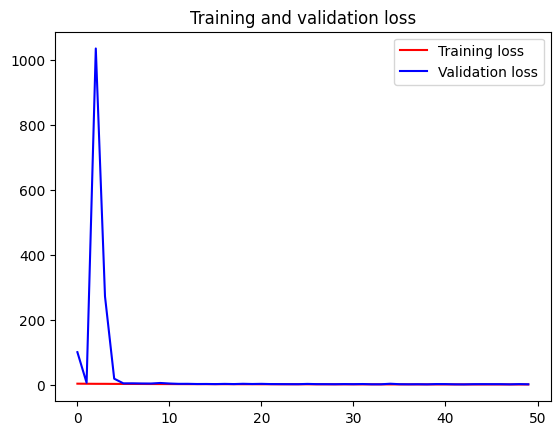

In [7]:
# train_ds, val_ds, class_names, num_classes
# with tensorflow.device("/CPU:0"):
def exec_train_InceptionV3():
    mod_name = "InceptionV3"
    inception_mod = create_model__inception_v3(num_classes)
    summary_model(inception_mod)
    inception_mod, hist = train_model(
        inception_mod, model_name=mod_name, train_ds=train_ds, val_ds=val_ds
    )
    view_train_chart(hist)
    os.makedirs("./models/img_clsr", exist_ok=True)
    inception_mod.save(f"./models/img_clsr/{mod_name}.keras")

exec_train_InceptionV3()

In [8]:
def show_model_train_log(file_list = None):
    import pandas as pd
    import glob
    import os
    import regex as re
    if not file_list:
        model_name = ["ResNet151V2", "InceptionV3"]
        model_data = pd.DataFrame()
        for mod in model_name:
            list_of_files = glob.glob(f"./logs/training__{mod}*.csv") # * means all if need specific format then *.csv
            latest_file = max(list_of_files, key=os.path.getctime)
            print(latest_file)
            df = pd.read_csv(latest_file)
            df['model_name']=mod

            model_data = pd.concat([model_data, df], ignore_index=True, sort=False)

        return model_data
    else:
        model_data = pd.DataFrame()

        for log_file in file_list:
            print(log_file)
            regex = re.compile(r"training__(\w+).csv")
            df = pd.read_csv(log_file)
            df["model_name"] = regex.search(log_file).group(1)
            # df['timestamp'] = time.strptime(os.path.getctime(log_file)).strftime("%Y-%m-%d %H:%M:%S")
            # df["timestamp"] = regex.search(log_file).group(2)
            model_data = pd.concat([model_data, df], ignore_index=True, sort=False)

        return model_data

def plot_loss_graph(df):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    plt.plot(df["epoch"],df["loss"],label="loss")
    plt.plot(df["epoch"],df["val_loss"],label="val_loss")
    plt.legend()
    plt.show()


def plot_acc_graph(df):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    plt.plot(df["epoch"],df["acc"],label="acc")
    plt.plot(df["epoch"],df["val_acc"],label="val_acc")
    plt.legend()
    plt.show()

In [9]:
# local
df =  show_model_train_log()
# df = show_model_train_log()



./logs/training__ResNet151V2__2024-05-08_13-08-22.csv
./logs/training__InceptionV3__2024-05-08_21-33-01.csv


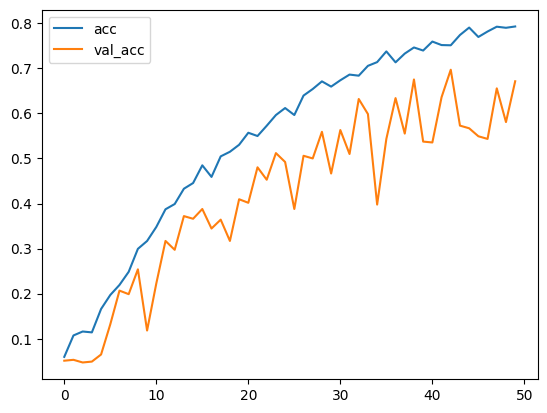

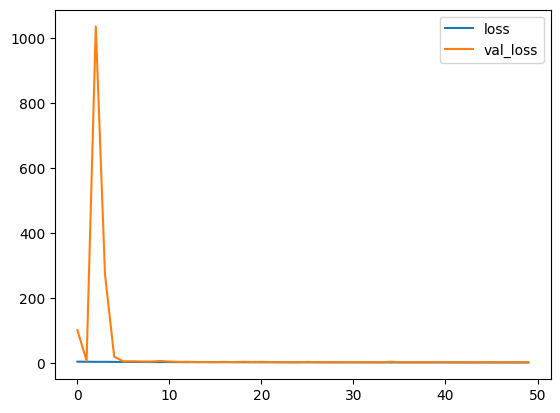

In [10]:
inception_data = df.query("model_name ==  'InceptionV3' | model_name == 'inception_v3' ")
plot_acc_graph(inception_data)
plot_loss_graph(inception_data)

In [11]:
df.iloc[inception_data['epoch'].idxmax()]

epoch                  49
acc              0.792819
loss             0.638781
val_acc           0.67126
val_loss         1.223282
model_name    InceptionV3
Name: 99, dtype: object

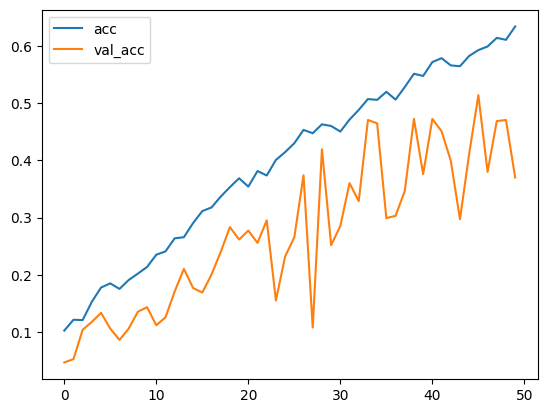

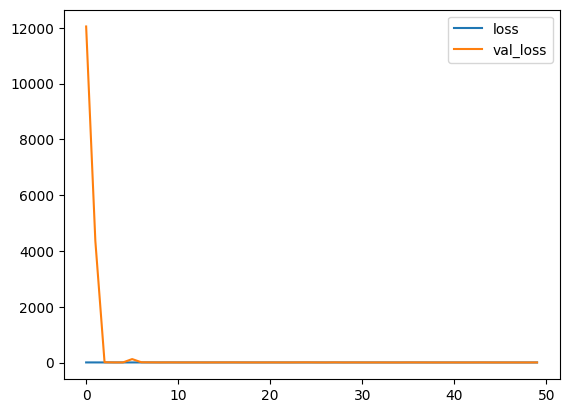

In [12]:
# resnet_data = df[df["model_name"] == "resnet151_v2"]
resnet_data = df.query("model_name ==  'ResNet151V2' | model_name =='resnet151_v2' ")
plot_acc_graph(resnet_data)
plot_loss_graph(resnet_data)

In [13]:
df.iloc[resnet_data["epoch"].idxmax()]

epoch                  49
acc              0.633673
loss             1.067622
val_acc          0.370079
val_loss         2.218444
model_name    ResNet151V2
Name: 49, dtype: object

In [14]:
# test run, evaluate the model